In [1]:
import os
import torch
import random
import torchvision
from torch import nn
import lightning.pytorch as pl
import torchvision.transforms as T
import torchvision.models as models
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.datasets import MNIST, CIFAR10
from lightning.pytorch.loggers import TensorBoardLogger
from torch.utils.data import TensorDataset, DataLoader, random_split
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import numpy as np

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True, num_workers=8)

val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

In [4]:
class LatentAugmentation(nn.Module):
    def __init__(self, mean=0, std=0.1):
        super(LatentAugmentation, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        if self.training:
            noise = torch.normal(mean=self.mean, std=self.std, size=x.size()).to(x.device)
            return x + noise
        return x

In [5]:
   
class Encoder(nn.Module):
    def __init__(self, input_channels=3, latent_dim=256, dropout_prob=0.2):
        super(Encoder, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(dropout_prob)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(dropout_prob)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout2d(dropout_prob)

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

    def forward(self, x):
        # Apply first convolutional layer, followed by batch normalization, dropout, and ReLU activation
        x = F.relu(self.dropout1(self.bn1(self.conv1(x))))

        # Apply second convolutional layer, followed by batch normalization, dropout, and ReLU activation
        x = F.relu(self.dropout2(self.bn2(self.conv2(x))))

        # Apply third convolutional layer, followed by batch normalization, dropout, and ReLU activation
        x = F.relu(self.dropout3(self.bn3(self.conv3(x))))

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Get mean and log variance for the latent space
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        return mu, log_var


class CBN(nn.Module):
    def __init__(self, num_features, embedding_dim):
        super(CBN, self).__init__()
        self.gamma = nn.Linear(embedding_dim, num_features)
        self.beta = nn.Linear(embedding_dim, num_features)
        
    def forward(self, x, y):
        gamma = self.gamma(y)
        beta = self.beta(y)
        out = F.batch_norm(x, running_mean=None, running_var=None, weight=None, bias=None, training=True)
        out = gamma.view(gamma.size(0), -1, 1, 1) * out + beta.view(beta.size(0), -1, 1, 1)
        return out


class Decoder(nn.Module):
    def __init__(self, latent_dim, img_dim, num_channels):
        super(Decoder, self).__init__()
        
        # Convert integer labels to one-hot vectors
        self.num_classes = 10
        self.img_dim = img_dim
        
        self.embedding = nn.Embedding(self.num_classes, self.num_classes)
        
        # Complex projection for label embedding
        self.label_projection = nn.Sequential(
            nn.Linear(self.num_classes, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, latent_dim)
        )
        
        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(latent_dim + latent_dim, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256 + latent_dim, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128 + latent_dim, 256, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(256 + latent_dim, num_channels, kernel_size=4, stride=2, padding=1, output_padding=1)
        
    def forward(self, z, y):
        # Convert y to one-hot encoded vectors
        y_one_hot = self.embedding(y)
        y_one_hot = y_one_hot.squeeze(1)
        
        # Project the label embeddings using the MLP
        projected_label = self.label_projection(y_one_hot)
        

        x = torch.cat([z, projected_label], dim=1).unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.deconv1(x))

        # Upsample projected_label to match x's spatial dimensions
        projected_label_upsampled = F.interpolate(projected_label.unsqueeze(-1).unsqueeze(-1), size=(x.shape[2], x.shape[3]))

        # Second layer
        x = torch.cat([x, projected_label_upsampled], dim=1)
        x = F.relu(self.deconv2(x))

        # Upsample projected_label to match x's spatial dimensions
        projected_label_upsampled = F.interpolate(projected_label.unsqueeze(-1).unsqueeze(-1), size=(x.shape[2], x.shape[3]))

        # Third layer
        x = torch.cat([x, projected_label_upsampled], dim=1)
        x = F.relu(self.deconv3(x))

        # Upsample projected_label to match x's spatial dimensions
        projected_label_upsampled = F.interpolate(projected_label.unsqueeze(-1).unsqueeze(-1), size=(x.shape[2], x.shape[3]))

        # Fourth layer
        x = torch.cat([x, projected_label_upsampled], dim=1)
        x = torch.sigmoid(self.deconv4(x))

        # Ensure the output matches the desired image dimensions
        x = F.interpolate(x, size=(self.img_dim, self.img_dim))

        return x



In [6]:
def randomize_labels(y, num_classes=10, p=0.25):
    """
    Randomly change the labels for a fraction p of the samples.

    Parameters:
    - y: tensor of shape (batch_size,) containing the original labels.
    - num_classes: total number of classes.
    - p: fraction of labels to change.

    Returns:
    - y_new: tensor of shape (batch_size,) containing the modified labels.
    """

    # Determine the number of labels to change
    device = y.device
    batch_size = y.size(0)
    num_change = int(batch_size * p)

    # Randomly select indices to change
    change_indices = torch.randperm(batch_size)[:num_change].to(device)

    # Generate random labels for the selected indices
    random_labels = torch.randint(0, num_classes, (num_change,)).to(device)

    # Ensure the new random labels are different from the original labels
    while torch.any(y[change_indices] == random_labels):
        mask = y[change_indices] == random_labels
        random_labels[mask.to(device)] = torch.randint(0, num_classes, (mask.sum(),)).to(device)

    # Create a copy of the original labels and modify the selected indices
    y_new = y.clone()
    y_new[change_indices] = random_labels

    return y_new

In [7]:
def smooth_labels(labels, epsilon=0.1):
    """
    Apply label smoothing to the given labels.
    
    Args:
    - labels (torch.Tensor): The original labels in one-hot format.
    - epsilon (float): Smoothing factor. Determines the strength of smoothing.
    
    Returns:
    - torch.Tensor: Smoothed labels.
    """
    # Calculate the number of classes from the labels tensor
    num_classes = labels.shape[-1]
    
    # Calculate the smoothed value for "1" and "0" labels
    smoothed_positive = 1.0 - epsilon
    smoothed_negative = epsilon / (num_classes - 1)
    
    # Apply label smoothing
    smoothed_labels = torch.where(labels == 1, smoothed_positive, smoothed_negative)
    
    return smoothed_labels

In [18]:
class VAE(pl.LightningModule):
    def __init__(self, num_classes=10, latent_dim=512, img_dim=32, num_channels=3, labels_p=0.9, bet=0.001, beta_scale_factor=1.1):
        super().__init__()

        self.img_dim = img_dim
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.labels_p = labels_p
        self.randomize_labels = randomize_labels
        self.idx2onehot = idx2onehot
        self.last_batch = None
        self.latent_augmentation = LatentAugmentation()
        self.bet = bet
        self.beta_scale_factor = beta_scale_factor
        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = Encoder(input_channels=num_channels, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, img_dim=img_dim, num_channels=num_channels)
        self.net = CIFARNet()
        self.net.load_state_dict(torch.load('CIFAR-MODEL.pt'))
        #self.net.requires_grad_(False)
        self.label_loss = nn.BCELoss(reduction='none')
        self.generate_image = generate_image

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-4,
            steps_per_epoch=98,
            epochs=self.trainer.max_epochs,
            pct_start=40/self.trainer.max_epochs,
            div_factor=100,
            final_div_factor=10,
            anneal_strategy='cos'
        )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}

    def gaussian_likelihood(self, mean, logscale, sample):

        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def model_step(self, batch, stage='train'):

        x, y = batch
        y_sec = self.randomize_labels(y, self.num_classes, p=self.labels_p)

        y_one_hot = self.idx2onehot(y, self.num_classes)
        y_one_hot_sec = self.idx2onehot(y_sec, self.num_classes)
        
        combined_one_hot = torch.clamp(y_one_hot + y_one_hot_sec, 0, 1)
        smoothed_labels = smooth_labels(combined_one_hot) 
                
        mu, log_var = self.encoder(x)
        std = torch.exp(log_var/2)

        # Augment the latent variable
        if stage == 'train':
            mu = mu #self.latent_augmentation(mu)

        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z, y_sec)
        x_hat_pred = self.net(x_hat)
        x_hat_pred = torch.sigmoid(x_hat_pred)
        
        diff_primary = torch.abs(x_hat_pred[torch.arange(x_hat_pred.size(0)), y] - smoothed_labels[torch.arange(x_hat_pred.size(0)), y]).mean()
        diff_secondary = torch.abs(x_hat_pred[torch.arange(x_hat_pred.size(0)), y_sec] - smoothed_labels[torch.arange(x_hat_pred.size(0)), y_sec]).mean()
        
        loss = self.label_loss(x_hat_pred, smoothed_labels)
        loss = loss.sum(dim=1)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (self.bet*kl - recon_loss)
        
        total_loss = (elbo*0.001) + loss
        total_loss = total_loss.mean()
        return(kl, elbo.mean(), total_loss, loss.mean(), diff_primary, diff_secondary)

    def training_step(self, batch, batch_idx):
        kl, elbo, total_loss, label_loss, avg_diff_primary, avg_diff_secondary = self.model_step(batch)
        
        self.log('elbo_train', elbo, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('total_loss_train', total_loss, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('label_loss_train', label_loss, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('avg_diff_primary_train', avg_diff_primary, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('avg_diff_secondary_train', avg_diff_secondary, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        kl, elbo, total_loss, label_loss, avg_diff_primary, avg_diff_secondary = self.model_step(batch, stage='val')
        x, y = batch
        x, y = x[:25], y[:25]

        if x.shape[0] > 24:
          self.last_batch = (x, y)

        self.log('elbo_val', elbo, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('total_loss_val', total_loss, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('label_loss_val', label_loss, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('avg_diff_primary_val', avg_diff_primary, prog_bar=True, on_epoch=True, on_step=True, logger=True)
        self.log('avg_diff_secondary_val', avg_diff_secondary, prog_bar=True, on_epoch=True, on_step=True, logger=True)

        return total_loss

    def on_validation_epoch_end(self):
        x, y = self.last_batch
        test_hat, y_incorrect = self.computeVae(x, y)
        self.generate_image(test_hat, y, y_incorrect, self.current_epoch)
        

    def computeVae(self, x, y):

        y_sec = self.randomize_labels(y, self.num_classes, p=self.labels_p)
        mu, log_var = self.encoder(x)

        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        x_hat = self.decoder(z, y_sec)
        return(x_hat, y_sec)

    def update_beta(self):
        """Scale up the value of beta."""
        self.bet *= self.beta_scale_factor if self.bet < 1 else 1
        self.log('beta', self.bet, on_epoch=True, logger=True)
        

    def on_train_epoch_end(self):
        """Called at the end of every epoch."""
        self.update_beta()

In [9]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)

    return onehot

In [10]:
class CIFARNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFARNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # 1x1 convolutions for skip connections
        self.skip1 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        self.skip2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.skip3 = nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 1x1 convolution layers to replace fully connected layers
        self.conv_fc1 = nn.Conv2d(512, 512, kernel_size=1)
        self.conv_fc2 = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # First convolutional layer
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = self.pool(x1)


        # Second convolutional layer with skip connection from the first layer
        x2 = self.pool(F.relu(self.bn2(self.conv2(x1))))
        x2 += F.interpolate(self.skip1(x1), size=x2.size()[2:], mode='nearest')

        # Third convolutional layer with skip connection from the second layer
        x3 = self.pool(F.relu(self.bn3(self.conv3(x2))))
        x3 += F.interpolate(self.skip2(x2), size=x3.size()[2:], mode='nearest')

        # Fourth convolutional layer with skip connection from the third layer
        x4 = self.pool(F.relu(self.bn4(self.conv4(x3))))
        x4 += F.interpolate(self.skip3(x3), size=x4.size()[2:], mode='nearest')

        # 1x1 convolution layers
        x = F.relu(self.conv_fc1(x4))
        x = self.conv_fc2(x)

        # Global average pooling
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)

        return x



In [11]:
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

In [12]:
def get_labels(y, correct_class=True):
    if correct_class:
        return(y)
    else:
        incorrect_labels = []
        for eachy in y:
            p = eachy.item()
            if p > 4:
                p -= random.choice(list(range(1, 4)))
            else:
                p += random.choice(list(range(1, 4)))
            incorrect_labels.append(p)
        return(torch.tensor(incorrect_labels).to(y.device))

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def generate_image(gen_images, correct_y, incorrect_y, epoch):

    num_images = len(incorrect_y)
    num_cols = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.ceil(num_images / num_cols))

    fig = plt.figure(figsize=(10,10))
    
    for idx in np.arange(num_images):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])
        plt.imshow(unorm(gen_images[idx]).to('cpu').permute(1,2,0), cmap='cividis')
        ax.set_title(f"Lab/Img:{classes[incorrect_y[idx]]}/{classes[correct_y[idx]]}")


    fig.tight_layout()
    plt.show()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | latent_augmentation | LatentAugmentation | 0     
1 | encoder             | Encoder            | 4.6 M 
2 | decoder             | Decoder            | 8.5 M 
3 | net                 | CIFARNet           | 2.0 M 
4 | label_loss          | BCELoss            | 0     
-----------------------------------------------------------
15.1 M    Trainable params
0         Non-trainable params
15.1 M    Total params
60.217    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 37.73it/s]

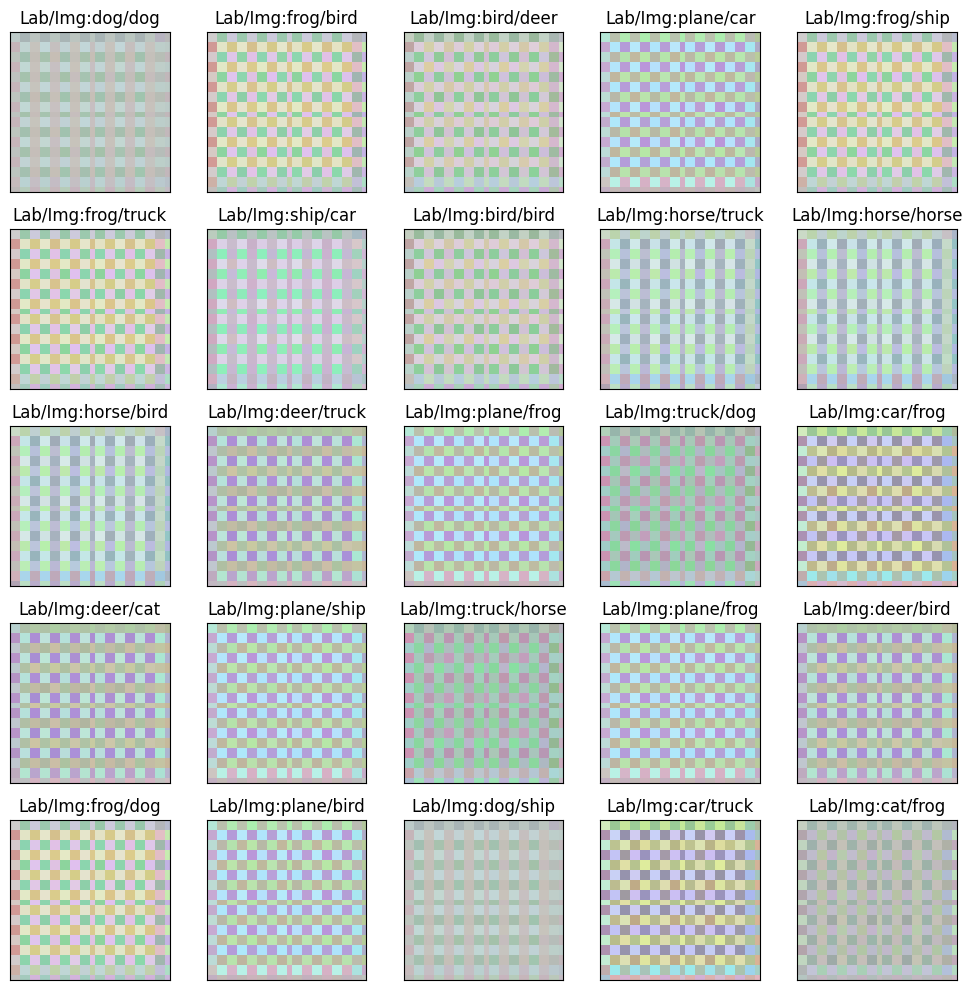

Epoch 33:  45%|████▍     | 44/98 [12:35<15:27, 17.17s/it, v_num=3, elbo_train_step=nan.0, total_loss_train_step=nan.0, label_loss_train_step=2.810, avg_diff_primary_train_step=0.628, avg_diff_secondary_train_step=0.0512, elbo_train_epoch=1.78e+3, total_loss_train_epoch=3.410, label_loss_train_epoch=1.630, avg_diff_primary_train_epoch=0.192, avg_diff_secondary_train_epoch=0.0328, elbo_val_step=1.99e+3, total_loss_val_step=4.000, label_loss_val_step=2.020, avg_diff_primary_val_step=0.264, avg_diff_secondary_val_step=0.0204, elbo_val_epoch=1.76e+3, total_loss_val_epoch=3.710, label_loss_val_epoch=1.950, avg_diff_primary_val_epoch=0.271, avg_diff_secondary_val_epoch=0.0323]


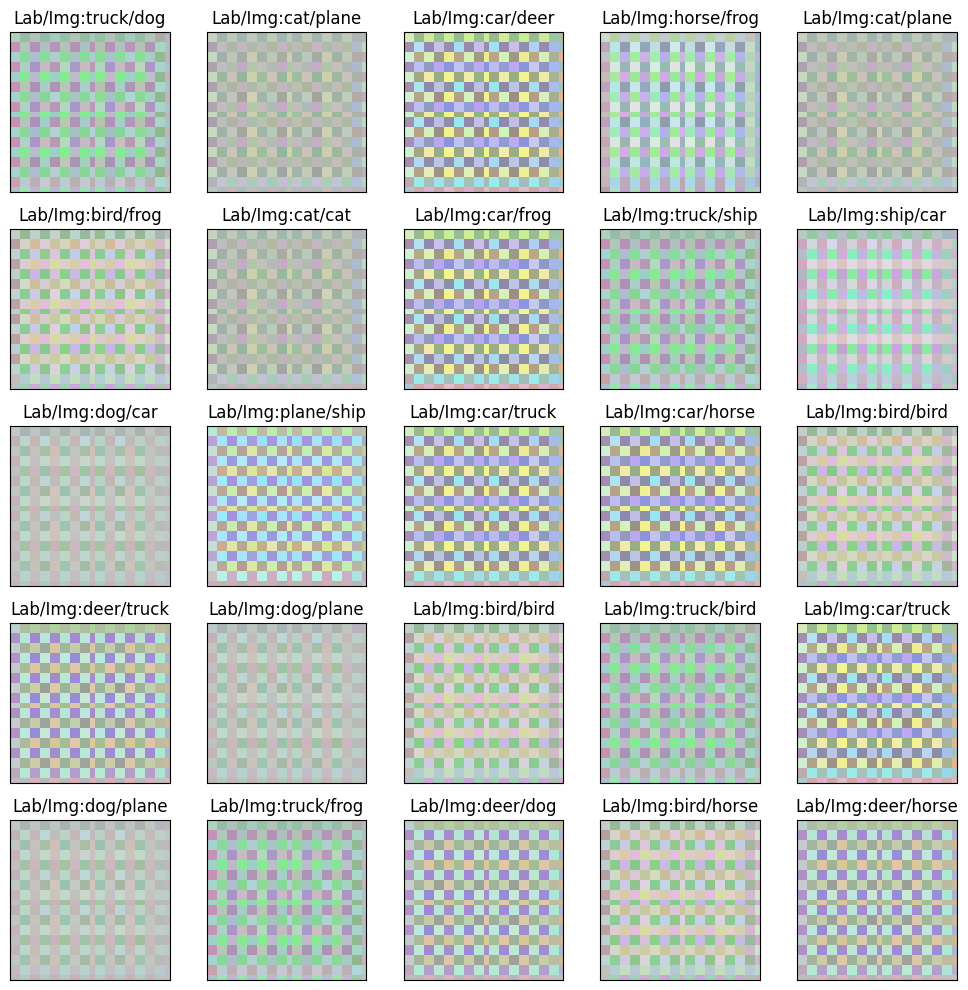

Epoch 9: 100%|██████████| 98/98 [00:07<00:00, 12.48it/s, v_num=5, elbo_train_step=3.5e+3, total_loss_train_step=6.530, label_loss_train_step=3.030, avg_diff_primary_train_step=0.659, avg_diff_secondary_train_step=0.0483, elbo_train_epoch=3.61e+3, total_loss_train_epoch=6.820, label_loss_train_epoch=3.210, avg_diff_primary_train_epoch=0.690, avg_diff_secondary_train_epoch=0.0493, elbo_val_step=3.75e+3, total_loss_val_step=6.940, label_loss_val_step=3.190, avg_diff_primary_val_step=0.702, avg_diff_secondary_val_step=0.0311, elbo_val_epoch=3.73e+3, total_loss_val_epoch=7.060, label_loss_val_epoch=3.330, avg_diff_primary_val_epoch=0.731, avg_diff_secondary_val_epoch=0.0283] 

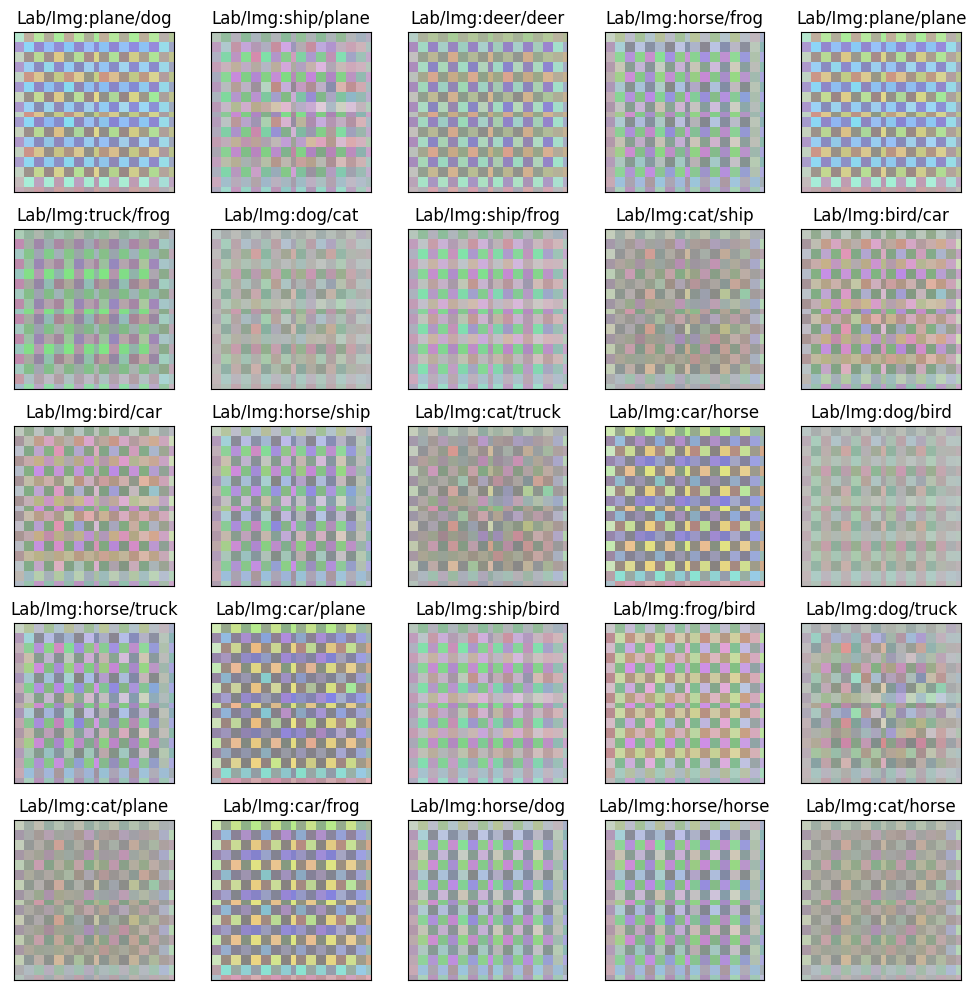

Epoch 14: 100%|██████████| 98/98 [00:07<00:00, 12.68it/s, v_num=5, elbo_train_step=3.27e+3, total_loss_train_step=6.070, label_loss_train_step=2.800, avg_diff_primary_train_step=0.592, avg_diff_secondary_train_step=0.0418, elbo_train_epoch=3.31e+3, total_loss_train_epoch=6.170, label_loss_train_epoch=2.860, avg_diff_primary_train_epoch=0.612, avg_diff_secondary_train_epoch=0.0415, elbo_val_step=3.53e+3, total_loss_val_step=6.520, label_loss_val_step=2.990, avg_diff_primary_val_step=0.637, avg_diff_secondary_val_step=0.0313, elbo_val_epoch=3.5e+3, total_loss_val_epoch=6.460, label_loss_val_epoch=2.960, avg_diff_primary_val_epoch=0.651, avg_diff_secondary_val_epoch=0.0357]

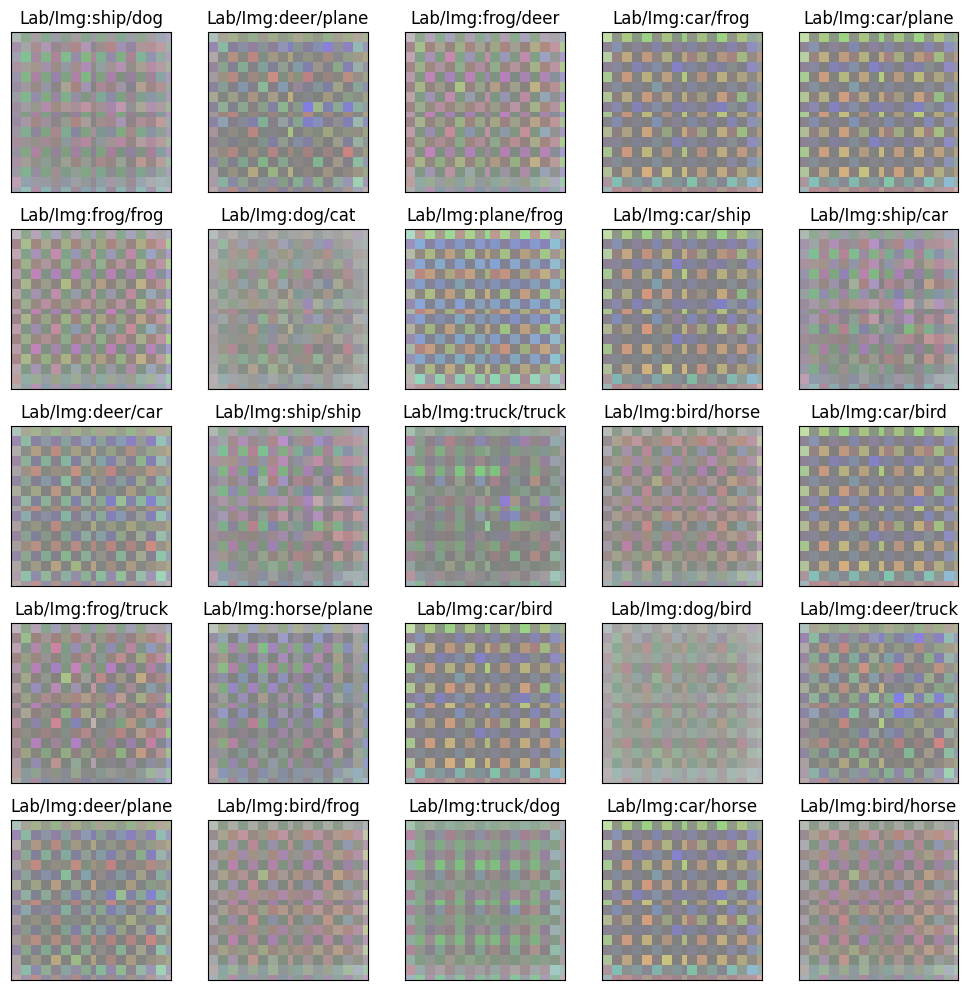

Epoch 19: 100%|██████████| 98/98 [00:07<00:00, 12.42it/s, v_num=5, elbo_train_step=3.17e+3, total_loss_train_step=5.700, label_loss_train_step=2.530, avg_diff_primary_train_step=0.497, avg_diff_secondary_train_step=0.0397, elbo_train_epoch=3.19e+3, total_loss_train_epoch=5.740, label_loss_train_epoch=2.550, avg_diff_primary_train_epoch=0.518, avg_diff_secondary_train_epoch=0.0384, elbo_val_step=3.3e+3, total_loss_val_step=6.130, label_loss_val_step=2.820, avg_diff_primary_val_step=0.581, avg_diff_secondary_val_step=0.0217, elbo_val_epoch=3.27e+3, total_loss_val_epoch=5.940, label_loss_val_epoch=2.680, avg_diff_primary_val_epoch=0.557, avg_diff_secondary_val_epoch=0.0276]

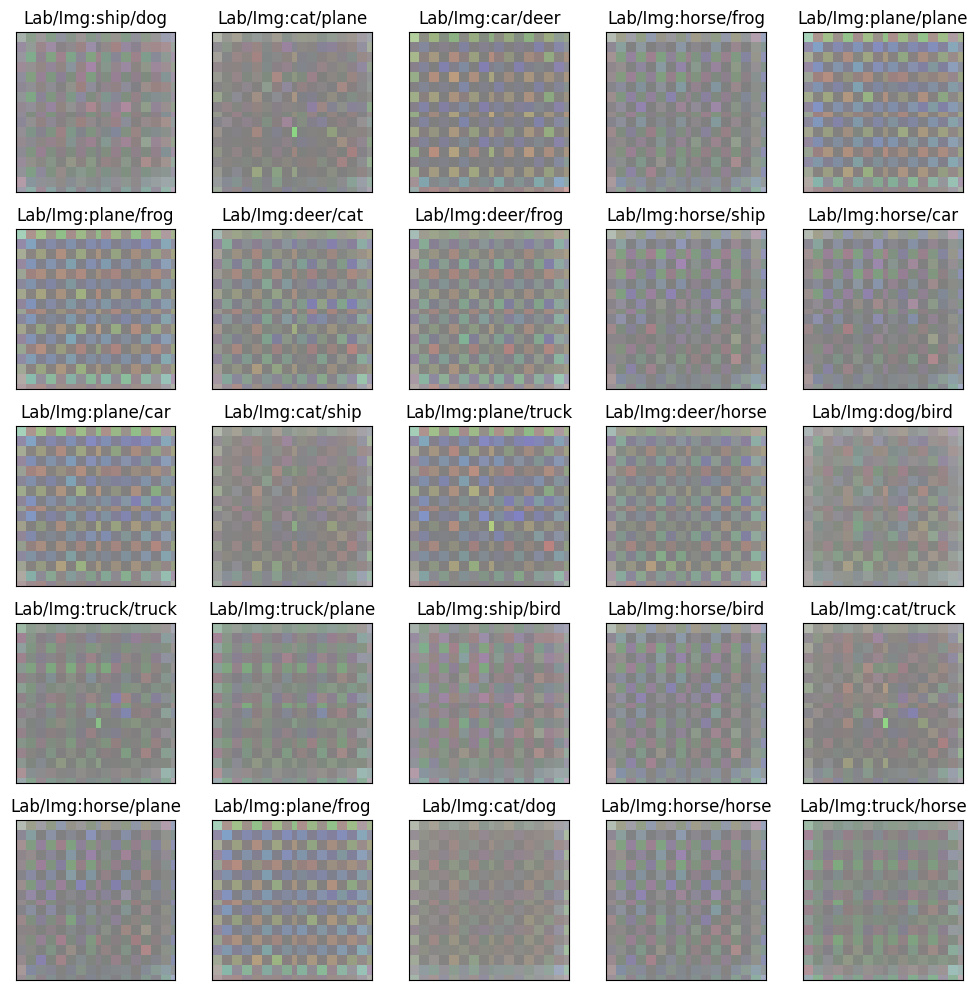

Epoch 24: 100%|██████████| 98/98 [00:07<00:00, 12.30it/s, v_num=5, elbo_train_step=3.08e+3, total_loss_train_step=5.390, label_loss_train_step=2.300, avg_diff_primary_train_step=0.438, avg_diff_secondary_train_step=0.0312, elbo_train_epoch=3.1e+3, total_loss_train_epoch=5.460, label_loss_train_epoch=2.360, avg_diff_primary_train_epoch=0.456, avg_diff_secondary_train_epoch=0.0346, elbo_val_step=3.19e+3, total_loss_val_step=5.830, label_loss_val_step=2.640, avg_diff_primary_val_step=0.493, avg_diff_secondary_val_step=0.0267, elbo_val_epoch=3.16e+3, total_loss_val_epoch=5.600, label_loss_val_epoch=2.440, avg_diff_primary_val_epoch=0.470, avg_diff_secondary_val_epoch=0.0313] 

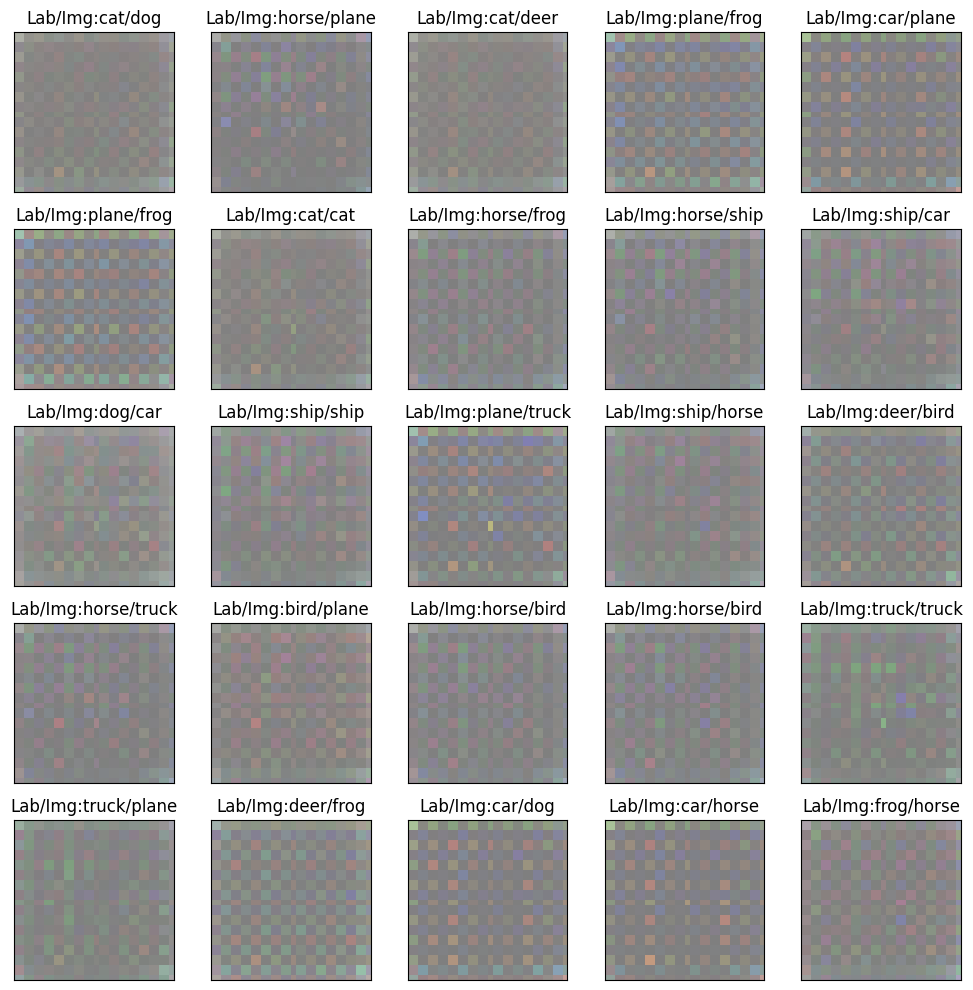

Epoch 29: 100%|██████████| 98/98 [00:07<00:00, 12.40it/s, v_num=5, elbo_train_step=2.98e+3, total_loss_train_step=5.170, label_loss_train_step=2.200, avg_diff_primary_train_step=0.399, avg_diff_secondary_train_step=0.0299, elbo_train_epoch=3.01e+3, total_loss_train_epoch=5.210, label_loss_train_epoch=2.200, avg_diff_primary_train_epoch=0.402, avg_diff_secondary_train_epoch=0.0327, elbo_val_step=3.11e+3, total_loss_val_step=5.610, label_loss_val_step=2.500, avg_diff_primary_val_step=0.491, avg_diff_secondary_val_step=0.0392, elbo_val_epoch=3.07e+3, total_loss_val_epoch=5.360, label_loss_val_epoch=2.300, avg_diff_primary_val_epoch=0.428, avg_diff_secondary_val_epoch=0.0325]

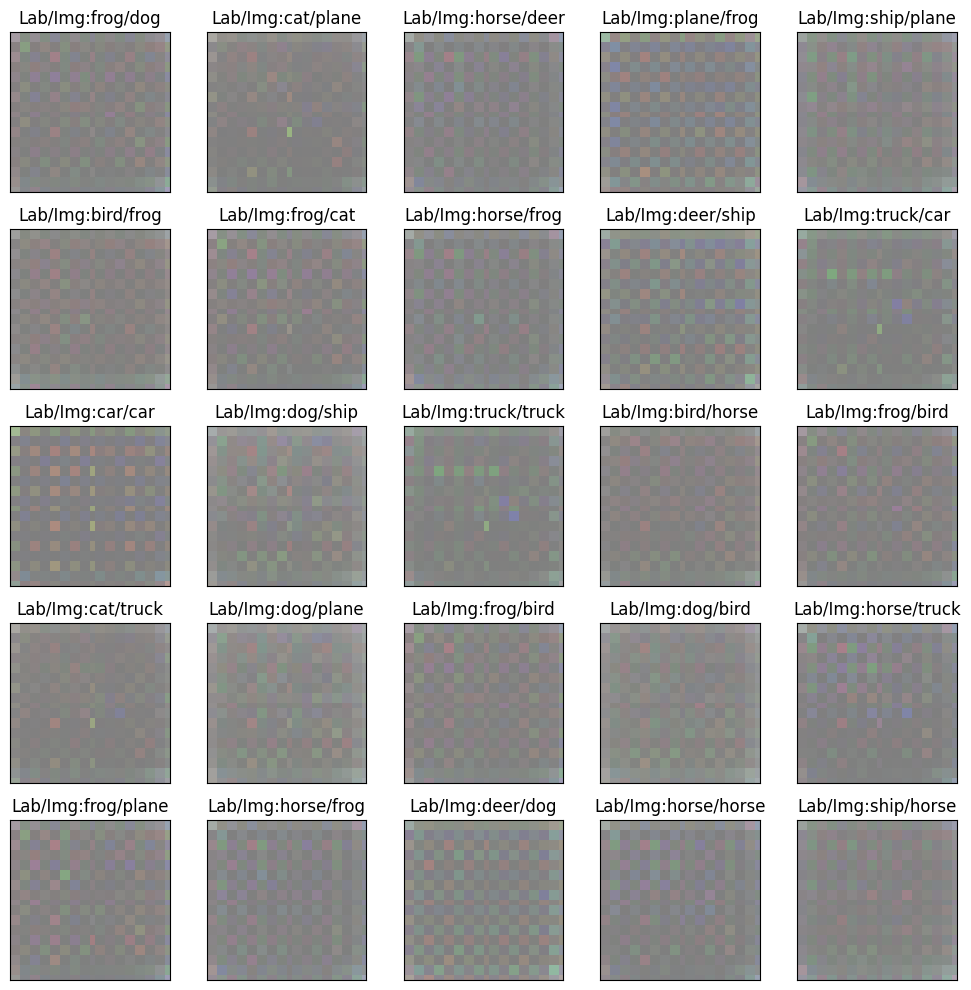

Epoch 34: 100%|██████████| 98/98 [00:08<00:00, 12.21it/s, v_num=5, elbo_train_step=2.86e+3, total_loss_train_step=4.880, label_loss_train_step=2.020, avg_diff_primary_train_step=0.334, avg_diff_secondary_train_step=0.0273, elbo_train_epoch=2.91e+3, total_loss_train_epoch=4.980, label_loss_train_epoch=2.070, avg_diff_primary_train_epoch=0.357, avg_diff_secondary_train_epoch=0.0289, elbo_val_step=3.02e+3, total_loss_val_step=5.370, label_loss_val_step=2.350, avg_diff_primary_val_step=0.480, avg_diff_secondary_val_step=0.0217, elbo_val_epoch=2.97e+3, total_loss_val_epoch=5.150, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.375, avg_diff_secondary_val_epoch=0.027] 

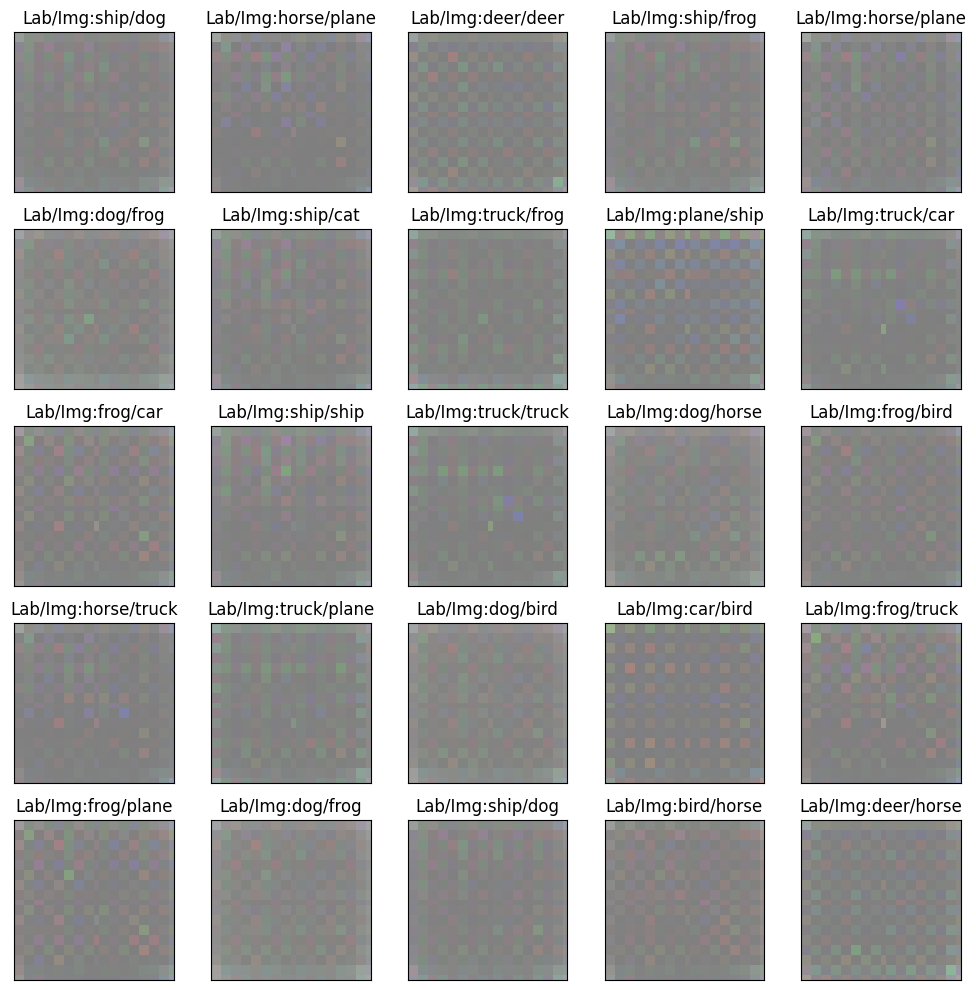

Epoch 39: 100%|██████████| 98/98 [00:07<00:00, 12.71it/s, v_num=5, elbo_train_step=2.76e+3, total_loss_train_step=4.860, label_loss_train_step=2.100, avg_diff_primary_train_step=0.359, avg_diff_secondary_train_step=0.0235, elbo_train_epoch=2.81e+3, total_loss_train_epoch=4.790, label_loss_train_epoch=1.970, avg_diff_primary_train_epoch=0.322, avg_diff_secondary_train_epoch=0.0266, elbo_val_step=2.93e+3, total_loss_val_step=5.290, label_loss_val_step=2.370, avg_diff_primary_val_step=0.442, avg_diff_secondary_val_step=0.0257, elbo_val_epoch=2.88e+3, total_loss_val_epoch=4.990, label_loss_val_epoch=2.110, avg_diff_primary_val_epoch=0.343, avg_diff_secondary_val_epoch=0.0245]

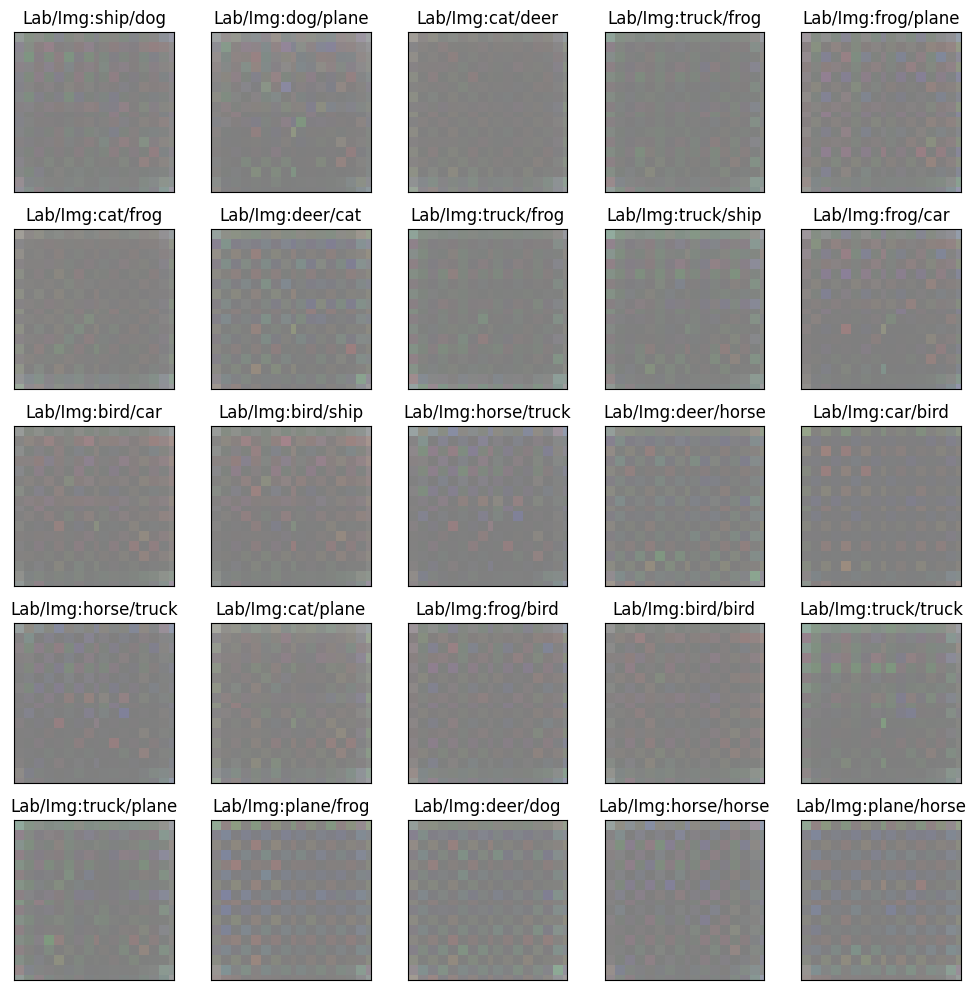

Epoch 44: 100%|██████████| 98/98 [00:07<00:00, 12.58it/s, v_num=5, elbo_train_step=2.71e+3, total_loss_train_step=4.610, label_loss_train_step=1.890, avg_diff_primary_train_step=0.304, avg_diff_secondary_train_step=0.0264, elbo_train_epoch=2.72e+3, total_loss_train_epoch=4.610, label_loss_train_epoch=1.890, avg_diff_primary_train_epoch=0.292, avg_diff_secondary_train_epoch=0.025, elbo_val_step=2.83e+3, total_loss_val_step=4.870, label_loss_val_step=2.040, avg_diff_primary_val_step=0.355, avg_diff_secondary_val_step=0.0229, elbo_val_epoch=2.78e+3, total_loss_val_epoch=4.870, label_loss_val_epoch=2.090, avg_diff_primary_val_epoch=0.332, avg_diff_secondary_val_epoch=0.0199] 

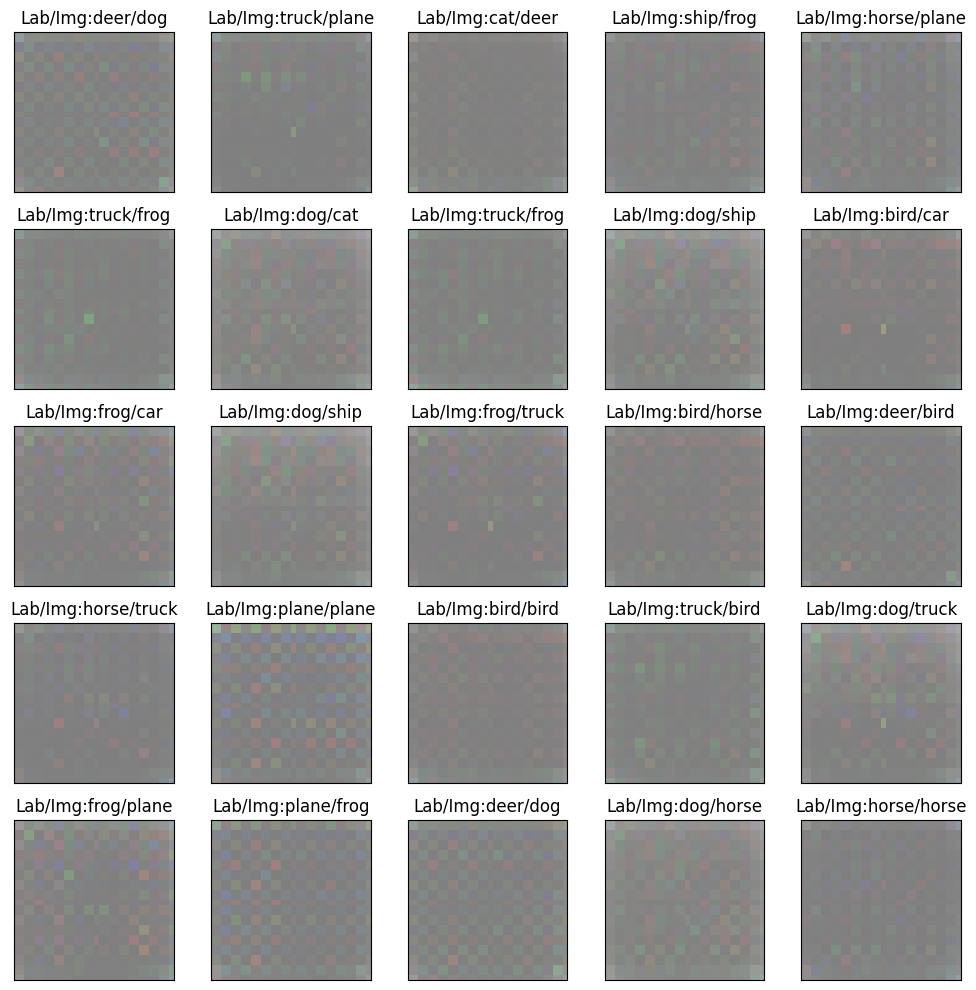

Epoch 49: 100%|██████████| 98/98 [00:07<00:00, 12.31it/s, v_num=5, elbo_train_step=2.63e+3, total_loss_train_step=4.480, label_loss_train_step=1.840, avg_diff_primary_train_step=0.285, avg_diff_secondary_train_step=0.0218, elbo_train_epoch=2.64e+3, total_loss_train_epoch=4.470, label_loss_train_epoch=1.830, avg_diff_primary_train_epoch=0.269, avg_diff_secondary_train_epoch=0.0247, elbo_val_step=2.75e+3, total_loss_val_step=4.750, label_loss_val_step=2.000, avg_diff_primary_val_step=0.318, avg_diff_secondary_val_step=0.0179, elbo_val_epoch=2.69e+3, total_loss_val_epoch=4.720, label_loss_val_epoch=2.030, avg_diff_primary_val_epoch=0.312, avg_diff_secondary_val_epoch=0.021]

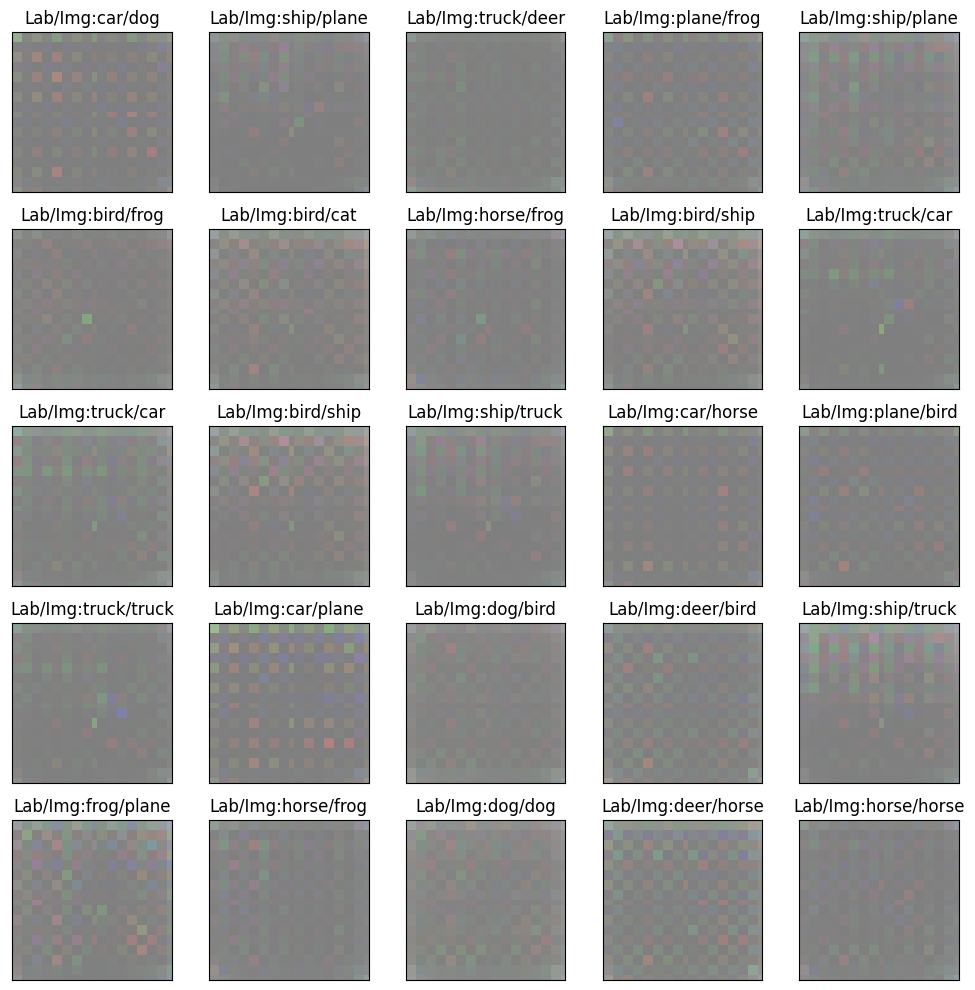

Epoch 54: 100%|██████████| 98/98 [00:07<00:00, 12.29it/s, v_num=5, elbo_train_step=2.5e+3, total_loss_train_step=4.280, label_loss_train_step=1.770, avg_diff_primary_train_step=0.248, avg_diff_secondary_train_step=0.0247, elbo_train_epoch=2.55e+3, total_loss_train_epoch=4.320, label_loss_train_epoch=1.770, avg_diff_primary_train_epoch=0.248, avg_diff_secondary_train_epoch=0.0256, elbo_val_step=2.67e+3, total_loss_val_step=4.550, label_loss_val_step=1.880, avg_diff_primary_val_step=0.314, avg_diff_secondary_val_step=0.0256, elbo_val_epoch=2.61e+3, total_loss_val_epoch=4.630, label_loss_val_epoch=2.020, avg_diff_primary_val_epoch=0.298, avg_diff_secondary_val_epoch=0.0224] 

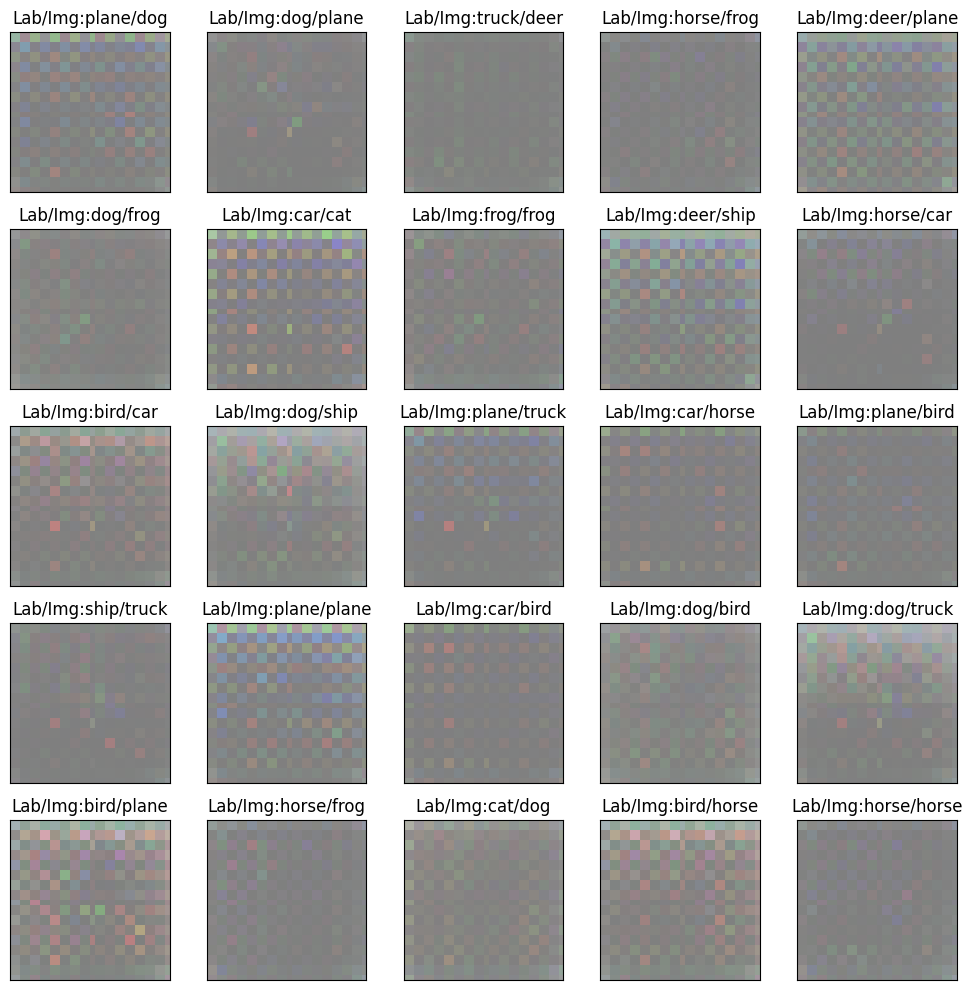

Epoch 59: 100%|██████████| 98/98 [00:07<00:00, 12.61it/s, v_num=5, elbo_train_step=2.45e+3, total_loss_train_step=4.110, label_loss_train_step=1.650, avg_diff_primary_train_step=0.217, avg_diff_secondary_train_step=0.0266, elbo_train_epoch=2.45e+3, total_loss_train_epoch=4.160, label_loss_train_epoch=1.720, avg_diff_primary_train_epoch=0.229, avg_diff_secondary_train_epoch=0.0287, elbo_val_step=2.59e+3, total_loss_val_step=4.260, label_loss_val_step=1.670, avg_diff_primary_val_step=0.301, avg_diff_secondary_val_step=0.0205, elbo_val_epoch=2.52e+3, total_loss_val_epoch=4.530, label_loss_val_epoch=2.020, avg_diff_primary_val_epoch=0.297, avg_diff_secondary_val_epoch=0.0232]

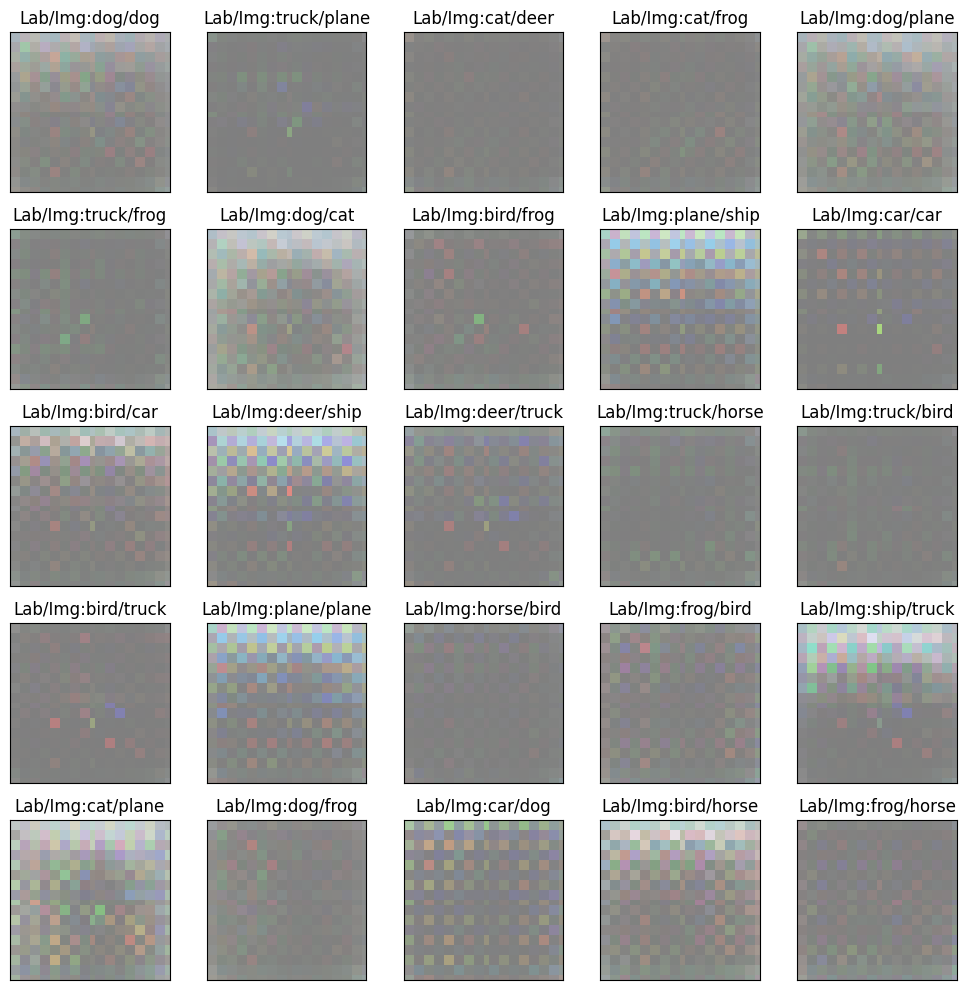

Epoch 64: 100%|██████████| 98/98 [00:07<00:00, 12.59it/s, v_num=5, elbo_train_step=2.33e+3, total_loss_train_step=4.010, label_loss_train_step=1.680, avg_diff_primary_train_step=0.236, avg_diff_secondary_train_step=0.0312, elbo_train_epoch=2.34e+3, total_loss_train_epoch=4.020, label_loss_train_epoch=1.680, avg_diff_primary_train_epoch=0.214, avg_diff_secondary_train_epoch=0.0294, elbo_val_step=2.51e+3, total_loss_val_step=4.360, label_loss_val_step=1.850, avg_diff_primary_val_step=0.268, avg_diff_secondary_val_step=0.030, elbo_val_epoch=2.4e+3, total_loss_val_epoch=4.430, label_loss_val_epoch=2.030, avg_diff_primary_val_epoch=0.289, avg_diff_secondary_val_epoch=0.0244]  

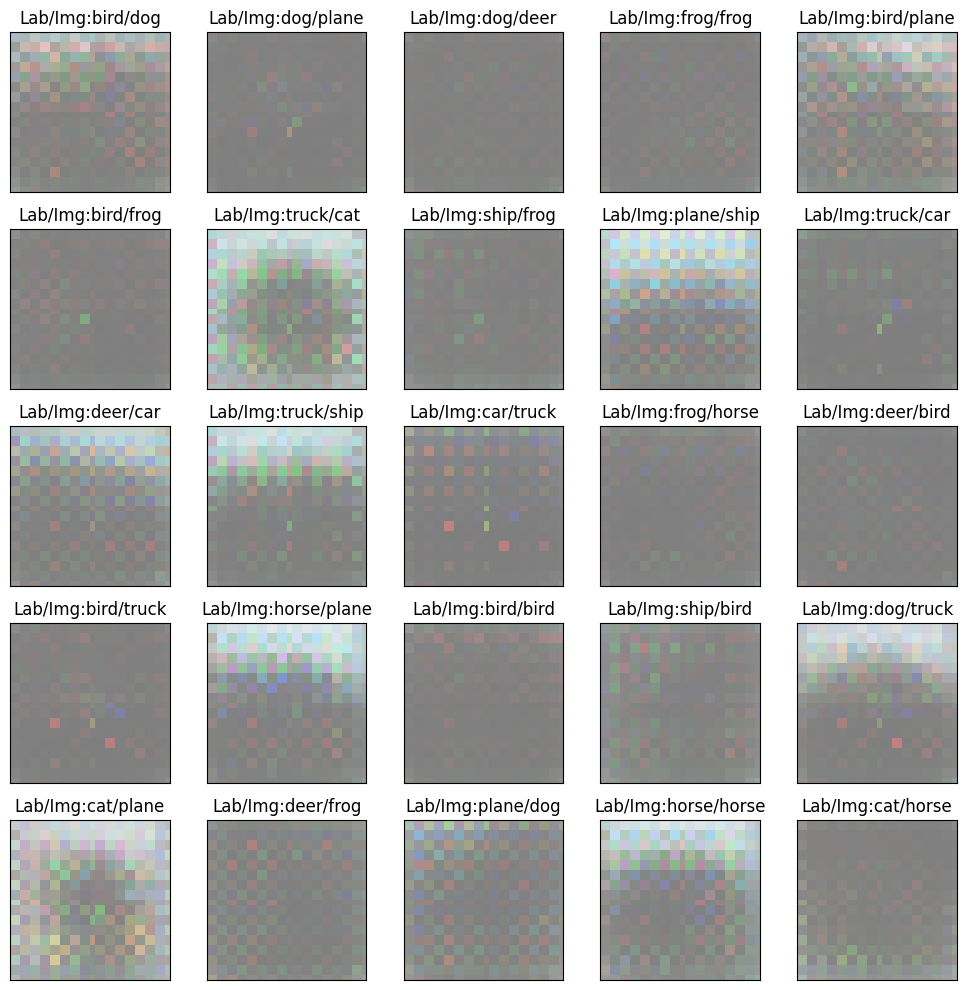

Epoch 69: 100%|██████████| 98/98 [00:07<00:00, 12.48it/s, v_num=5, elbo_train_step=2.28e+3, total_loss_train_step=3.980, label_loss_train_step=1.710, avg_diff_primary_train_step=0.219, avg_diff_secondary_train_step=0.0312, elbo_train_epoch=2.25e+3, total_loss_train_epoch=3.880, label_loss_train_epoch=1.640, avg_diff_primary_train_epoch=0.200, avg_diff_secondary_train_epoch=0.0299, elbo_val_step=2.43e+3, total_loss_val_step=4.610, label_loss_val_step=2.190, avg_diff_primary_val_step=0.328, avg_diff_secondary_val_step=0.0268, elbo_val_epoch=2.3e+3, total_loss_val_epoch=4.320, label_loss_val_epoch=2.030, avg_diff_primary_val_epoch=0.279, avg_diff_secondary_val_epoch=0.0278]

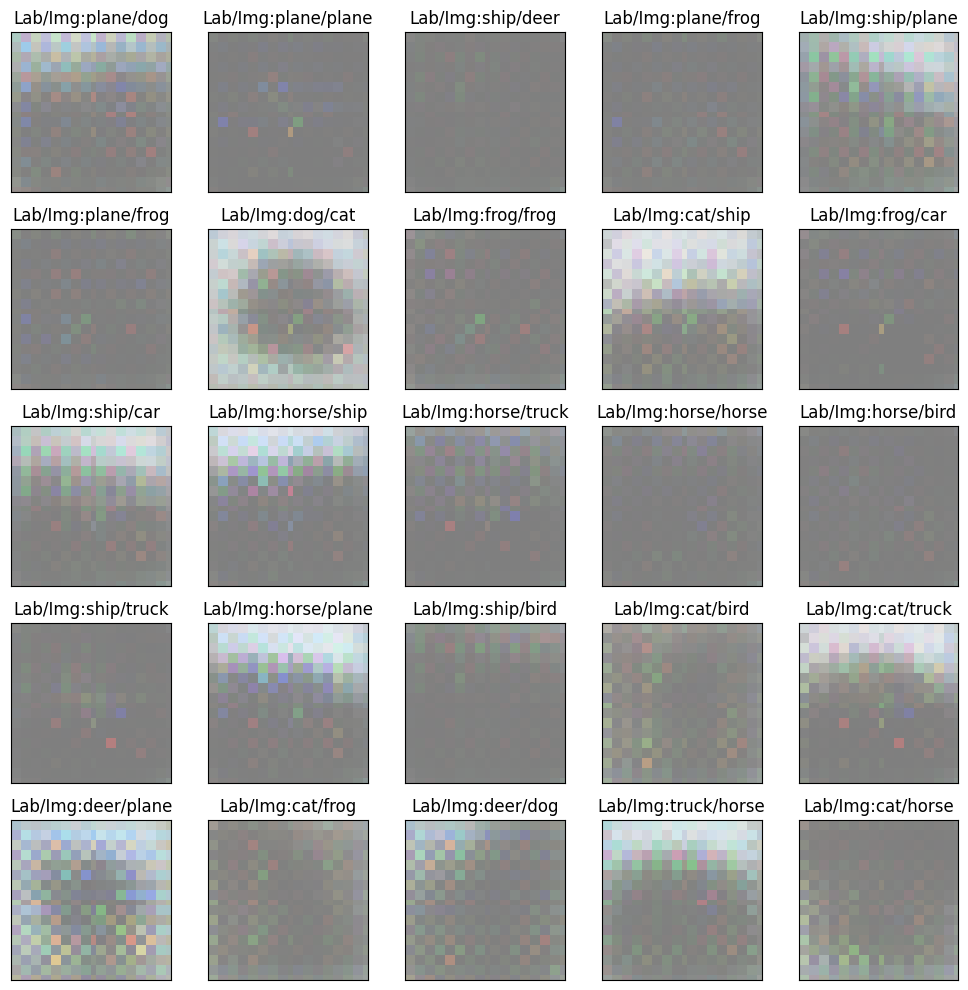

Epoch 74: 100%|██████████| 98/98 [00:07<00:00, 12.36it/s, v_num=5, elbo_train_step=2.1e+3, total_loss_train_step=3.660, label_loss_train_step=1.560, avg_diff_primary_train_step=0.182, avg_diff_secondary_train_step=0.0289, elbo_train_epoch=2.17e+3, total_loss_train_epoch=3.760, label_loss_train_epoch=1.590, avg_diff_primary_train_epoch=0.185, avg_diff_secondary_train_epoch=0.0297, elbo_val_step=2.36e+3, total_loss_val_step=4.310, label_loss_val_step=1.950, avg_diff_primary_val_step=0.280, avg_diff_secondary_val_step=0.0196, elbo_val_epoch=2.21e+3, total_loss_val_epoch=4.240, label_loss_val_epoch=2.030, avg_diff_primary_val_epoch=0.272, avg_diff_secondary_val_epoch=0.0248] 

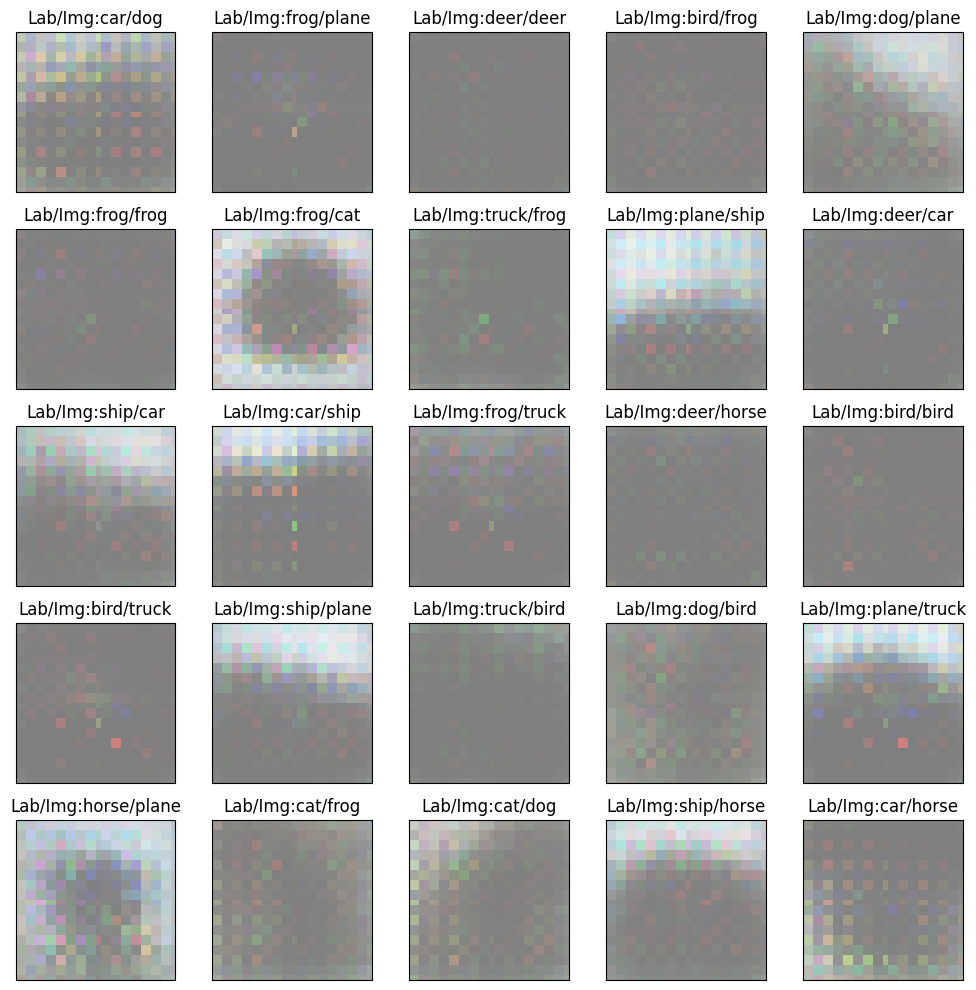

Epoch 79: 100%|██████████| 98/98 [00:07<00:00, 12.89it/s, v_num=5, elbo_train_step=2.08e+3, total_loss_train_step=3.590, label_loss_train_step=1.510, avg_diff_primary_train_step=0.156, avg_diff_secondary_train_step=0.0306, elbo_train_epoch=2.09e+3, total_loss_train_epoch=3.650, label_loss_train_epoch=1.550, avg_diff_primary_train_epoch=0.171, avg_diff_secondary_train_epoch=0.0293, elbo_val_step=2.29e+3, total_loss_val_step=4.160, label_loss_val_step=1.870, avg_diff_primary_val_step=0.308, avg_diff_secondary_val_step=0.0279, elbo_val_epoch=2.13e+3, total_loss_val_epoch=4.150, label_loss_val_epoch=2.020, avg_diff_primary_val_epoch=0.278, avg_diff_secondary_val_epoch=0.0307]

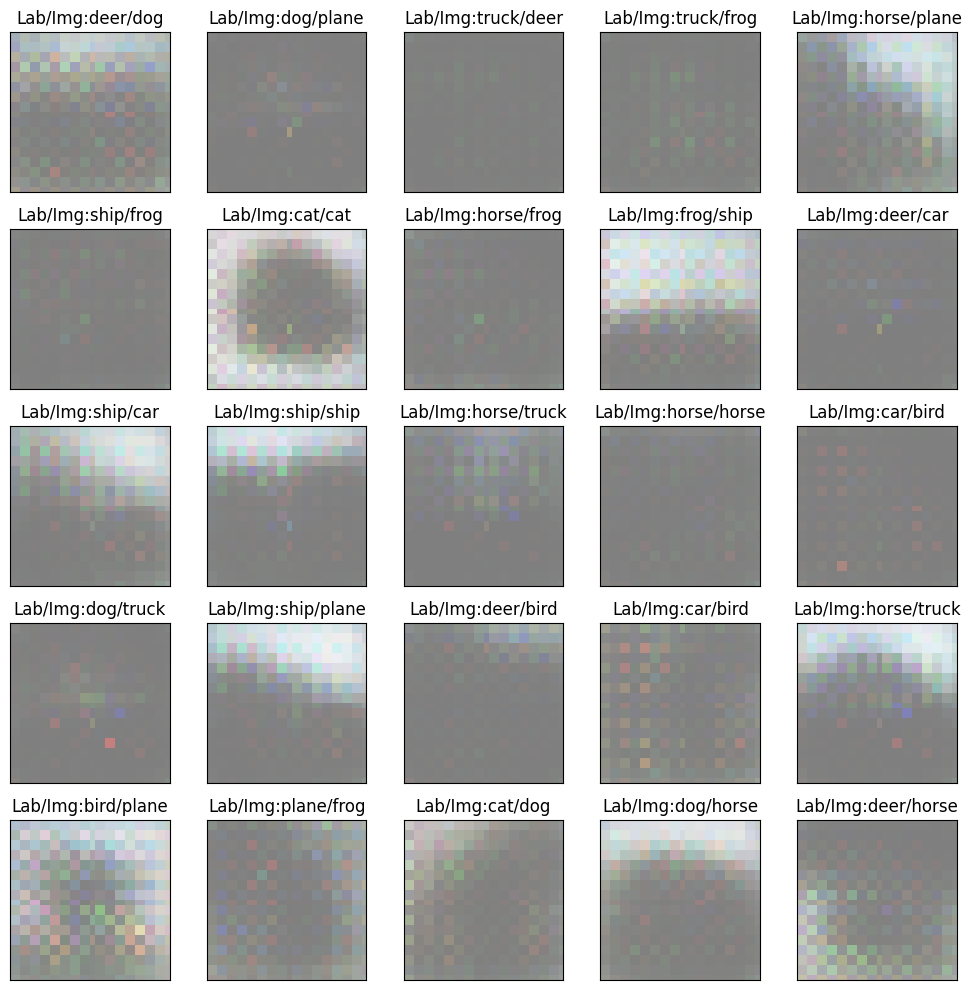

Epoch 84: 100%|██████████| 98/98 [00:07<00:00, 12.33it/s, v_num=5, elbo_train_step=2.03e+3, total_loss_train_step=3.680, label_loss_train_step=1.650, avg_diff_primary_train_step=0.203, avg_diff_secondary_train_step=0.0329, elbo_train_epoch=2.03e+3, total_loss_train_epoch=3.550, label_loss_train_epoch=1.520, avg_diff_primary_train_epoch=0.159, avg_diff_secondary_train_epoch=0.030, elbo_val_step=2.2e+3, total_loss_val_step=4.050, label_loss_val_step=1.840, avg_diff_primary_val_step=0.240, avg_diff_secondary_val_step=0.0261, elbo_val_epoch=2.05e+3, total_loss_val_epoch=4.060, label_loss_val_epoch=2.010, avg_diff_primary_val_epoch=0.266, avg_diff_secondary_val_epoch=0.0268]  

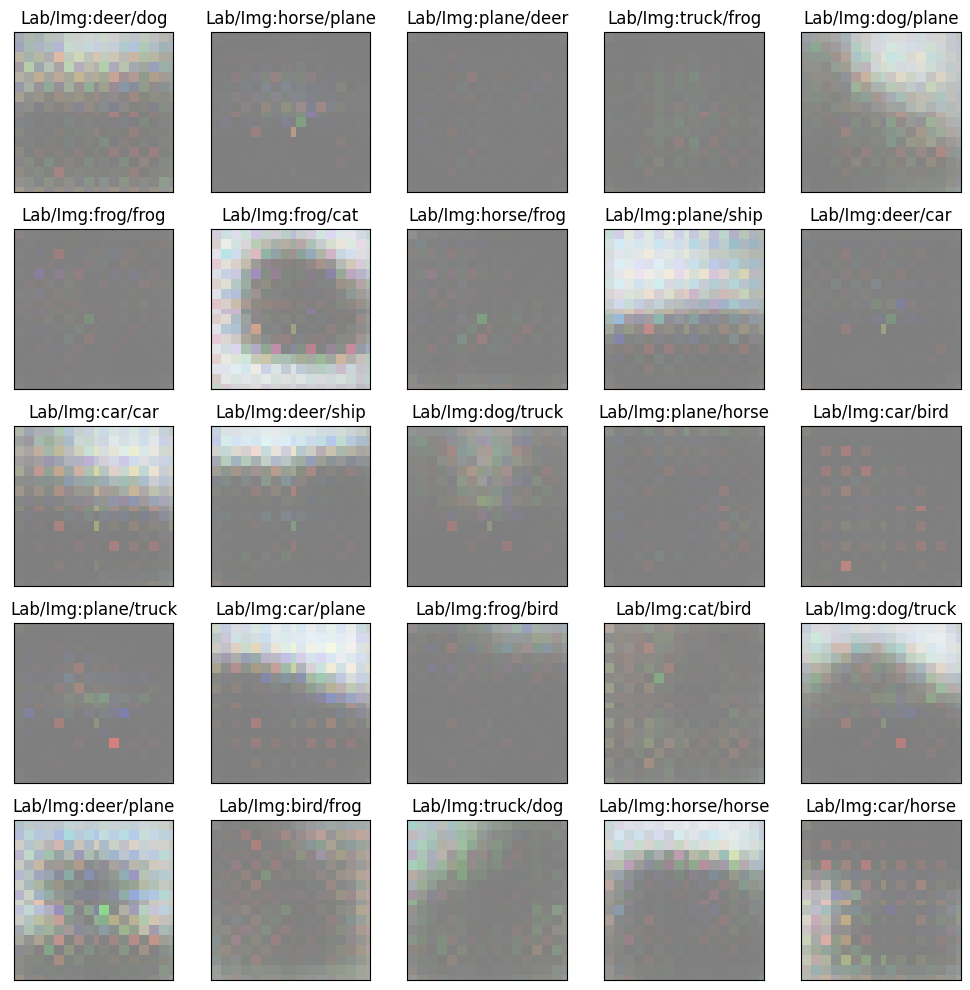

Epoch 89: 100%|██████████| 98/98 [00:07<00:00, 12.50it/s, v_num=5, elbo_train_step=1.94e+3, total_loss_train_step=3.440, label_loss_train_step=1.510, avg_diff_primary_train_step=0.161, avg_diff_secondary_train_step=0.0284, elbo_train_epoch=1.97e+3, total_loss_train_epoch=3.450, label_loss_train_epoch=1.480, avg_diff_primary_train_epoch=0.145, avg_diff_secondary_train_epoch=0.0302, elbo_val_step=2.14e+3, total_loss_val_step=4.090, label_loss_val_step=1.950, avg_diff_primary_val_step=0.261, avg_diff_secondary_val_step=0.0178, elbo_val_epoch=1.99e+3, total_loss_val_epoch=4.030, label_loss_val_epoch=2.050, avg_diff_primary_val_epoch=0.265, avg_diff_secondary_val_epoch=0.0266]

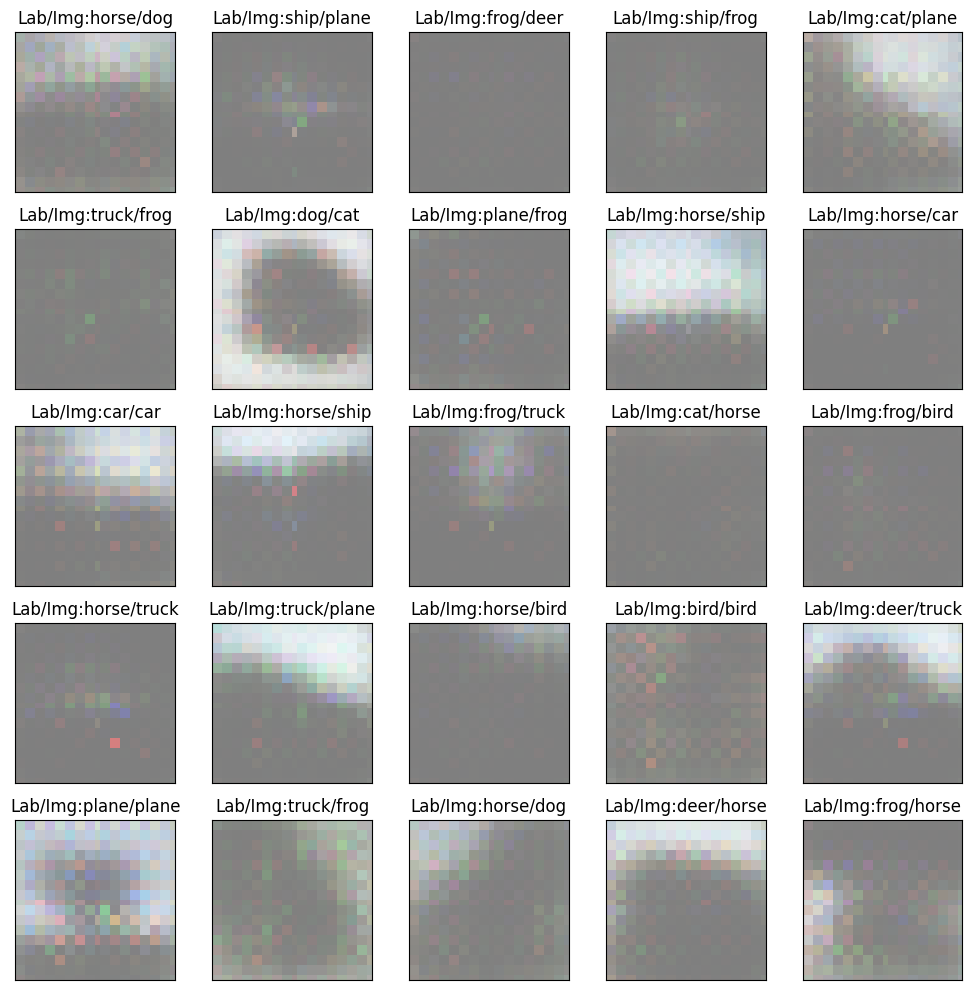

Epoch 94: 100%|██████████| 98/98 [00:07<00:00, 12.32it/s, v_num=5, elbo_train_step=1.93e+3, total_loss_train_step=3.530, label_loss_train_step=1.600, avg_diff_primary_train_step=0.168, avg_diff_secondary_train_step=0.0298, elbo_train_epoch=1.92e+3, total_loss_train_epoch=3.370, label_loss_train_epoch=1.440, avg_diff_primary_train_epoch=0.133, avg_diff_secondary_train_epoch=0.0303, elbo_val_step=2.09e+3, total_loss_val_step=3.880, label_loss_val_step=1.780, avg_diff_primary_val_step=0.194, avg_diff_secondary_val_step=0.0235, elbo_val_epoch=1.93e+3, total_loss_val_epoch=3.990, label_loss_val_epoch=2.050, avg_diff_primary_val_epoch=0.254, avg_diff_secondary_val_epoch=0.027] 

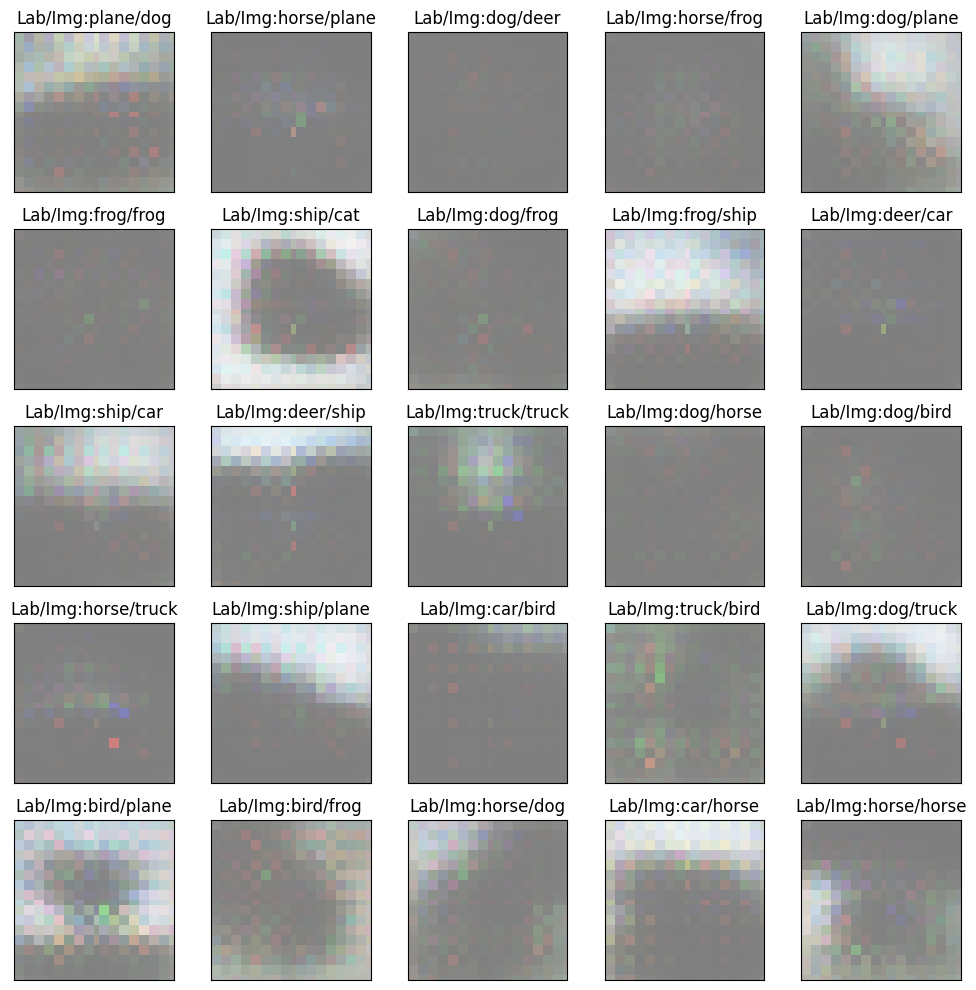

Epoch 99: 100%|██████████| 98/98 [00:07<00:00, 12.83it/s, v_num=5, elbo_train_step=1.89e+3, total_loss_train_step=3.280, label_loss_train_step=1.390, avg_diff_primary_train_step=0.111, avg_diff_secondary_train_step=0.0319, elbo_train_epoch=1.88e+3, total_loss_train_epoch=3.290, label_loss_train_epoch=1.410, avg_diff_primary_train_epoch=0.120, avg_diff_secondary_train_epoch=0.0295, elbo_val_step=2.04e+3, total_loss_val_step=3.960, label_loss_val_step=1.910, avg_diff_primary_val_step=0.299, avg_diff_secondary_val_step=0.0357, elbo_val_epoch=1.88e+3, total_loss_val_epoch=3.940, label_loss_val_epoch=2.060, avg_diff_primary_val_epoch=0.256, avg_diff_secondary_val_epoch=0.0274] 

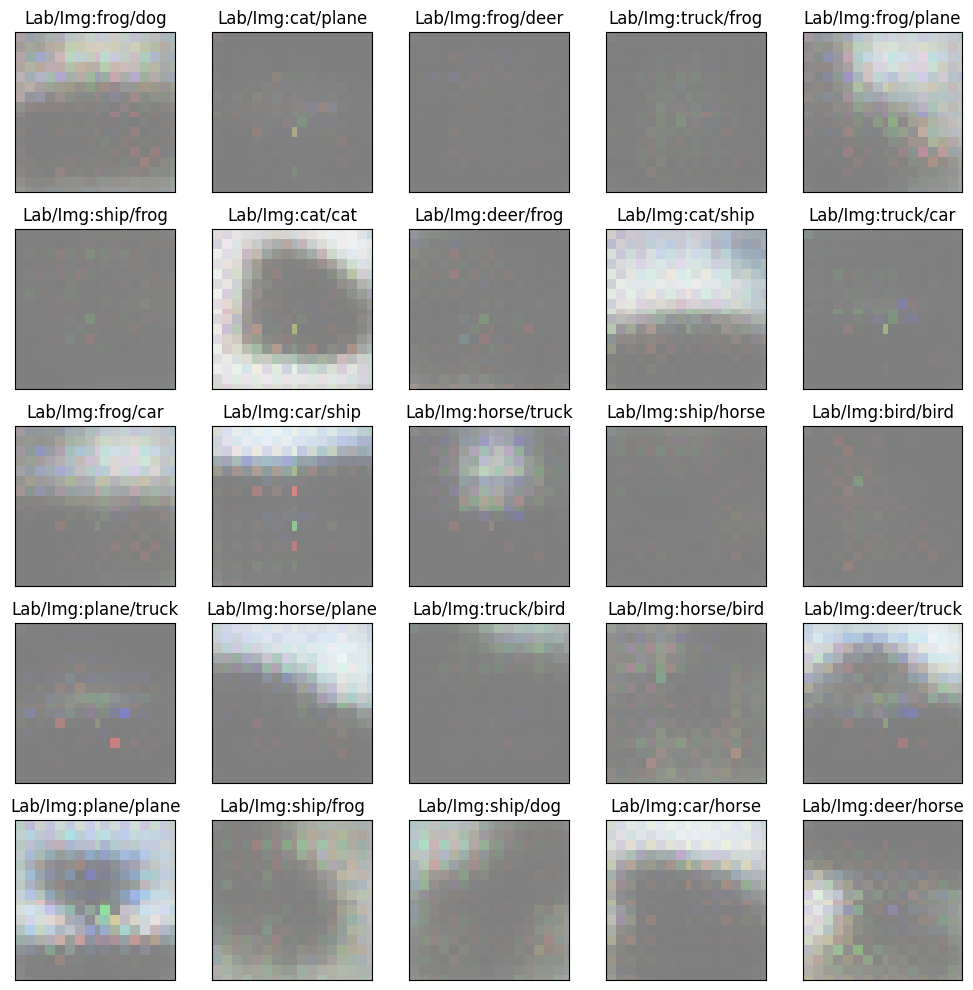

Epoch 104: 100%|██████████| 98/98 [00:07<00:00, 12.37it/s, v_num=5, elbo_train_step=1.82e+3, total_loss_train_step=3.190, label_loss_train_step=1.370, avg_diff_primary_train_step=0.103, avg_diff_secondary_train_step=0.0289, elbo_train_epoch=1.85e+3, total_loss_train_epoch=3.230, label_loss_train_epoch=1.390, avg_diff_primary_train_epoch=0.112, avg_diff_secondary_train_epoch=0.0298, elbo_val_step=2.01e+3, total_loss_val_step=3.880, label_loss_val_step=1.870, avg_diff_primary_val_step=0.257, avg_diff_secondary_val_step=0.0191, elbo_val_epoch=1.84e+3, total_loss_val_epoch=3.910, label_loss_val_epoch=2.060, avg_diff_primary_val_epoch=0.254, avg_diff_secondary_val_epoch=0.0277] 

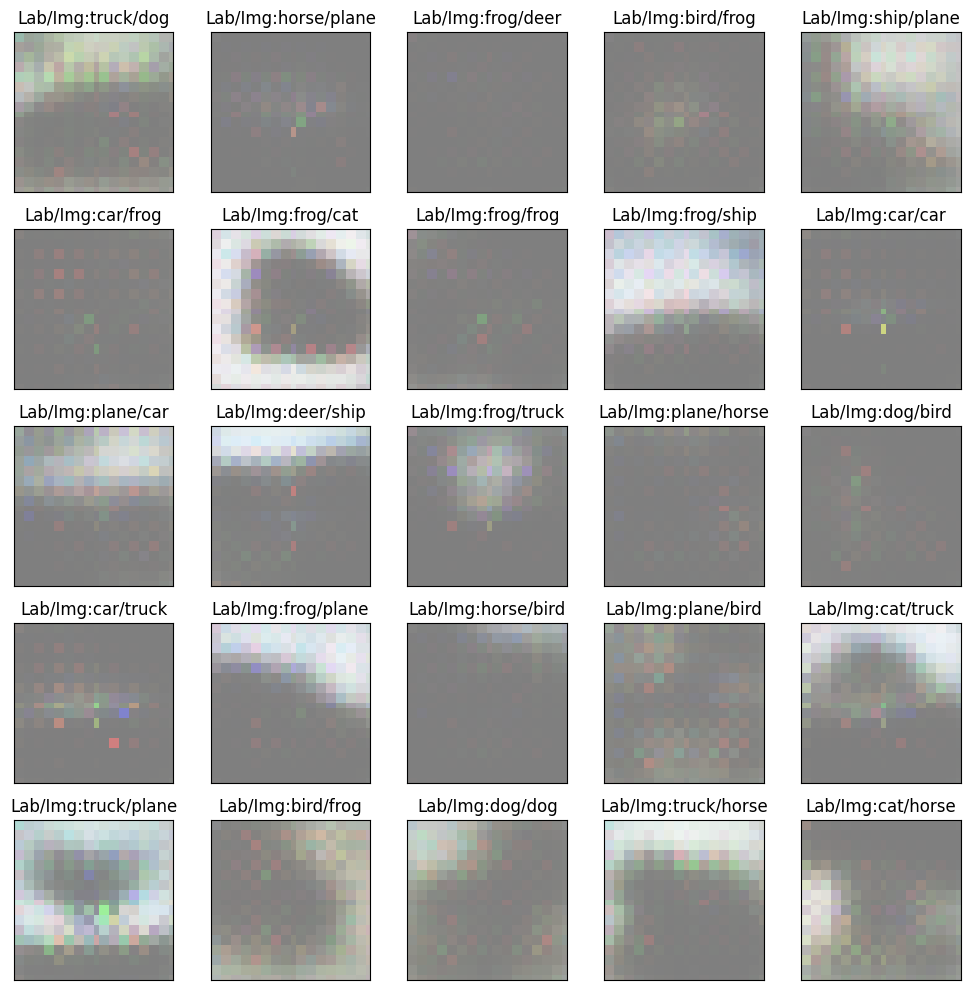

Epoch 109: 100%|██████████| 98/98 [00:08<00:00, 11.45it/s, v_num=5, elbo_train_step=1.83e+3, total_loss_train_step=3.180, label_loss_train_step=1.350, avg_diff_primary_train_step=0.104, avg_diff_secondary_train_step=0.0287, elbo_train_epoch=1.82e+3, total_loss_train_epoch=3.170, label_loss_train_epoch=1.350, avg_diff_primary_train_epoch=0.101, avg_diff_secondary_train_epoch=0.0296, elbo_val_step=1.98e+3, total_loss_val_step=3.930, label_loss_val_step=1.950, avg_diff_primary_val_step=0.262, avg_diff_secondary_val_step=0.026, elbo_val_epoch=1.81e+3, total_loss_val_epoch=3.880, label_loss_val_epoch=2.070, avg_diff_primary_val_epoch=0.255, avg_diff_secondary_val_epoch=0.0261] 

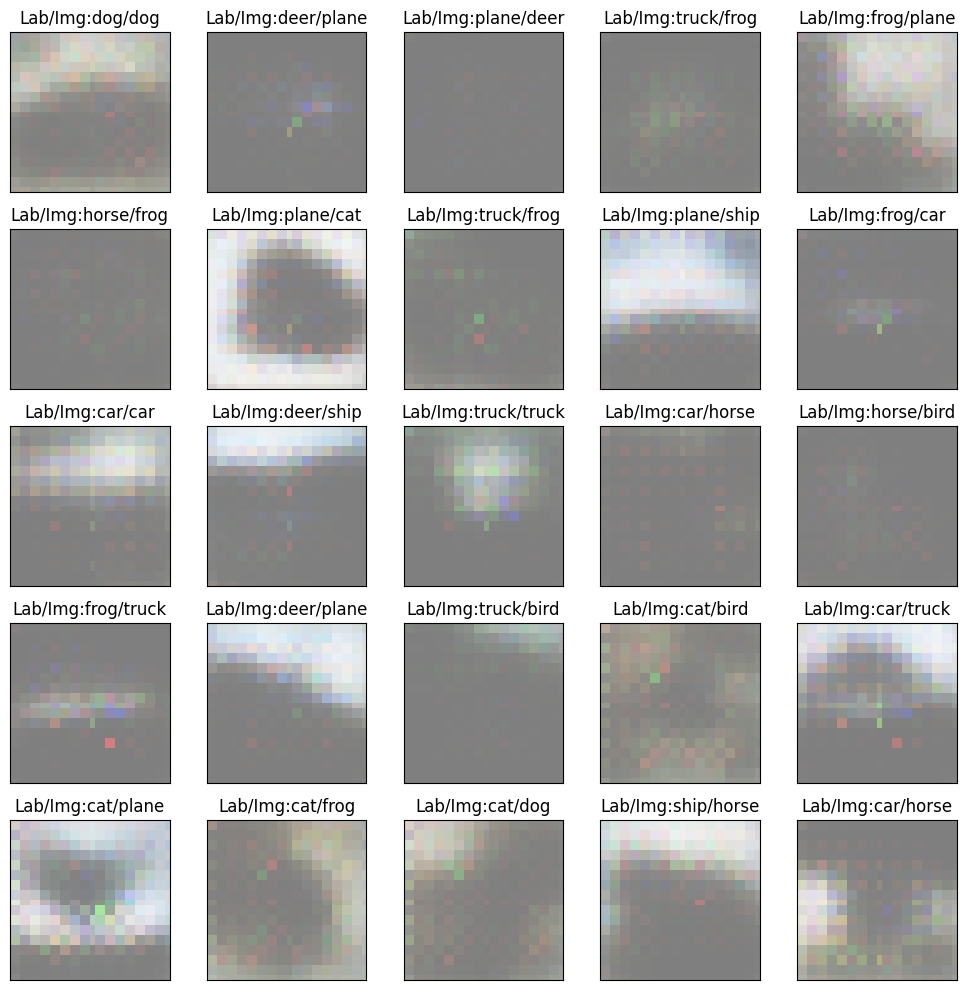

Epoch 114: 100%|██████████| 98/98 [00:07<00:00, 12.34it/s, v_num=5, elbo_train_step=1.84e+3, total_loss_train_step=3.190, label_loss_train_step=1.350, avg_diff_primary_train_step=0.0971, avg_diff_secondary_train_step=0.0307, elbo_train_epoch=1.8e+3, total_loss_train_epoch=3.130, label_loss_train_epoch=1.330, avg_diff_primary_train_epoch=0.0939, avg_diff_secondary_train_epoch=0.0294, elbo_val_step=1.96e+3, total_loss_val_step=3.930, label_loss_val_step=1.970, avg_diff_primary_val_step=0.293, avg_diff_secondary_val_step=0.0393, elbo_val_epoch=1.78e+3, total_loss_val_epoch=3.850, label_loss_val_epoch=2.070, avg_diff_primary_val_epoch=0.249, avg_diff_secondary_val_epoch=0.0277] 

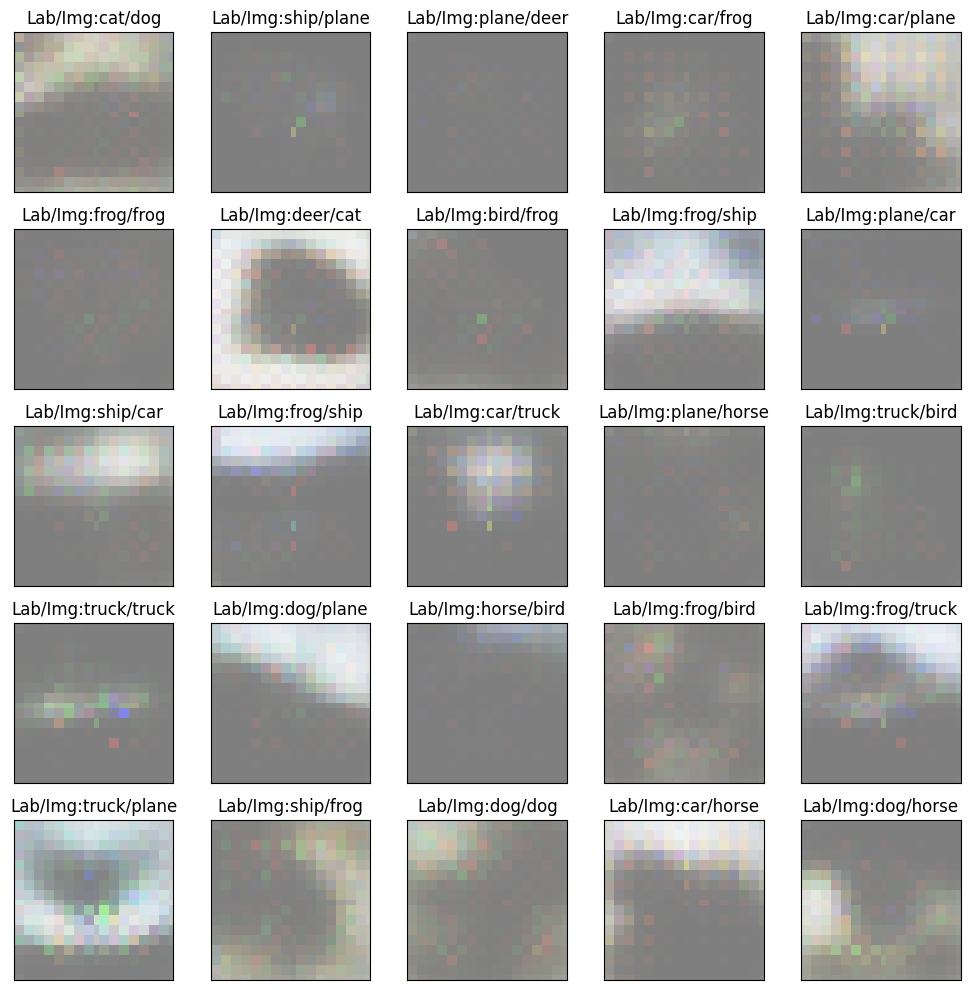

Epoch 119: 100%|██████████| 98/98 [00:07<00:00, 12.46it/s, v_num=5, elbo_train_step=1.77e+3, total_loss_train_step=3.040, label_loss_train_step=1.270, avg_diff_primary_train_step=0.0725, avg_diff_secondary_train_step=0.0267, elbo_train_epoch=1.78e+3, total_loss_train_epoch=3.090, label_loss_train_epoch=1.310, avg_diff_primary_train_epoch=0.0865, avg_diff_secondary_train_epoch=0.0285, elbo_val_step=1.95e+3, total_loss_val_step=4.020, label_loss_val_step=2.070, avg_diff_primary_val_step=0.308, avg_diff_secondary_val_step=0.0266, elbo_val_epoch=1.76e+3, total_loss_val_epoch=3.850, label_loss_val_epoch=2.090, avg_diff_primary_val_epoch=0.246, avg_diff_secondary_val_epoch=0.025]

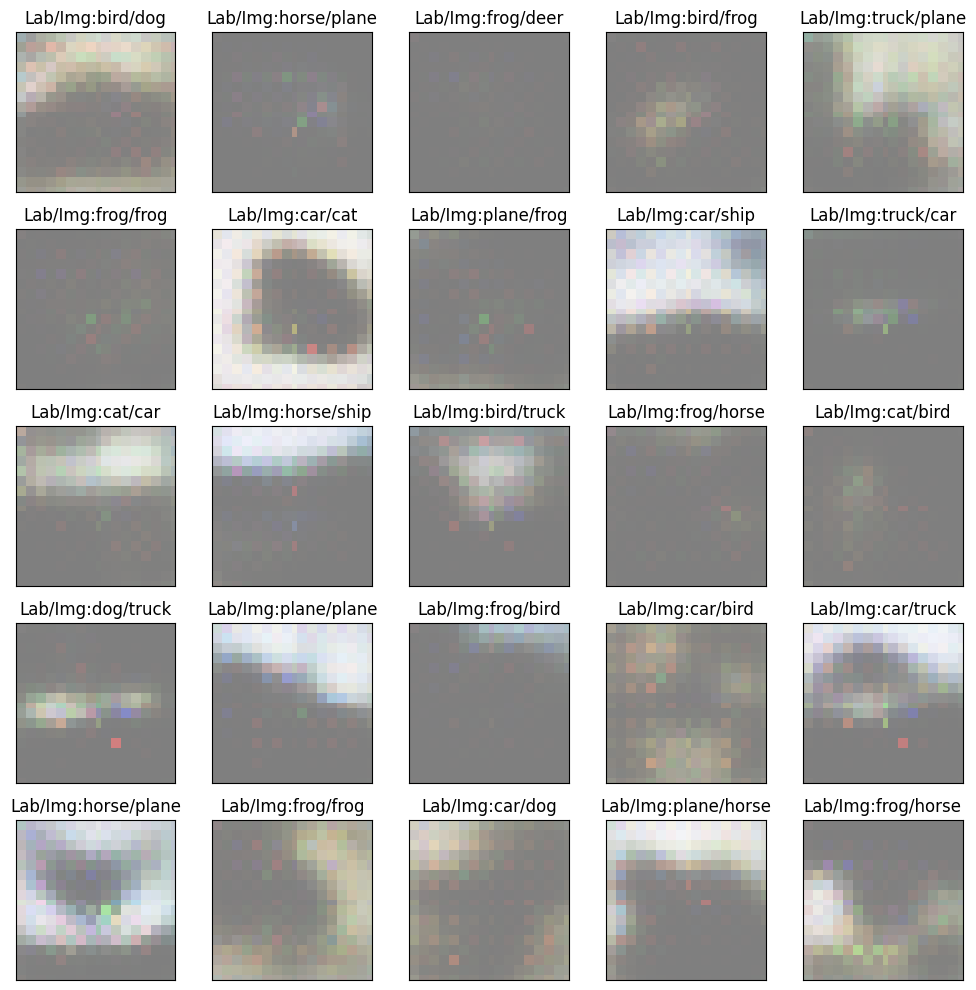

Epoch 124: 100%|██████████| 98/98 [00:07<00:00, 12.47it/s, v_num=5, elbo_train_step=1.77e+3, total_loss_train_step=3.050, label_loss_train_step=1.280, avg_diff_primary_train_step=0.0823, avg_diff_secondary_train_step=0.0278, elbo_train_epoch=1.76e+3, total_loss_train_epoch=3.060, label_loss_train_epoch=1.300, avg_diff_primary_train_epoch=0.0817, avg_diff_secondary_train_epoch=0.0283, elbo_val_step=1.93e+3, total_loss_val_step=3.990, label_loss_val_step=2.060, avg_diff_primary_val_step=0.241, avg_diff_secondary_val_step=0.021, elbo_val_epoch=1.74e+3, total_loss_val_epoch=3.830, label_loss_val_epoch=2.090, avg_diff_primary_val_epoch=0.242, avg_diff_secondary_val_epoch=0.0247]

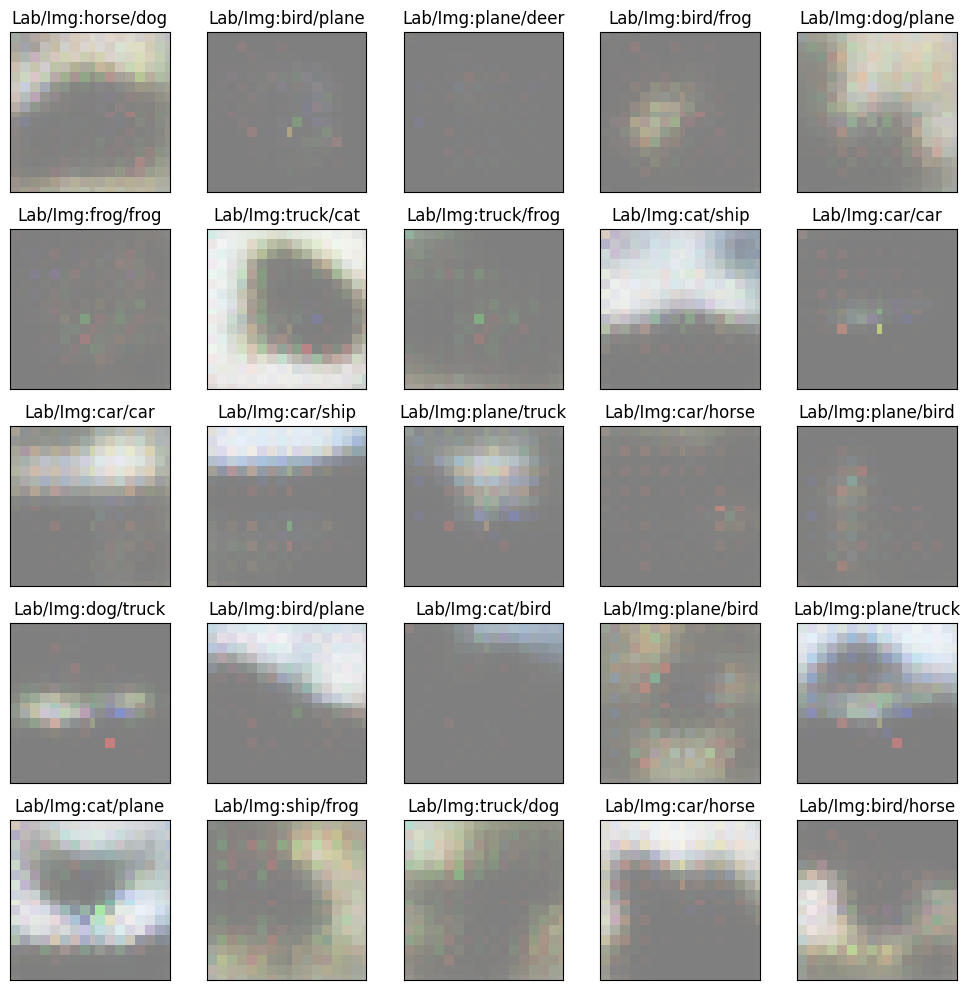

Epoch 129: 100%|██████████| 98/98 [00:07<00:00, 12.49it/s, v_num=5, elbo_train_step=1.71e+3, total_loss_train_step=2.970, label_loss_train_step=1.260, avg_diff_primary_train_step=0.0737, avg_diff_secondary_train_step=0.0276, elbo_train_epoch=1.75e+3, total_loss_train_epoch=3.040, label_loss_train_epoch=1.290, avg_diff_primary_train_epoch=0.0764, avg_diff_secondary_train_epoch=0.0278, elbo_val_step=1.92e+3, total_loss_val_step=4.160, label_loss_val_step=2.240, avg_diff_primary_val_step=0.260, avg_diff_secondary_val_step=0.0204, elbo_val_epoch=1.72e+3, total_loss_val_epoch=3.810, label_loss_val_epoch=2.090, avg_diff_primary_val_epoch=0.239, avg_diff_secondary_val_epoch=0.0257]

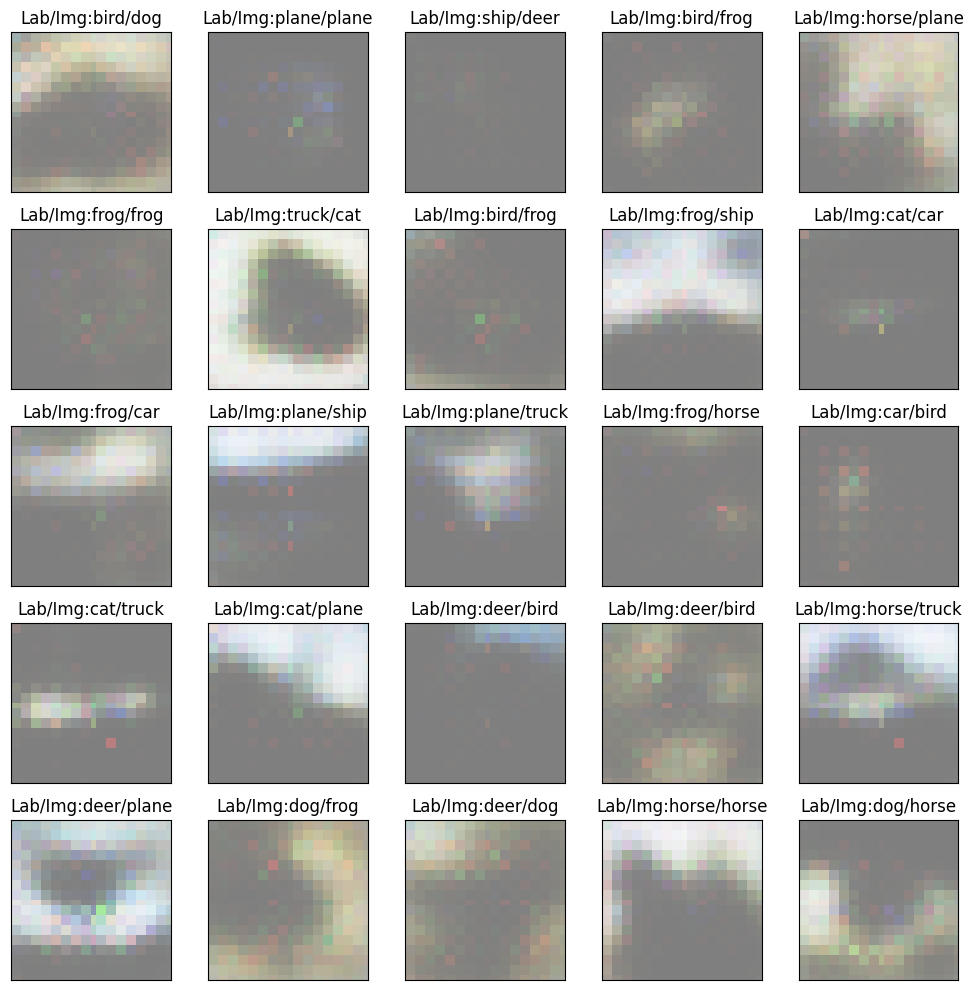

Epoch 134: 100%|██████████| 98/98 [00:07<00:00, 12.62it/s, v_num=5, elbo_train_step=1.69e+3, total_loss_train_step=2.910, label_loss_train_step=1.230, avg_diff_primary_train_step=0.0564, avg_diff_secondary_train_step=0.0272, elbo_train_epoch=1.74e+3, total_loss_train_epoch=3.010, label_loss_train_epoch=1.270, avg_diff_primary_train_epoch=0.0698, avg_diff_secondary_train_epoch=0.027, elbo_val_step=1.91e+3, total_loss_val_step=3.850, label_loss_val_step=1.940, avg_diff_primary_val_step=0.244, avg_diff_secondary_val_step=0.0202, elbo_val_epoch=1.71e+3, total_loss_val_epoch=3.830, label_loss_val_epoch=2.120, avg_diff_primary_val_epoch=0.244, avg_diff_secondary_val_epoch=0.0252] 

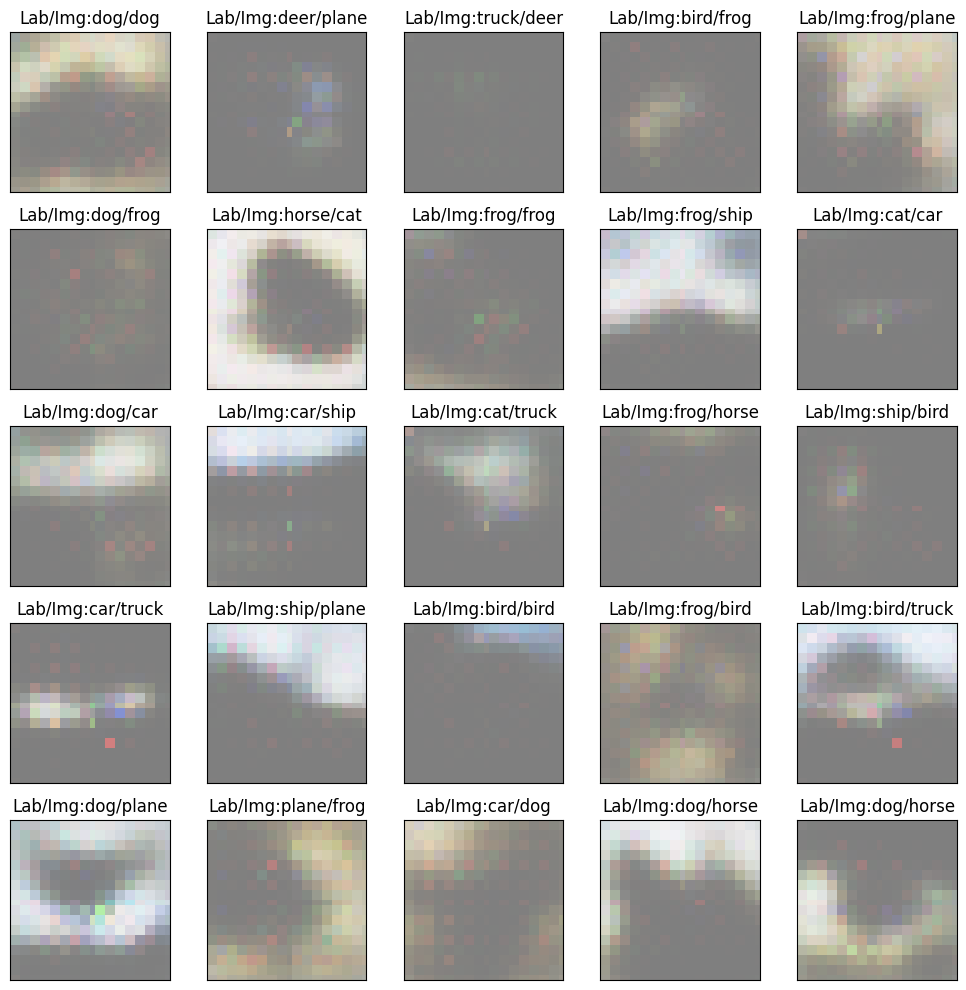

Epoch 139: 100%|██████████| 98/98 [00:07<00:00, 12.39it/s, v_num=5, elbo_train_step=1.81e+3, total_loss_train_step=3.070, label_loss_train_step=1.260, avg_diff_primary_train_step=0.0665, avg_diff_secondary_train_step=0.0286, elbo_train_epoch=1.73e+3, total_loss_train_epoch=2.990, label_loss_train_epoch=1.260, avg_diff_primary_train_epoch=0.066, avg_diff_secondary_train_epoch=0.0261, elbo_val_step=1.89e+3, total_loss_val_step=3.360, label_loss_val_step=1.470, avg_diff_primary_val_step=0.0851, avg_diff_secondary_val_step=0.0258, elbo_val_epoch=1.69e+3, total_loss_val_epoch=3.810, label_loss_val_epoch=2.120, avg_diff_primary_val_epoch=0.241, avg_diff_secondary_val_epoch=0.0254] 

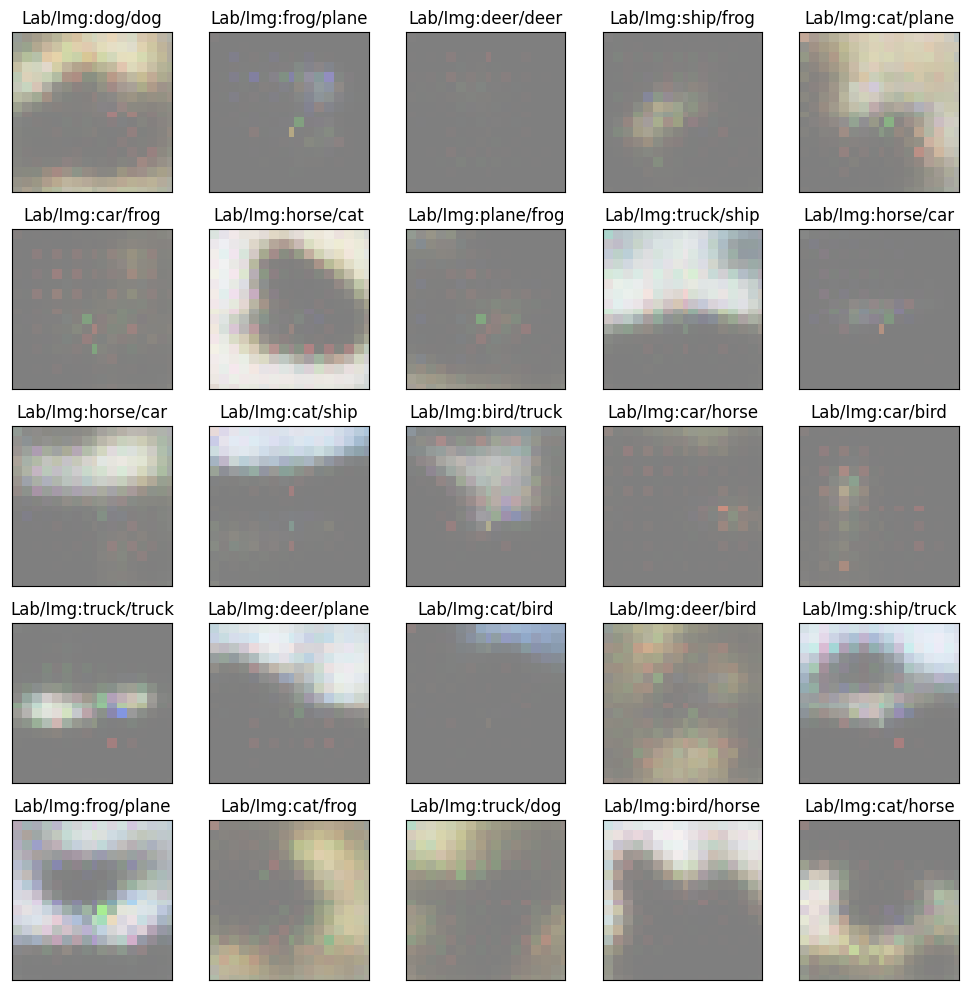

Epoch 144: 100%|██████████| 98/98 [00:07<00:00, 12.62it/s, v_num=5, elbo_train_step=1.72e+3, total_loss_train_step=2.980, label_loss_train_step=1.270, avg_diff_primary_train_step=0.0673, avg_diff_secondary_train_step=0.0258, elbo_train_epoch=1.72e+3, total_loss_train_epoch=2.970, label_loss_train_epoch=1.250, avg_diff_primary_train_epoch=0.0629, avg_diff_secondary_train_epoch=0.0256, elbo_val_step=1.89e+3, total_loss_val_step=3.950, label_loss_val_step=2.060, avg_diff_primary_val_step=0.267, avg_diff_secondary_val_step=0.0272, elbo_val_epoch=1.68e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.100, avg_diff_primary_val_epoch=0.239, avg_diff_secondary_val_epoch=0.0261]

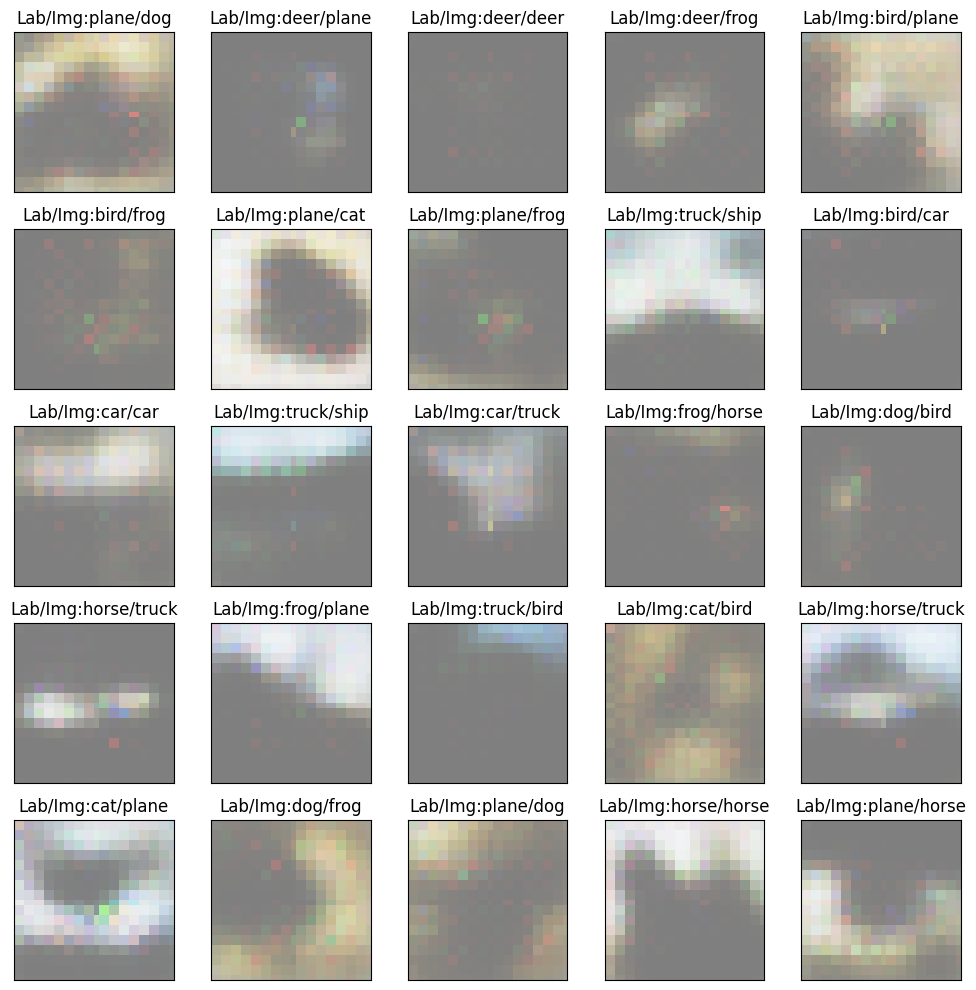

Epoch 149: 100%|██████████| 98/98 [00:07<00:00, 12.51it/s, v_num=5, elbo_train_step=1.8e+3, total_loss_train_step=3.040, label_loss_train_step=1.240, avg_diff_primary_train_step=0.0554, avg_diff_secondary_train_step=0.0225, elbo_train_epoch=1.71e+3, total_loss_train_epoch=2.950, label_loss_train_epoch=1.230, avg_diff_primary_train_epoch=0.0576, avg_diff_secondary_train_epoch=0.0249, elbo_val_step=1.87e+3, total_loss_val_step=3.740, label_loss_val_step=1.870, avg_diff_primary_val_step=0.203, avg_diff_secondary_val_step=0.0274, elbo_val_epoch=1.68e+3, total_loss_val_epoch=3.800, label_loss_val_epoch=2.130, avg_diff_primary_val_epoch=0.240, avg_diff_secondary_val_epoch=0.0244] 

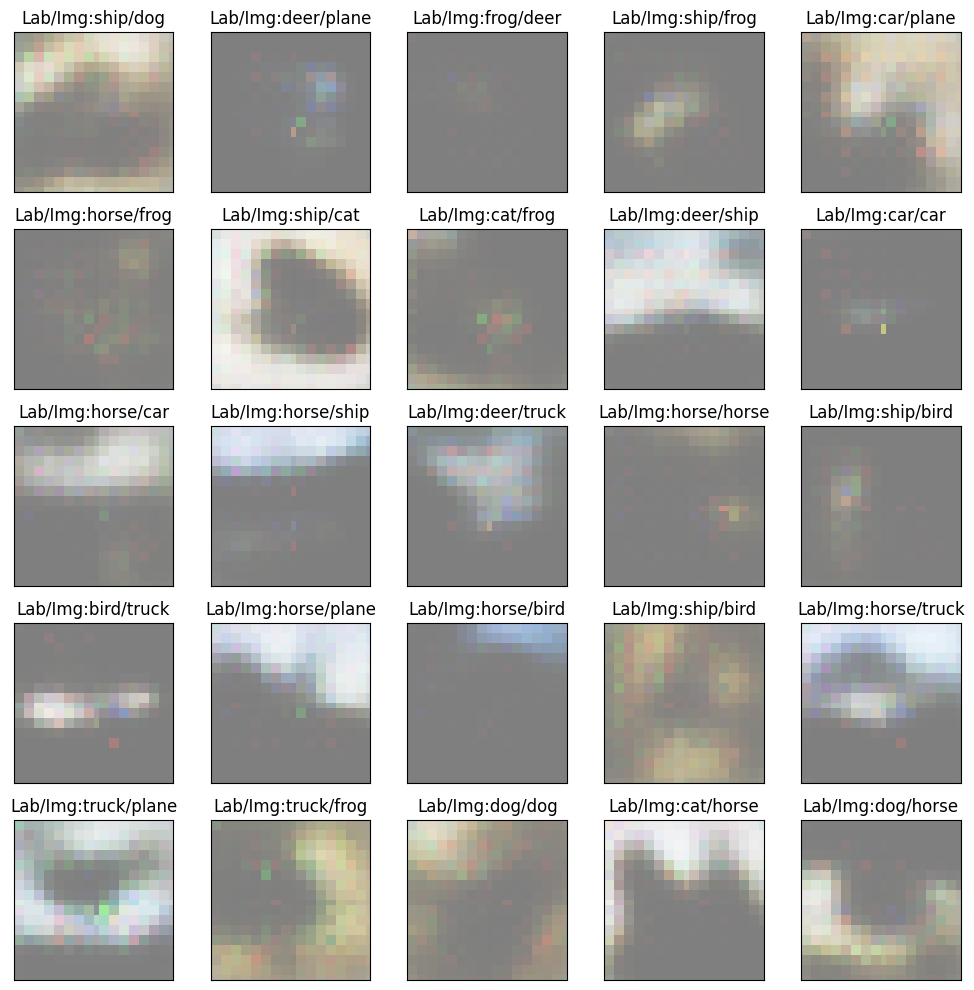

Epoch 154: 100%|██████████| 98/98 [00:07<00:00, 12.38it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.850, label_loss_train_step=1.210, avg_diff_primary_train_step=0.0504, avg_diff_secondary_train_step=0.0243, elbo_train_epoch=1.7e+3, total_loss_train_epoch=2.930, label_loss_train_epoch=1.220, avg_diff_primary_train_epoch=0.0543, avg_diff_secondary_train_epoch=0.0244, elbo_val_step=1.86e+3, total_loss_val_step=4.000, label_loss_val_step=2.140, avg_diff_primary_val_step=0.256, avg_diff_secondary_val_step=0.0255, elbo_val_epoch=1.67e+3, total_loss_val_epoch=3.790, label_loss_val_epoch=2.120, avg_diff_primary_val_epoch=0.238, avg_diff_secondary_val_epoch=0.0244] 

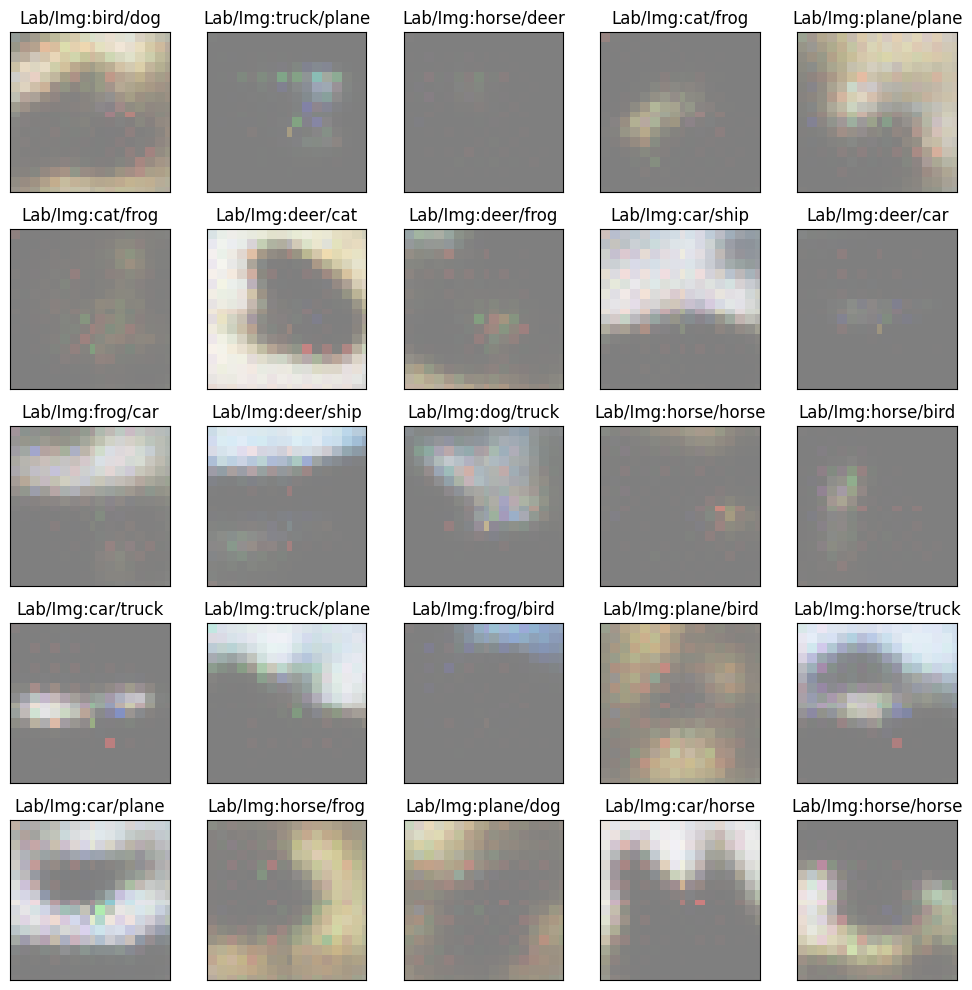

Epoch 159: 100%|██████████| 98/98 [00:07<00:00, 12.60it/s, v_num=5, elbo_train_step=1.71e+3, total_loss_train_step=2.910, label_loss_train_step=1.200, avg_diff_primary_train_step=0.0443, avg_diff_secondary_train_step=0.0215, elbo_train_epoch=1.7e+3, total_loss_train_epoch=2.920, label_loss_train_epoch=1.220, avg_diff_primary_train_epoch=0.0532, avg_diff_secondary_train_epoch=0.0235, elbo_val_step=1.86e+3, total_loss_val_step=4.150, label_loss_val_step=2.300, avg_diff_primary_val_step=0.282, avg_diff_secondary_val_step=0.0224, elbo_val_epoch=1.66e+3, total_loss_val_epoch=3.800, label_loss_val_epoch=2.140, avg_diff_primary_val_epoch=0.237, avg_diff_secondary_val_epoch=0.0243]

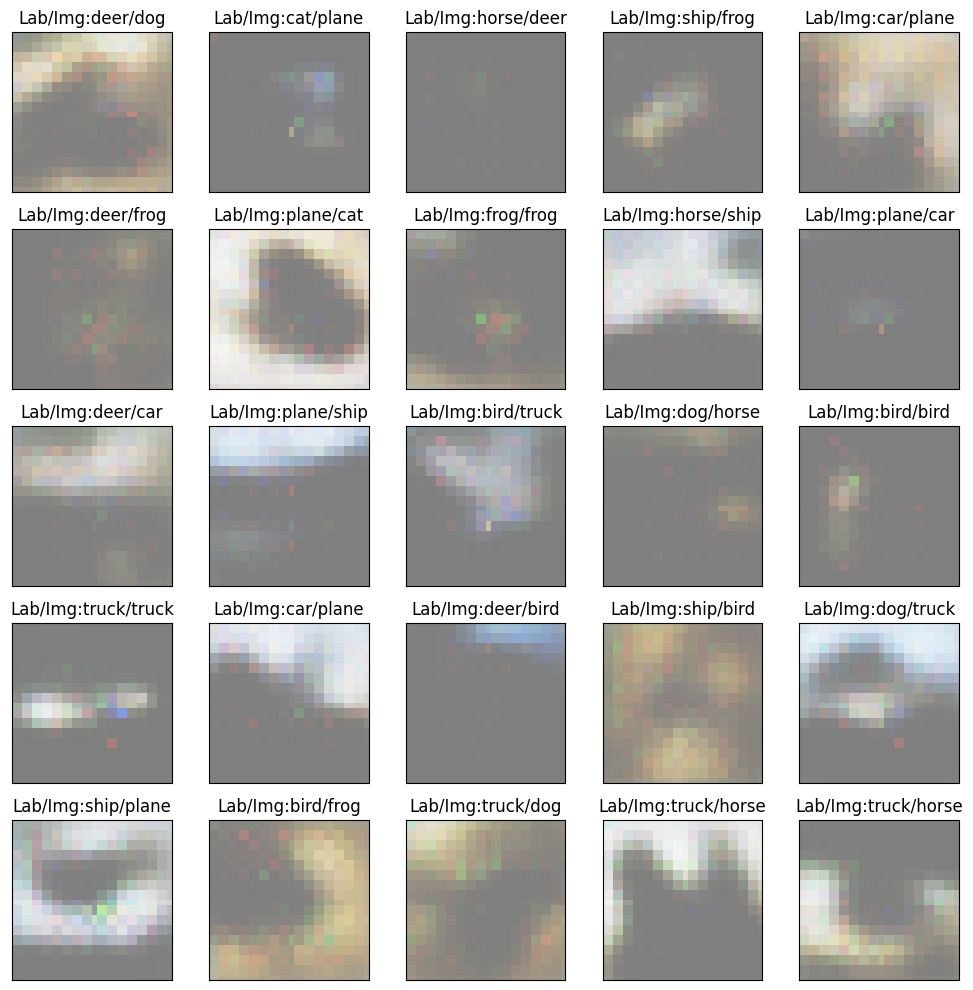

Epoch 164: 100%|██████████| 98/98 [00:07<00:00, 12.53it/s, v_num=5, elbo_train_step=1.69e+3, total_loss_train_step=2.940, label_loss_train_step=1.250, avg_diff_primary_train_step=0.0631, avg_diff_secondary_train_step=0.0252, elbo_train_epoch=1.69e+3, total_loss_train_epoch=2.900, label_loss_train_epoch=1.210, avg_diff_primary_train_epoch=0.0498, avg_diff_secondary_train_epoch=0.0228, elbo_val_step=1.85e+3, total_loss_val_step=3.760, label_loss_val_step=1.910, avg_diff_primary_val_step=0.174, avg_diff_secondary_val_step=0.0195, elbo_val_epoch=1.65e+3, total_loss_val_epoch=3.810, label_loss_val_epoch=2.160, avg_diff_primary_val_epoch=0.239, avg_diff_secondary_val_epoch=0.0233]

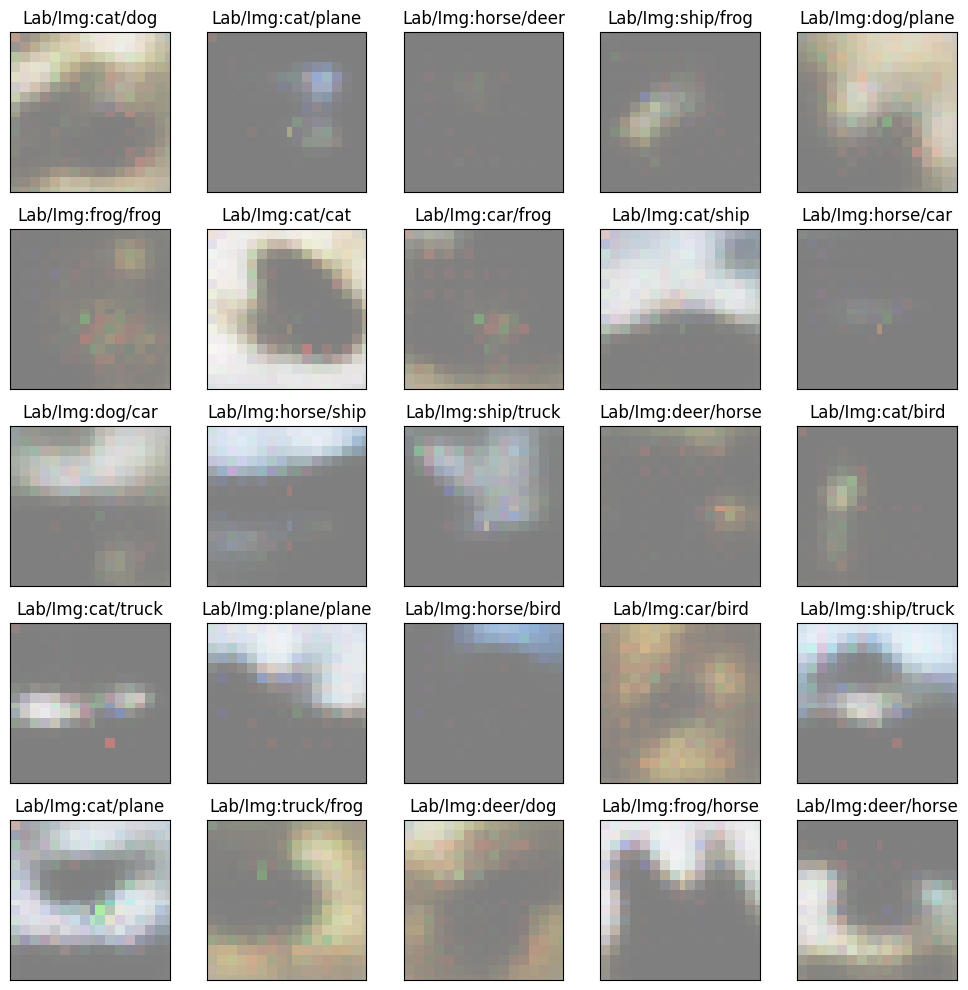

Epoch 169: 100%|██████████| 98/98 [00:07<00:00, 12.32it/s, v_num=5, elbo_train_step=1.66e+3, total_loss_train_step=2.840, label_loss_train_step=1.180, avg_diff_primary_train_step=0.0398, avg_diff_secondary_train_step=0.020, elbo_train_epoch=1.69e+3, total_loss_train_epoch=2.890, label_loss_train_epoch=1.200, avg_diff_primary_train_epoch=0.0464, avg_diff_secondary_train_epoch=0.022, elbo_val_step=1.84e+3, total_loss_val_step=4.120, label_loss_val_step=2.280, avg_diff_primary_val_step=0.280, avg_diff_secondary_val_step=0.0185, elbo_val_epoch=1.65e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.140, avg_diff_primary_val_epoch=0.234, avg_diff_secondary_val_epoch=0.0216]  

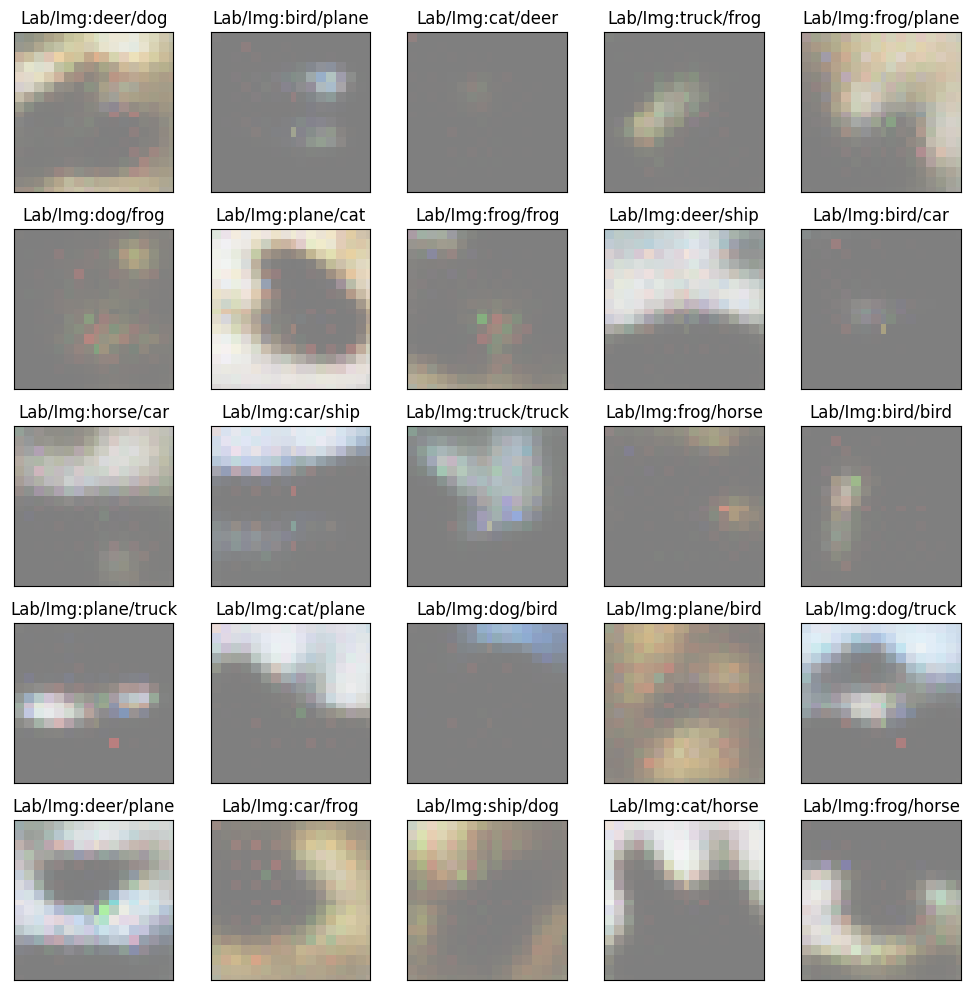

Epoch 174: 100%|██████████| 98/98 [00:07<00:00, 12.43it/s, v_num=5, elbo_train_step=1.63e+3, total_loss_train_step=2.820, label_loss_train_step=1.190, avg_diff_primary_train_step=0.0405, avg_diff_secondary_train_step=0.0214, elbo_train_epoch=1.68e+3, total_loss_train_epoch=2.880, label_loss_train_epoch=1.200, avg_diff_primary_train_epoch=0.0462, avg_diff_secondary_train_epoch=0.0217, elbo_val_step=1.83e+3, total_loss_val_step=3.760, label_loss_val_step=1.920, avg_diff_primary_val_step=0.220, avg_diff_secondary_val_step=0.0179, elbo_val_epoch=1.64e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.130, avg_diff_primary_val_epoch=0.234, avg_diff_secondary_val_epoch=0.0215]

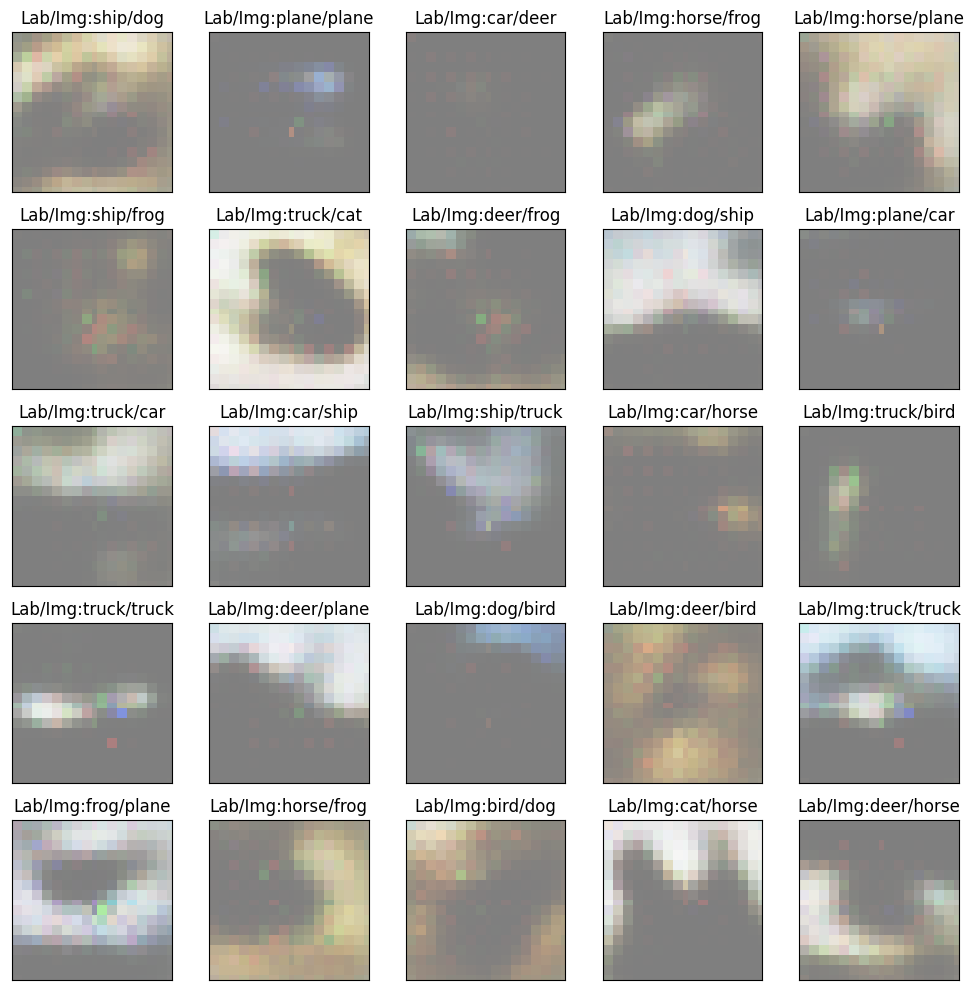

Epoch 179: 100%|██████████| 98/98 [00:07<00:00, 12.61it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.830, label_loss_train_step=1.190, avg_diff_primary_train_step=0.0392, avg_diff_secondary_train_step=0.0202, elbo_train_epoch=1.68e+3, total_loss_train_epoch=2.870, label_loss_train_epoch=1.200, avg_diff_primary_train_epoch=0.043, avg_diff_secondary_train_epoch=0.0211, elbo_val_step=1.83e+3, total_loss_val_step=3.690, label_loss_val_step=1.860, avg_diff_primary_val_step=0.259, avg_diff_secondary_val_step=0.0263, elbo_val_epoch=1.63e+3, total_loss_val_epoch=3.790, label_loss_val_epoch=2.150, avg_diff_primary_val_epoch=0.235, avg_diff_secondary_val_epoch=0.0212] 

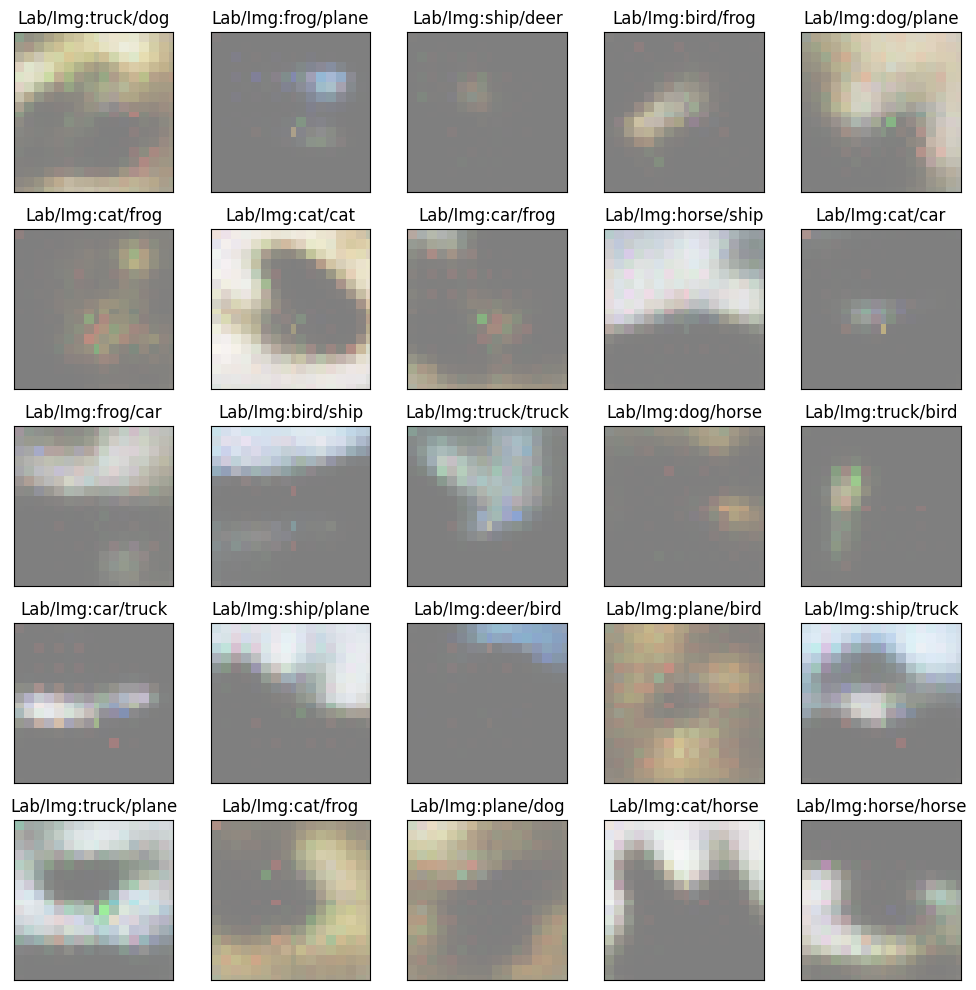

Epoch 184: 100%|██████████| 98/98 [00:07<00:00, 12.55it/s, v_num=5, elbo_train_step=1.67e+3, total_loss_train_step=2.890, label_loss_train_step=1.220, avg_diff_primary_train_step=0.0484, avg_diff_secondary_train_step=0.0204, elbo_train_epoch=1.67e+3, total_loss_train_epoch=2.860, label_loss_train_epoch=1.190, avg_diff_primary_train_epoch=0.0414, avg_diff_secondary_train_epoch=0.0205, elbo_val_step=1.83e+3, total_loss_val_step=3.660, label_loss_val_step=1.840, avg_diff_primary_val_step=0.154, avg_diff_secondary_val_step=0.022, elbo_val_epoch=1.63e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.130, avg_diff_primary_val_epoch=0.232, avg_diff_secondary_val_epoch=0.0206]

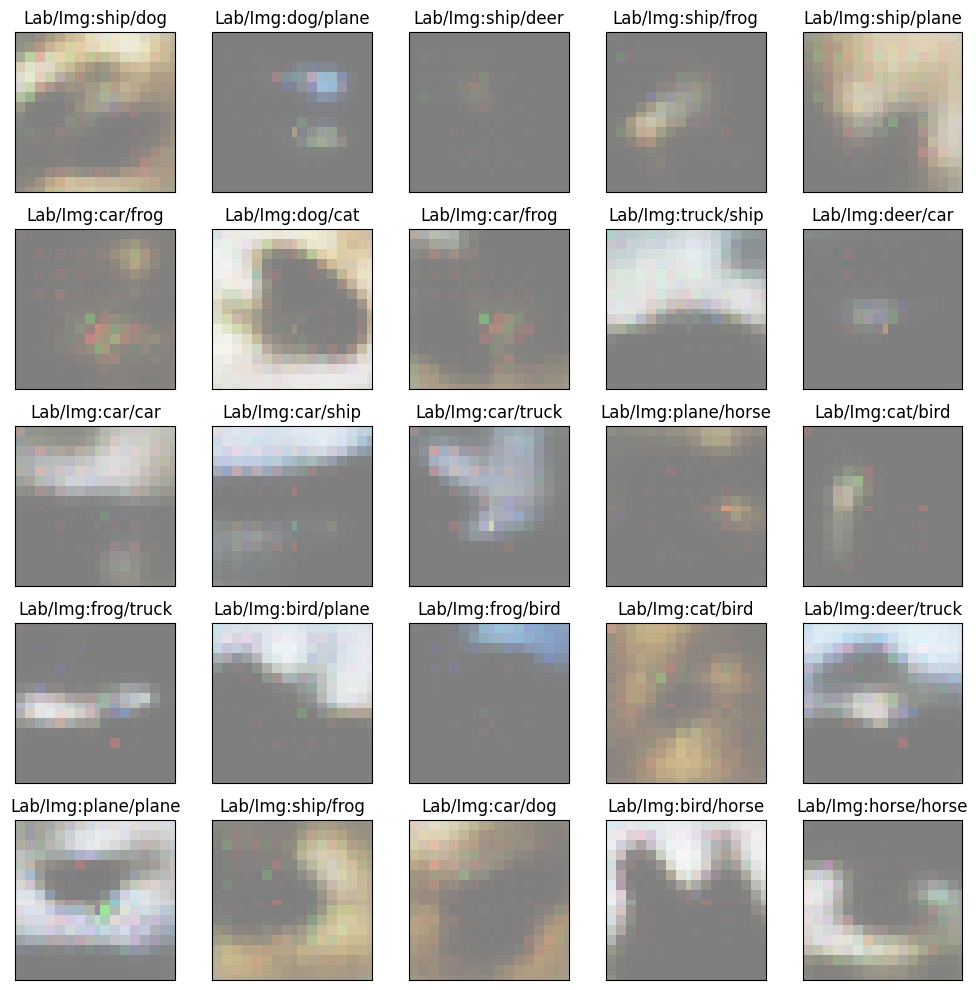

Epoch 189: 100%|██████████| 98/98 [00:07<00:00, 12.67it/s, v_num=5, elbo_train_step=1.66e+3, total_loss_train_step=2.840, label_loss_train_step=1.180, avg_diff_primary_train_step=0.0394, avg_diff_secondary_train_step=0.0197, elbo_train_epoch=1.67e+3, total_loss_train_epoch=2.850, label_loss_train_epoch=1.190, avg_diff_primary_train_epoch=0.0395, avg_diff_secondary_train_epoch=0.0199, elbo_val_step=1.83e+3, total_loss_val_step=3.830, label_loss_val_step=2.000, avg_diff_primary_val_step=0.249, avg_diff_secondary_val_step=0.0159, elbo_val_epoch=1.63e+3, total_loss_val_epoch=3.800, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.236, avg_diff_secondary_val_epoch=0.0196]

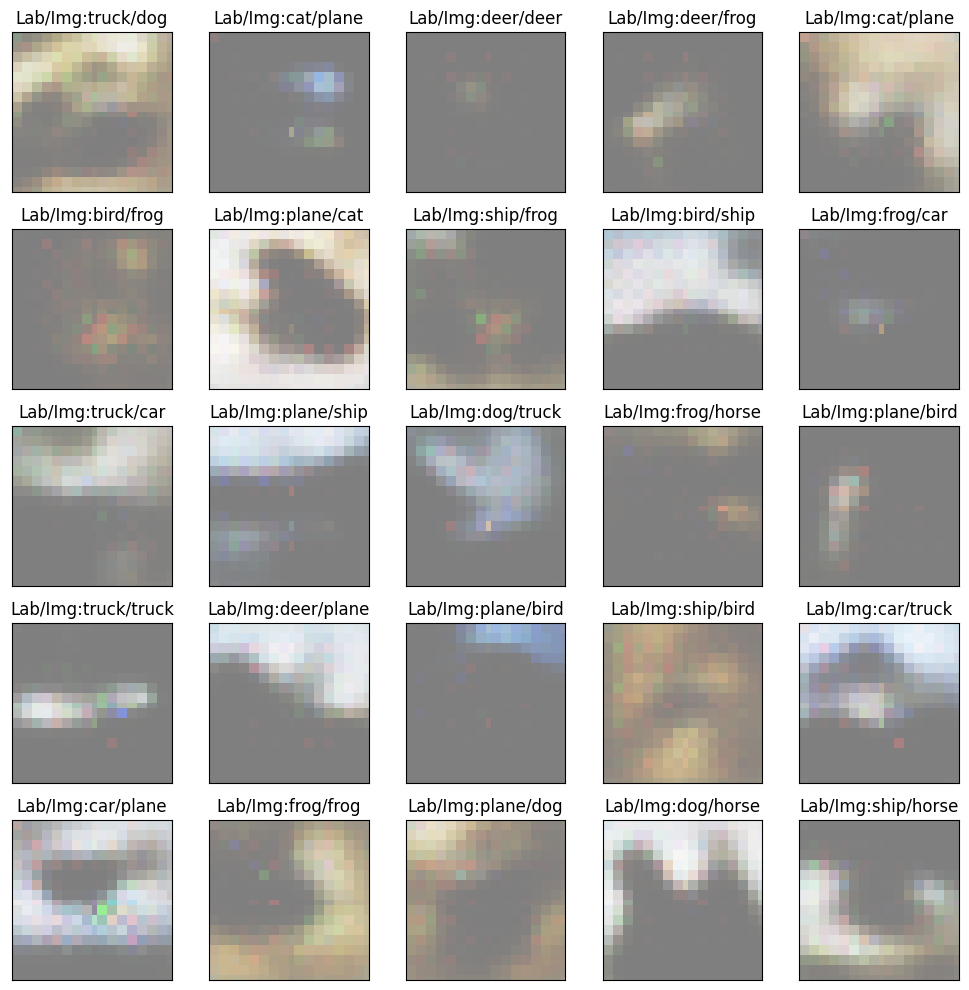

Epoch 194: 100%|██████████| 98/98 [00:07<00:00, 12.33it/s, v_num=5, elbo_train_step=1.68e+3, total_loss_train_step=2.880, label_loss_train_step=1.200, avg_diff_primary_train_step=0.0449, avg_diff_secondary_train_step=0.0212, elbo_train_epoch=1.66e+3, total_loss_train_epoch=2.850, label_loss_train_epoch=1.190, avg_diff_primary_train_epoch=0.0383, avg_diff_secondary_train_epoch=0.0195, elbo_val_step=1.82e+3, total_loss_val_step=3.690, label_loss_val_step=1.870, avg_diff_primary_val_step=0.182, avg_diff_secondary_val_step=0.0191, elbo_val_epoch=1.62e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.150, avg_diff_primary_val_epoch=0.234, avg_diff_secondary_val_epoch=0.0206]

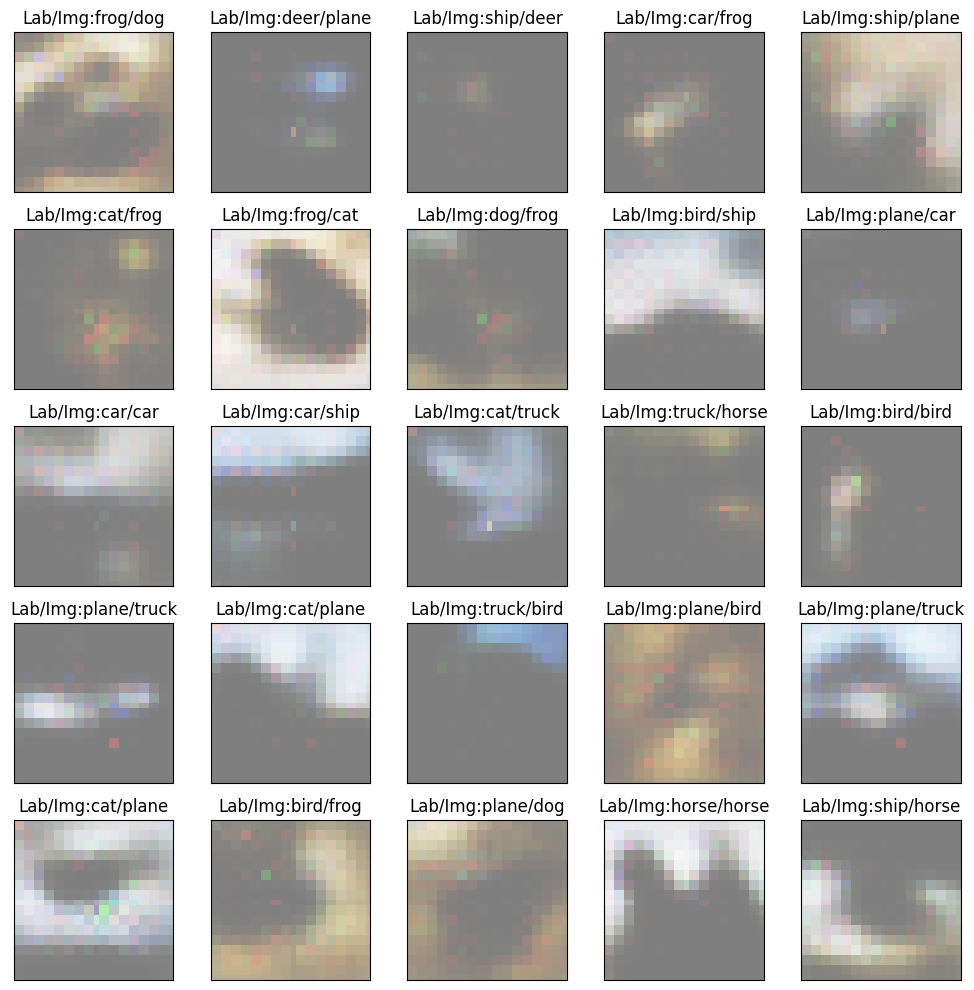

Epoch 199: 100%|██████████| 98/98 [00:07<00:00, 12.47it/s, v_num=5, elbo_train_step=1.63e+3, total_loss_train_step=2.830, label_loss_train_step=1.190, avg_diff_primary_train_step=0.0371, avg_diff_secondary_train_step=0.0174, elbo_train_epoch=1.66e+3, total_loss_train_epoch=2.840, label_loss_train_epoch=1.180, avg_diff_primary_train_epoch=0.0361, avg_diff_secondary_train_epoch=0.019, elbo_val_step=1.81e+3, total_loss_val_step=3.720, label_loss_val_step=1.910, avg_diff_primary_val_step=0.197, avg_diff_secondary_val_step=0.0151, elbo_val_epoch=1.62e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.160, avg_diff_primary_val_epoch=0.236, avg_diff_secondary_val_epoch=0.0192] 

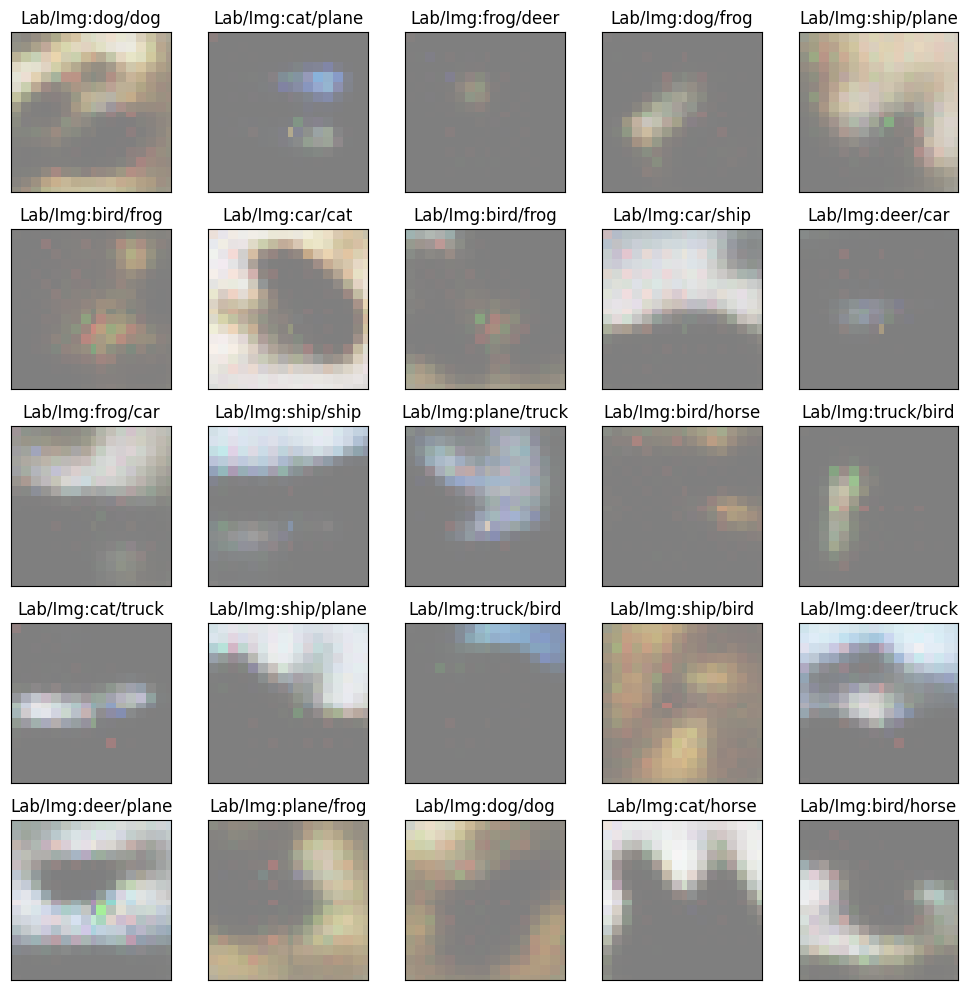

Epoch 204: 100%|██████████| 98/98 [00:07<00:00, 12.26it/s, v_num=5, elbo_train_step=1.71e+3, total_loss_train_step=2.890, label_loss_train_step=1.180, avg_diff_primary_train_step=0.0349, avg_diff_secondary_train_step=0.0176, elbo_train_epoch=1.65e+3, total_loss_train_epoch=2.840, label_loss_train_epoch=1.180, avg_diff_primary_train_epoch=0.0371, avg_diff_secondary_train_epoch=0.0188, elbo_val_step=1.81e+3, total_loss_val_step=3.820, label_loss_val_step=2.010, avg_diff_primary_val_step=0.192, avg_diff_secondary_val_step=0.0255, elbo_val_epoch=1.61e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.150, avg_diff_primary_val_epoch=0.236, avg_diff_secondary_val_epoch=0.0189]

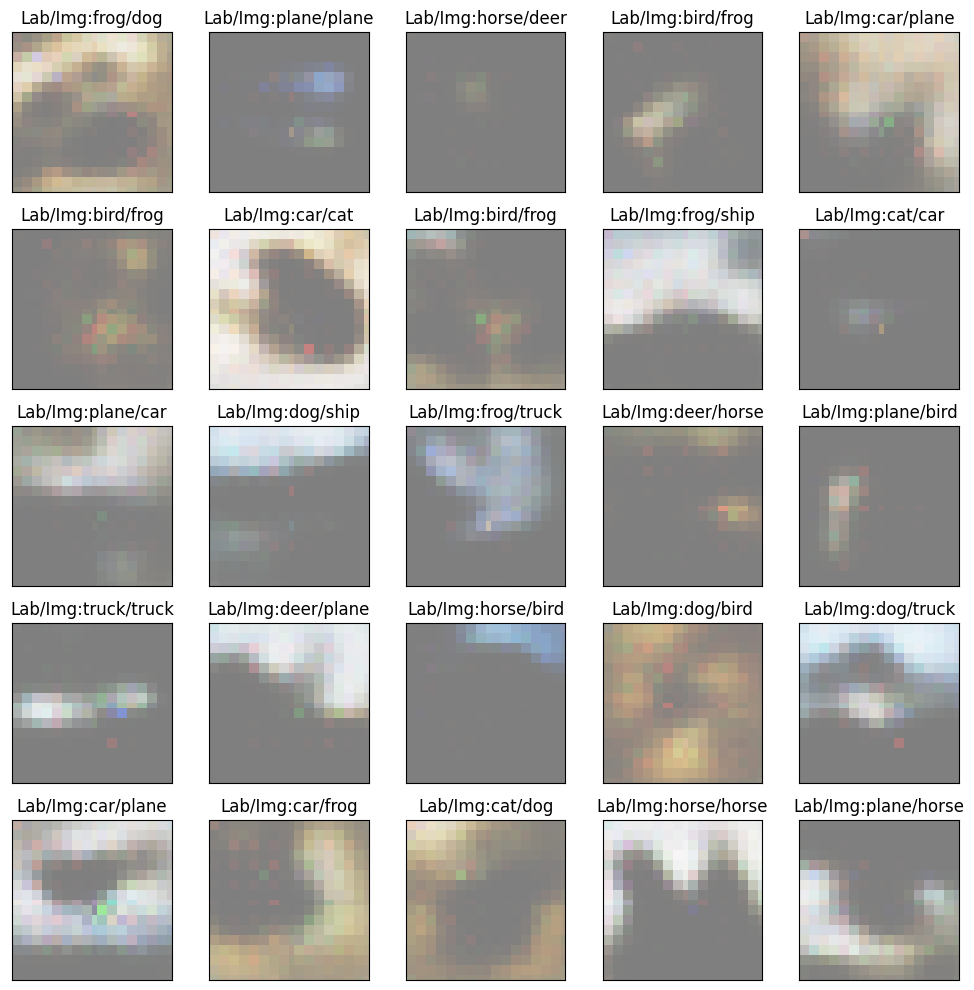

Epoch 209: 100%|██████████| 98/98 [00:07<00:00, 12.44it/s, v_num=5, elbo_train_step=1.71e+3, total_loss_train_step=2.880, label_loss_train_step=1.180, avg_diff_primary_train_step=0.032, avg_diff_secondary_train_step=0.0178, elbo_train_epoch=1.65e+3, total_loss_train_epoch=2.830, label_loss_train_epoch=1.180, avg_diff_primary_train_epoch=0.0345, avg_diff_secondary_train_epoch=0.0183, elbo_val_step=1.81e+3, total_loss_val_step=3.480, label_loss_val_step=1.670, avg_diff_primary_val_step=0.132, avg_diff_secondary_val_step=0.0165, elbo_val_epoch=1.61e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.160, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0195] 

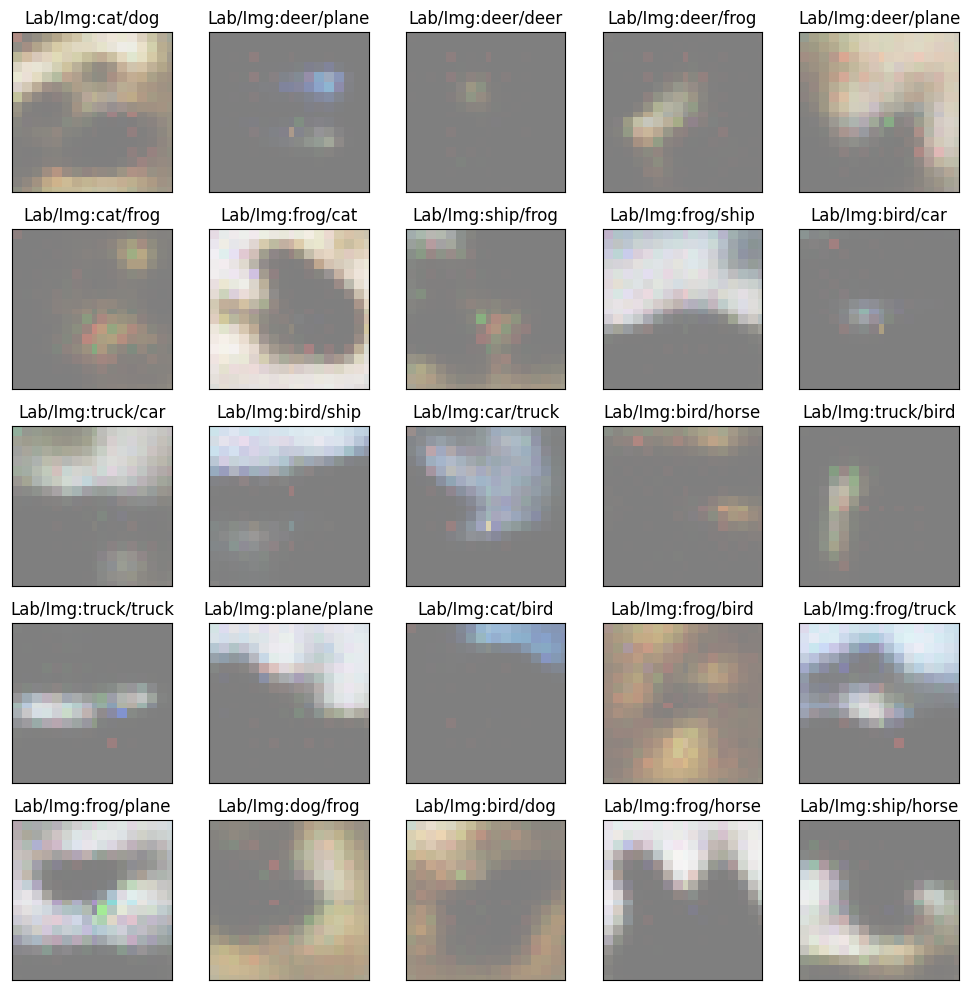

Epoch 214: 100%|██████████| 98/98 [00:07<00:00, 12.63it/s, v_num=5, elbo_train_step=1.7e+3, total_loss_train_step=2.890, label_loss_train_step=1.190, avg_diff_primary_train_step=0.0349, avg_diff_secondary_train_step=0.0181, elbo_train_epoch=1.65e+3, total_loss_train_epoch=2.820, label_loss_train_epoch=1.170, avg_diff_primary_train_epoch=0.032, avg_diff_secondary_train_epoch=0.0176, elbo_val_step=1.81e+3, total_loss_val_step=3.770, label_loss_val_step=1.970, avg_diff_primary_val_step=0.172, avg_diff_secondary_val_step=0.0205, elbo_val_epoch=1.61e+3, total_loss_val_epoch=3.790, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.232, avg_diff_secondary_val_epoch=0.0192]  

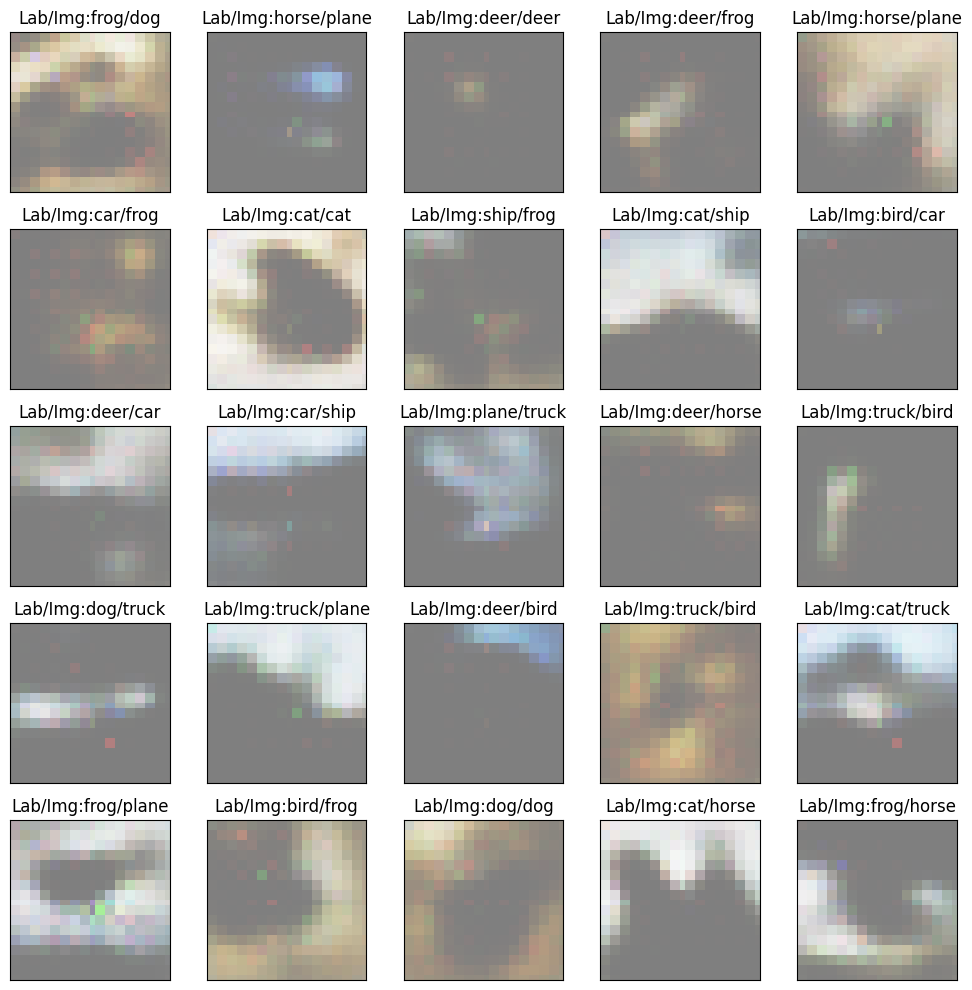

Epoch 219: 100%|██████████| 98/98 [00:07<00:00, 12.41it/s, v_num=5, elbo_train_step=1.69e+3, total_loss_train_step=2.850, label_loss_train_step=1.160, avg_diff_primary_train_step=0.0318, avg_diff_secondary_train_step=0.0181, elbo_train_epoch=1.64e+3, total_loss_train_epoch=2.810, label_loss_train_epoch=1.170, avg_diff_primary_train_epoch=0.0319, avg_diff_secondary_train_epoch=0.0174, elbo_val_step=1.8e+3, total_loss_val_step=3.670, label_loss_val_step=1.870, avg_diff_primary_val_step=0.189, avg_diff_secondary_val_step=0.0188, elbo_val_epoch=1.6e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.150, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0194]

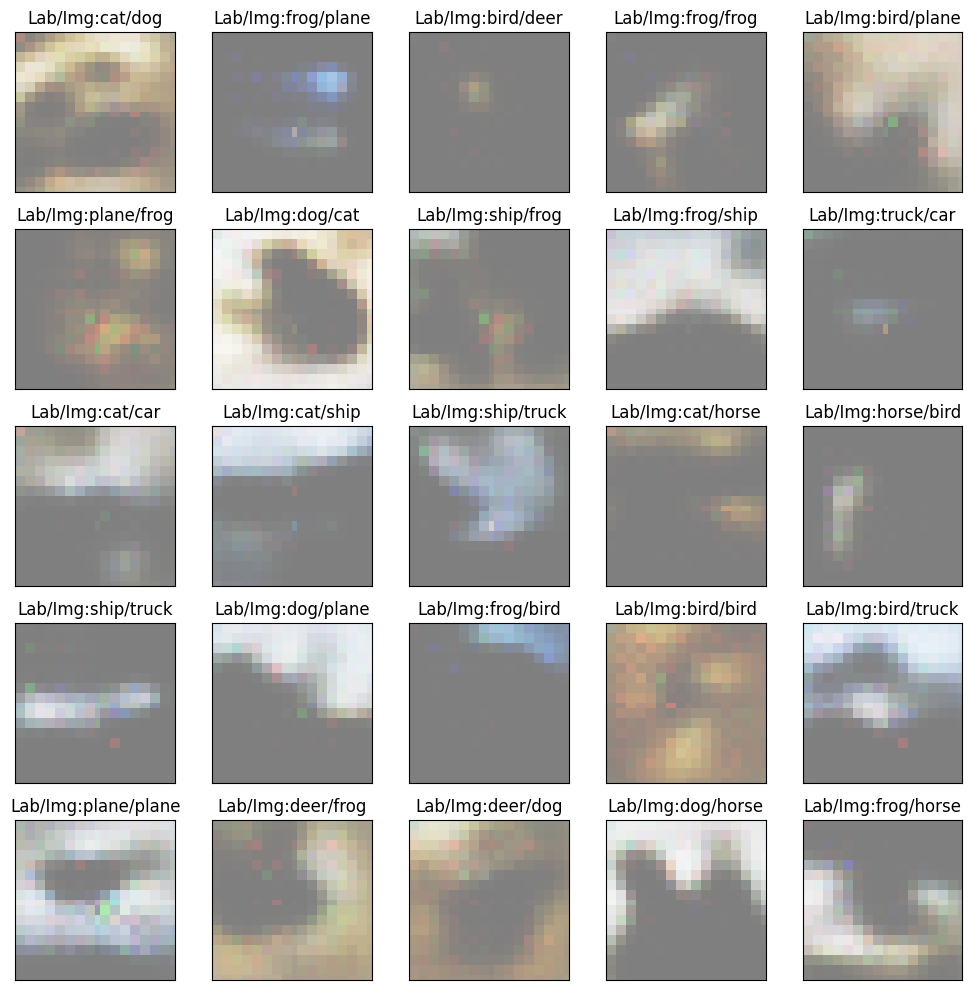

Epoch 224: 100%|██████████| 98/98 [00:07<00:00, 12.87it/s, v_num=5, elbo_train_step=1.61e+3, total_loss_train_step=2.850, label_loss_train_step=1.240, avg_diff_primary_train_step=0.0468, avg_diff_secondary_train_step=0.0157, elbo_train_epoch=1.64e+3, total_loss_train_epoch=2.810, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0303, avg_diff_secondary_train_epoch=0.0172, elbo_val_step=1.79e+3, total_loss_val_step=3.570, label_loss_val_step=1.780, avg_diff_primary_val_step=0.191, avg_diff_secondary_val_step=0.0196, elbo_val_epoch=1.6e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.232, avg_diff_secondary_val_epoch=0.0186]

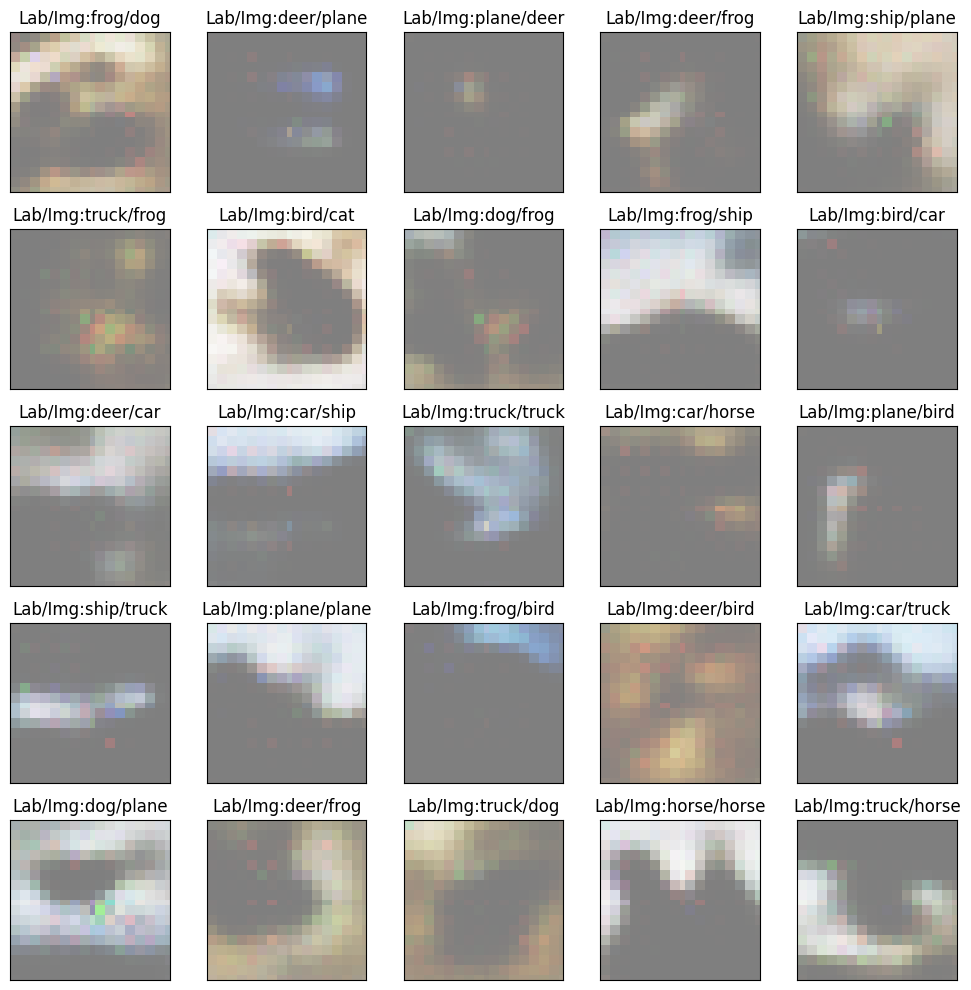

Epoch 229: 100%|██████████| 98/98 [00:07<00:00, 12.25it/s, v_num=5, elbo_train_step=1.6e+3, total_loss_train_step=2.730, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0224, avg_diff_secondary_train_step=0.0168, elbo_train_epoch=1.64e+3, total_loss_train_epoch=2.800, label_loss_train_epoch=1.170, avg_diff_primary_train_epoch=0.0304, avg_diff_secondary_train_epoch=0.0171, elbo_val_step=1.79e+3, total_loss_val_step=3.480, label_loss_val_step=1.690, avg_diff_primary_val_step=0.180, avg_diff_secondary_val_step=0.0199, elbo_val_epoch=1.6e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.160, avg_diff_primary_val_epoch=0.235, avg_diff_secondary_val_epoch=0.0186] 

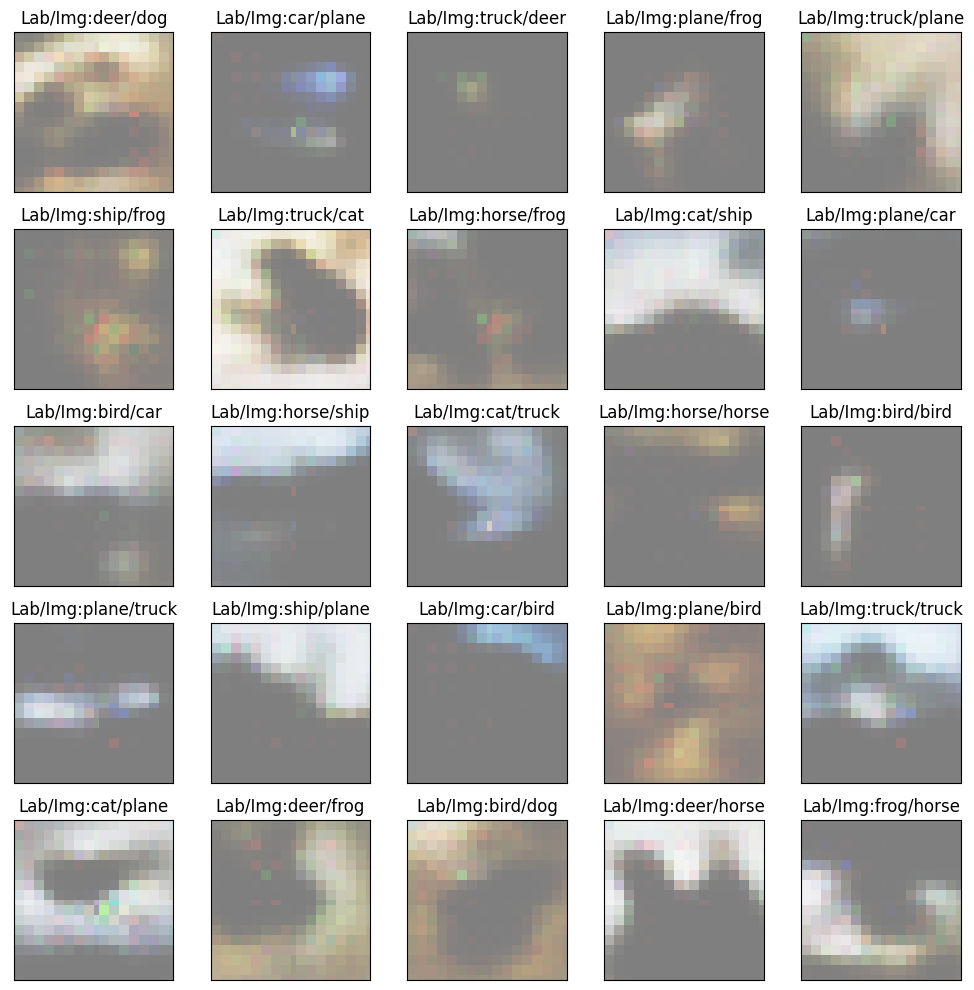

Epoch 234: 100%|██████████| 98/98 [00:07<00:00, 12.43it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.780, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0206, avg_diff_secondary_train_step=0.0182, elbo_train_epoch=1.64e+3, total_loss_train_epoch=2.800, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0297, avg_diff_secondary_train_epoch=0.0166, elbo_val_step=1.79e+3, total_loss_val_step=3.830, label_loss_val_step=2.040, avg_diff_primary_val_step=0.208, avg_diff_secondary_val_step=0.0136, elbo_val_epoch=1.59e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.236, avg_diff_secondary_val_epoch=0.0178]

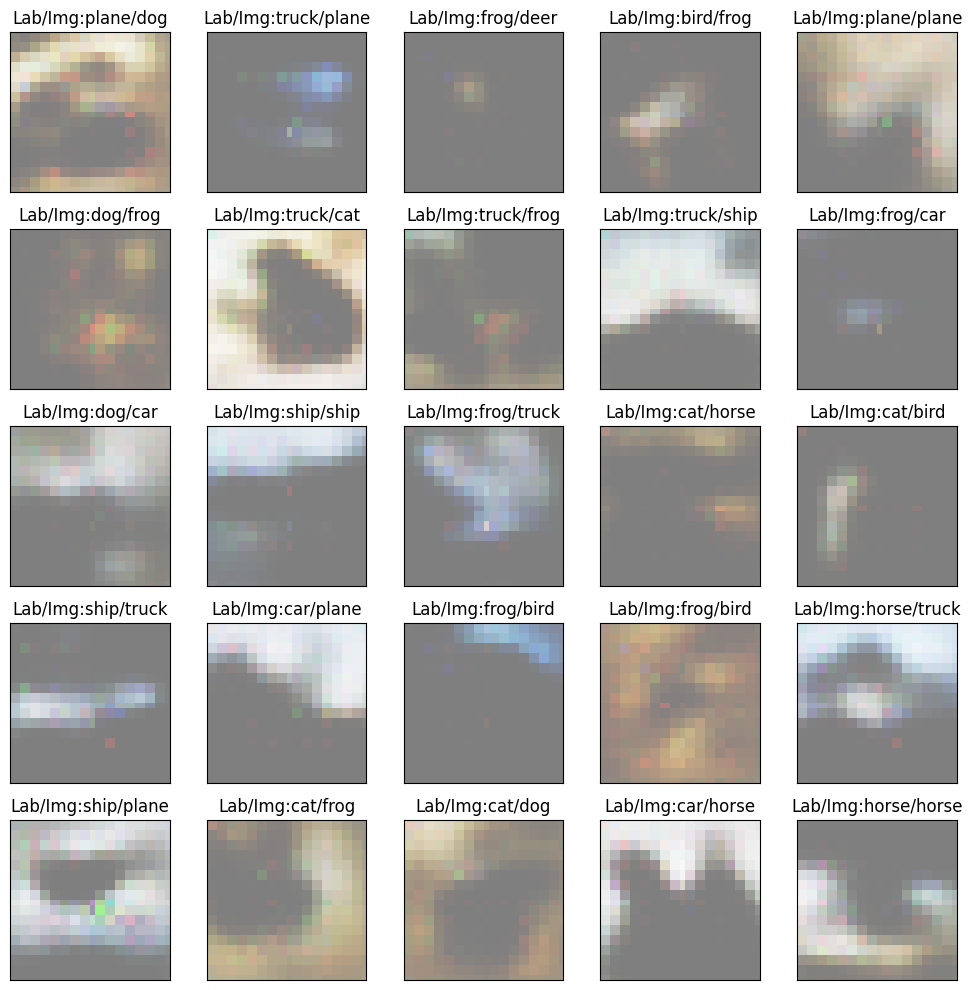

Epoch 239: 100%|██████████| 98/98 [00:07<00:00, 12.45it/s, v_num=5, elbo_train_step=1.59e+3, total_loss_train_step=2.750, label_loss_train_step=1.160, avg_diff_primary_train_step=0.0305, avg_diff_secondary_train_step=0.015, elbo_train_epoch=1.63e+3, total_loss_train_epoch=2.790, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0283, avg_diff_secondary_train_epoch=0.0161, elbo_val_step=1.78e+3, total_loss_val_step=3.220, label_loss_val_step=1.440, avg_diff_primary_val_step=0.144, avg_diff_secondary_val_step=0.0161, elbo_val_epoch=1.59e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.170, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.018]  

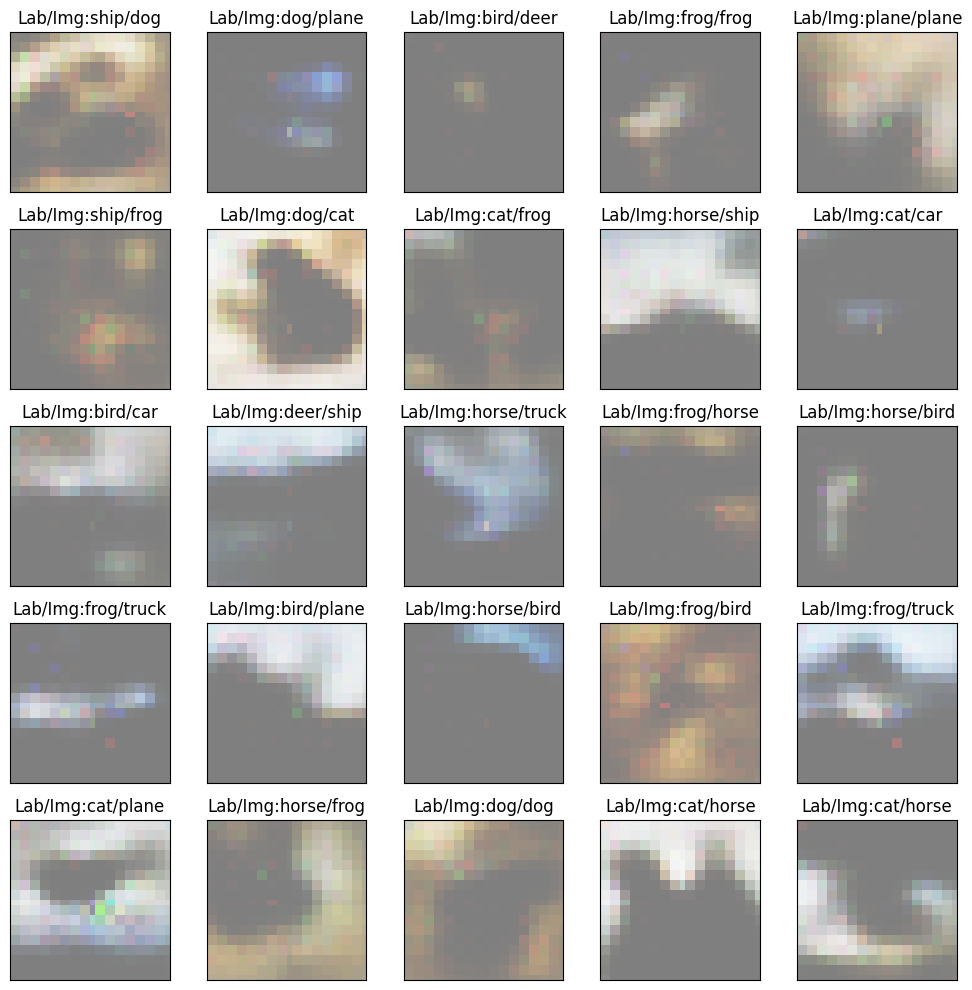

Epoch 244: 100%|██████████| 98/98 [00:07<00:00, 12.58it/s, v_num=5, elbo_train_step=1.65e+3, total_loss_train_step=2.830, label_loss_train_step=1.180, avg_diff_primary_train_step=0.0335, avg_diff_secondary_train_step=0.0161, elbo_train_epoch=1.63e+3, total_loss_train_epoch=2.790, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0285, avg_diff_secondary_train_epoch=0.016, elbo_val_step=1.79e+3, total_loss_val_step=3.590, label_loss_val_step=1.800, avg_diff_primary_val_step=0.183, avg_diff_secondary_val_step=0.0155, elbo_val_epoch=1.59e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.160, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0179] 

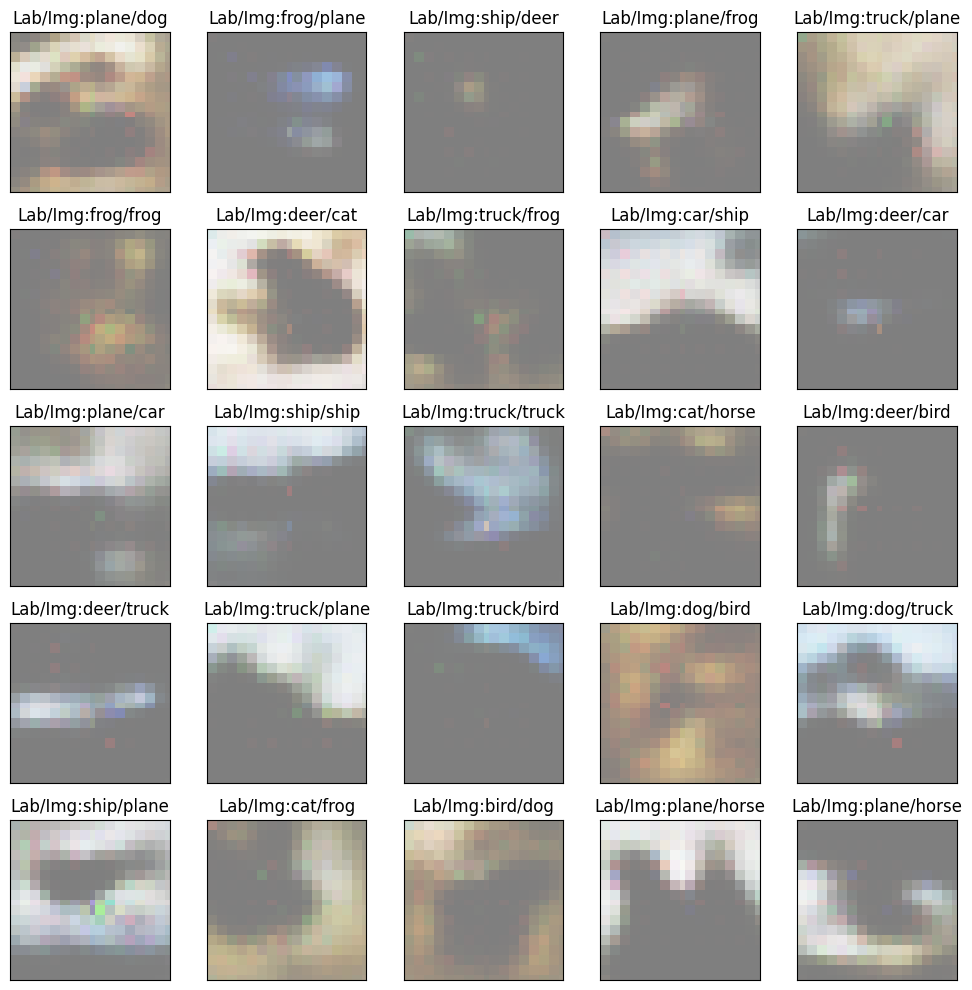

Epoch 249: 100%|██████████| 98/98 [00:07<00:00, 12.49it/s, v_num=5, elbo_train_step=1.75e+3, total_loss_train_step=2.930, label_loss_train_step=1.180, avg_diff_primary_train_step=0.037, avg_diff_secondary_train_step=0.015, elbo_train_epoch=1.63e+3, total_loss_train_epoch=2.780, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0269, avg_diff_secondary_train_epoch=0.0158, elbo_val_step=1.78e+3, total_loss_val_step=3.700, label_loss_val_step=1.920, avg_diff_primary_val_step=0.216, avg_diff_secondary_val_step=0.020, elbo_val_epoch=1.59e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0173]  

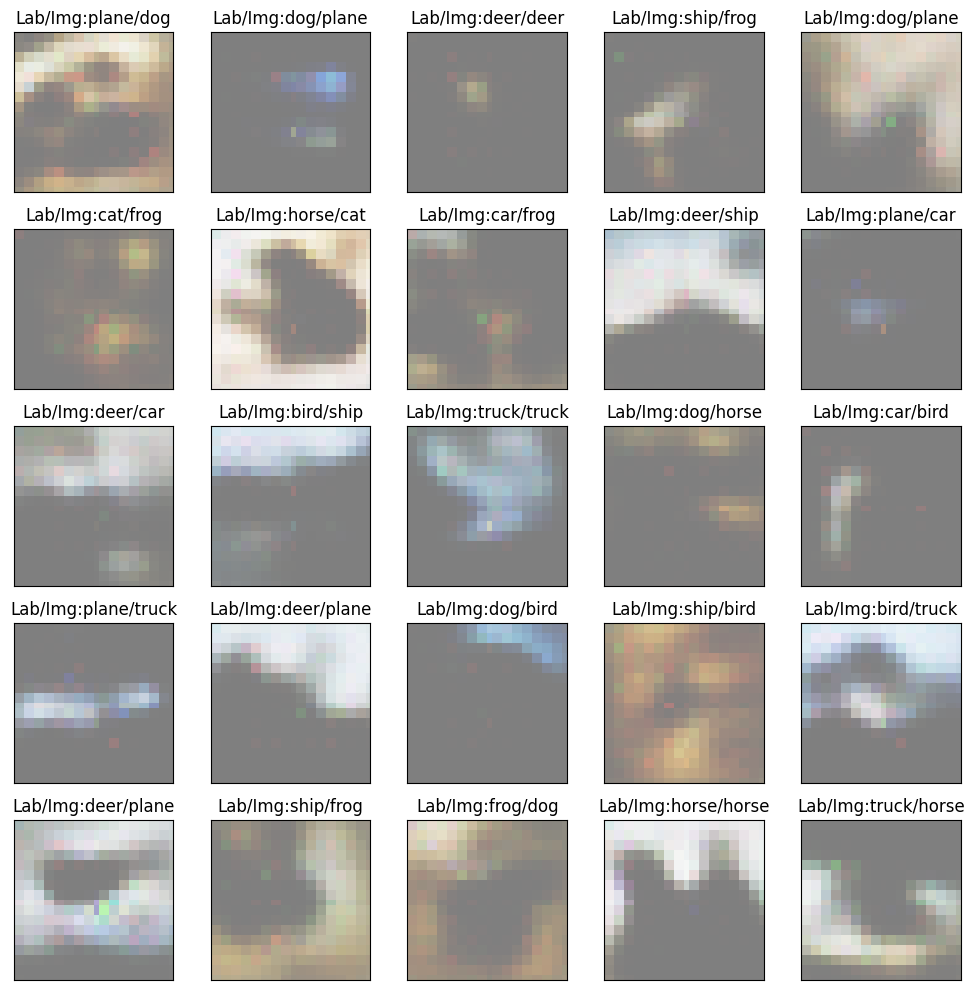

Epoch 254: 100%|██████████| 98/98 [00:07<00:00, 12.52it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.800, label_loss_train_step=1.170, avg_diff_primary_train_step=0.031, avg_diff_secondary_train_step=0.0158, elbo_train_epoch=1.63e+3, total_loss_train_epoch=2.790, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0276, avg_diff_secondary_train_epoch=0.0155, elbo_val_step=1.79e+3, total_loss_val_step=3.860, label_loss_val_step=2.080, avg_diff_primary_val_step=0.241, avg_diff_secondary_val_step=0.0136, elbo_val_epoch=1.58e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.170, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0171] 

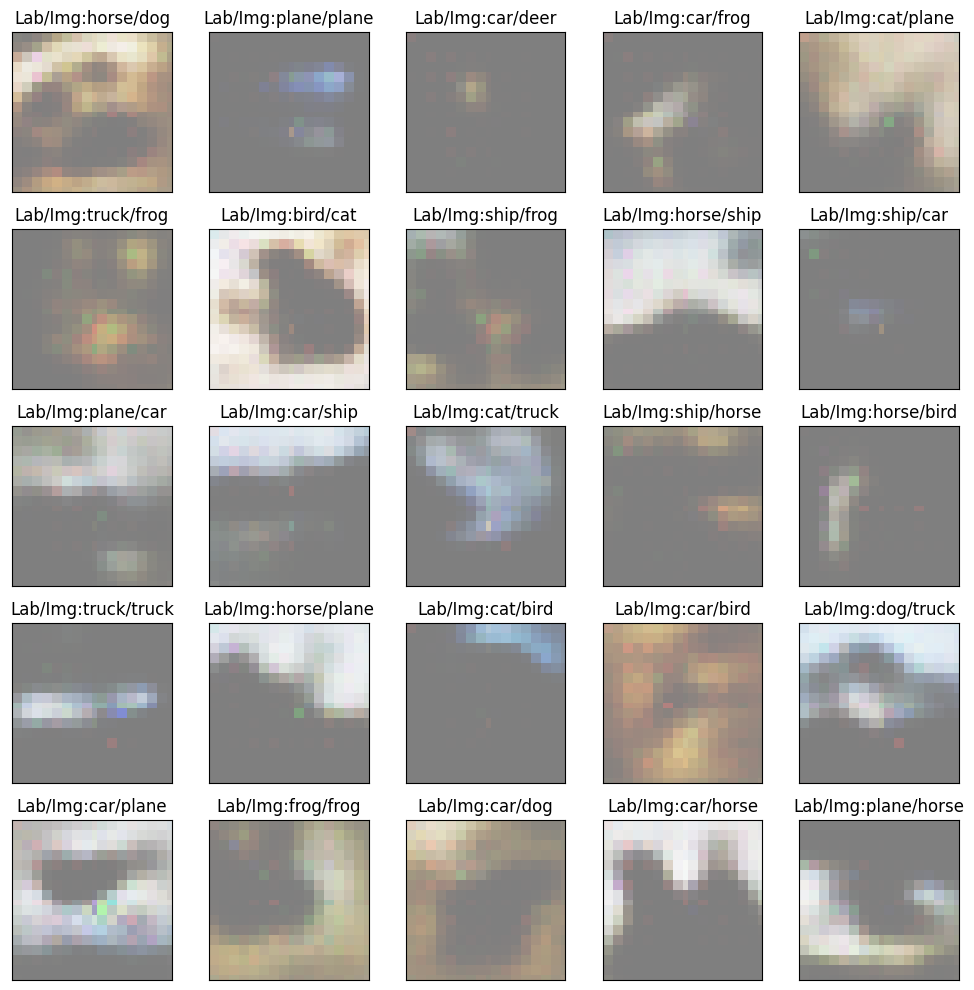

Epoch 259: 100%|██████████| 98/98 [00:07<00:00, 12.51it/s, v_num=5, elbo_train_step=1.6e+3, total_loss_train_step=2.750, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0205, avg_diff_secondary_train_step=0.0156, elbo_train_epoch=1.62e+3, total_loss_train_epoch=2.780, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0262, avg_diff_secondary_train_epoch=0.0152, elbo_val_step=1.78e+3, total_loss_val_step=3.450, label_loss_val_step=1.670, avg_diff_primary_val_step=0.135, avg_diff_secondary_val_step=0.0127, elbo_val_epoch=1.58e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.170, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0162] 

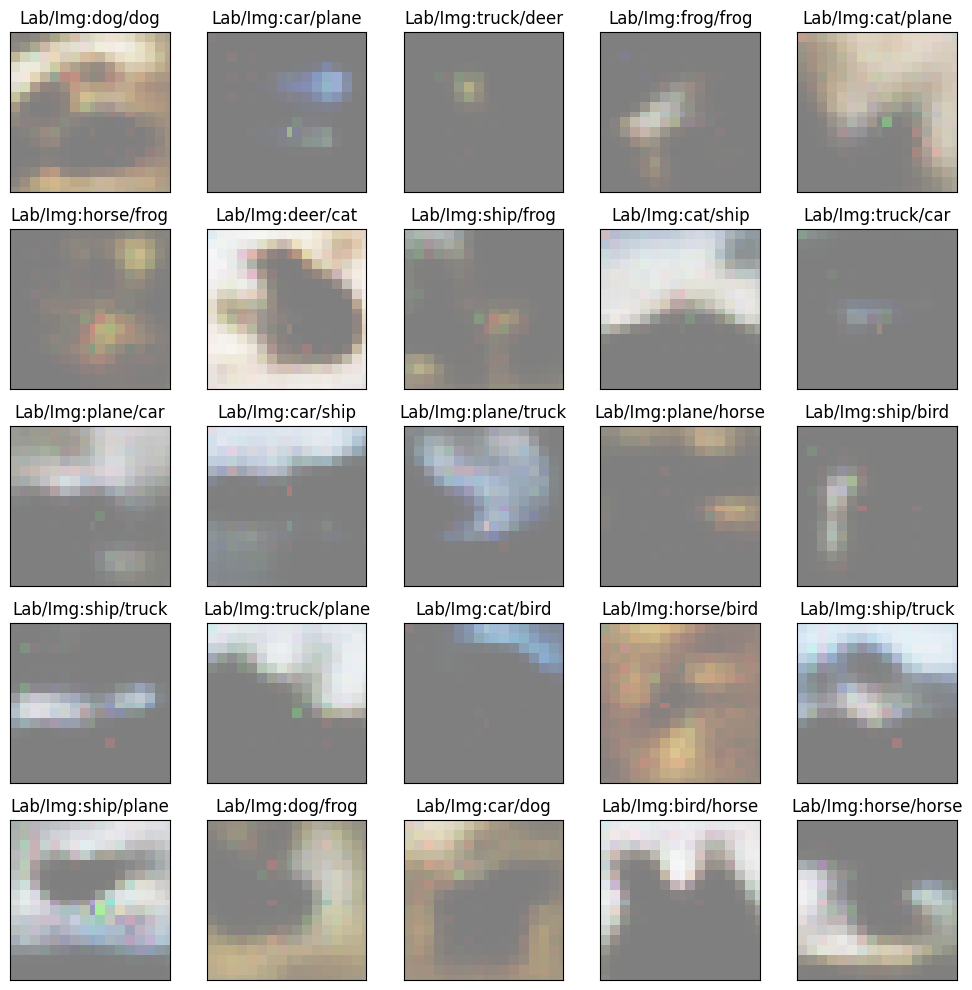

Epoch 264: 100%|██████████| 98/98 [00:07<00:00, 12.44it/s, v_num=5, elbo_train_step=1.53e+3, total_loss_train_step=2.710, label_loss_train_step=1.180, avg_diff_primary_train_step=0.0299, avg_diff_secondary_train_step=0.0148, elbo_train_epoch=1.62e+3, total_loss_train_epoch=2.780, label_loss_train_epoch=1.160, avg_diff_primary_train_epoch=0.0255, avg_diff_secondary_train_epoch=0.0149, elbo_val_step=1.78e+3, total_loss_val_step=3.610, label_loss_val_step=1.830, avg_diff_primary_val_step=0.177, avg_diff_secondary_val_step=0.0143, elbo_val_epoch=1.58e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.232, avg_diff_secondary_val_epoch=0.0163]

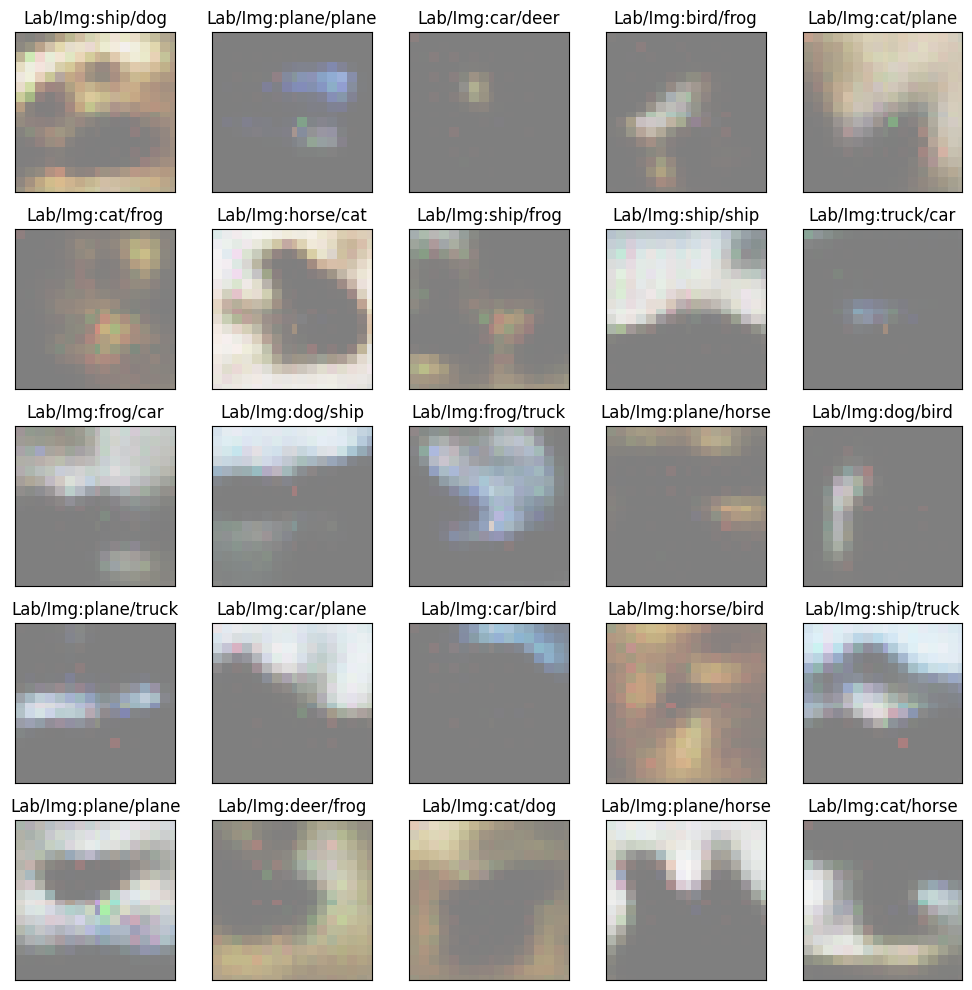

Epoch 269: 100%|██████████| 98/98 [00:07<00:00, 12.49it/s, v_num=5, elbo_train_step=1.63e+3, total_loss_train_step=2.760, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0171, avg_diff_secondary_train_step=0.0136, elbo_train_epoch=1.62e+3, total_loss_train_epoch=2.770, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0231, avg_diff_secondary_train_epoch=0.0146, elbo_val_step=1.78e+3, total_loss_val_step=3.340, label_loss_val_step=1.570, avg_diff_primary_val_step=0.124, avg_diff_secondary_val_step=0.0148, elbo_val_epoch=1.58e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.229, avg_diff_secondary_val_epoch=0.0163]

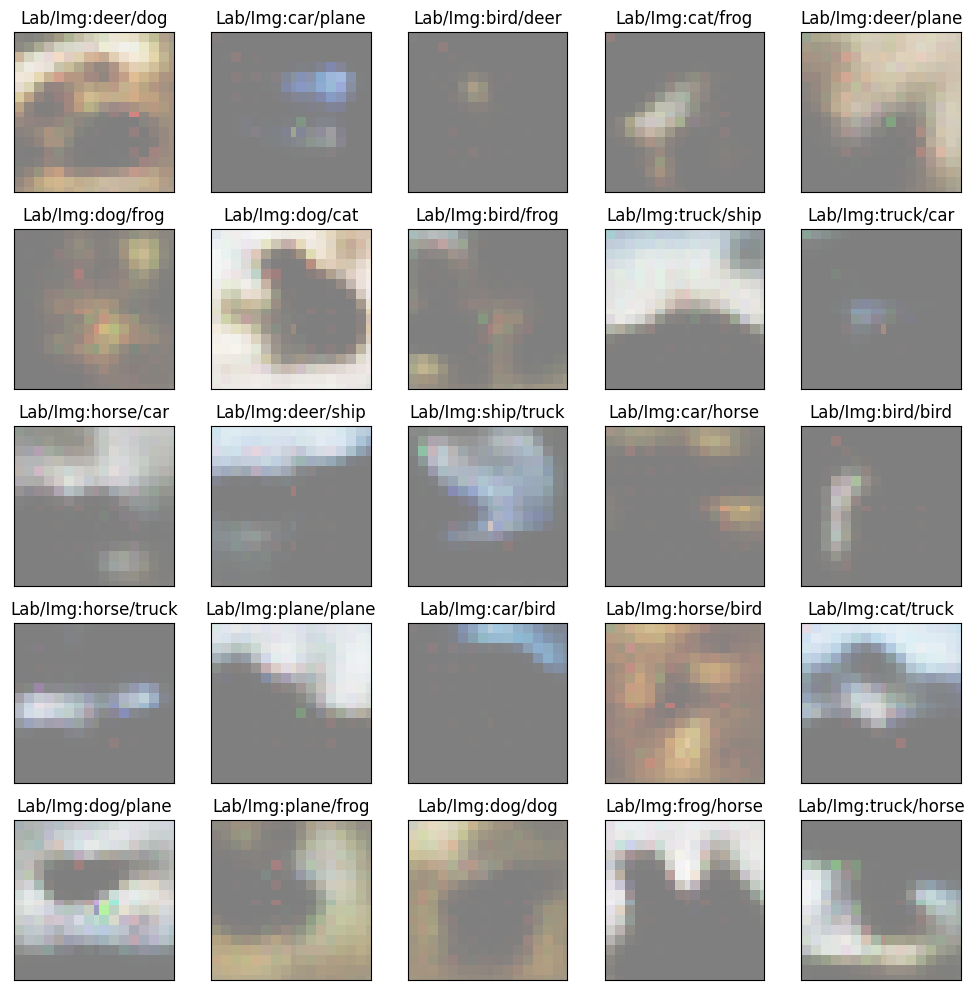

Epoch 274: 100%|██████████| 98/98 [00:07<00:00, 12.65it/s, v_num=5, elbo_train_step=1.62e+3, total_loss_train_step=2.780, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0238, avg_diff_secondary_train_step=0.0136, elbo_train_epoch=1.62e+3, total_loss_train_epoch=2.770, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0235, avg_diff_secondary_train_epoch=0.0144, elbo_val_step=1.77e+3, total_loss_val_step=3.580, label_loss_val_step=1.800, avg_diff_primary_val_step=0.150, avg_diff_secondary_val_step=0.016, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0156] 

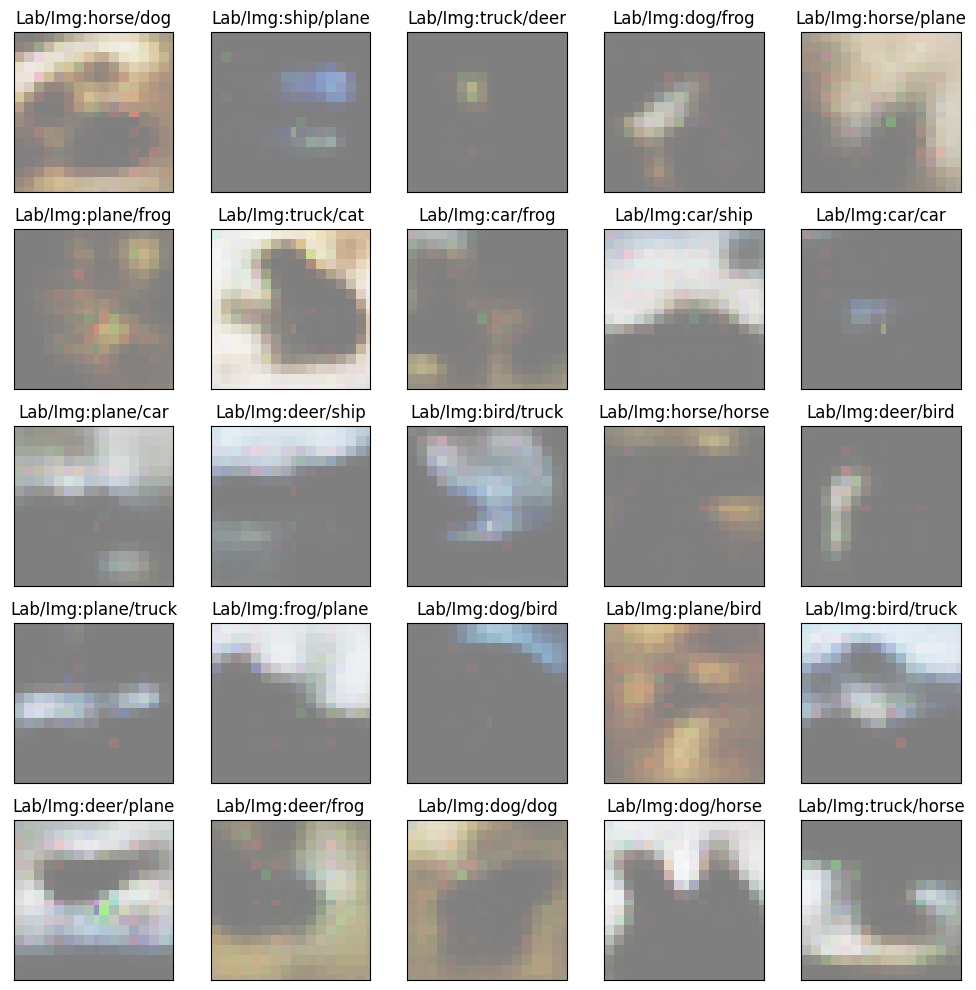

Epoch 279: 100%|██████████| 98/98 [00:07<00:00, 12.73it/s, v_num=5, elbo_train_step=1.65e+3, total_loss_train_step=2.800, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0232, avg_diff_secondary_train_step=0.0153, elbo_train_epoch=1.62e+3, total_loss_train_epoch=2.770, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0239, avg_diff_secondary_train_epoch=0.0144, elbo_val_step=1.78e+3, total_loss_val_step=3.310, label_loss_val_step=1.530, avg_diff_primary_val_step=0.110, avg_diff_secondary_val_step=0.0101, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.227, avg_diff_secondary_val_epoch=0.0152]

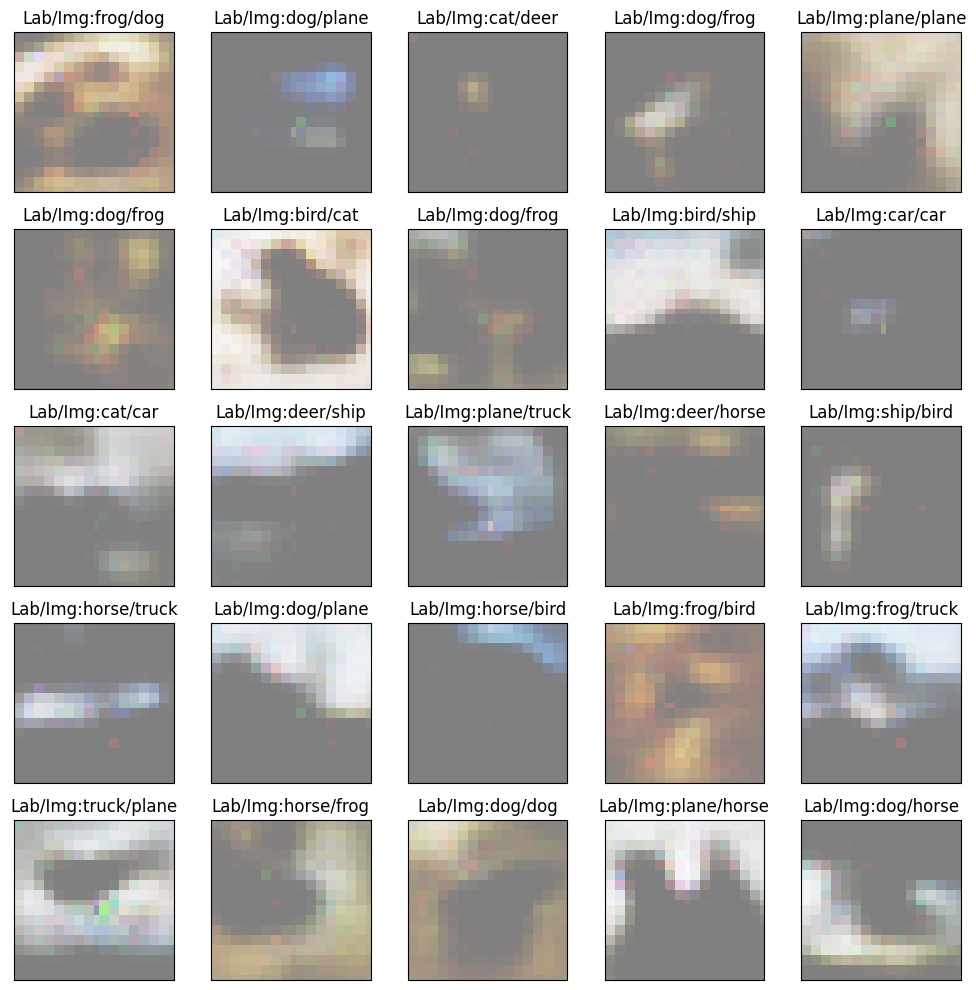

Epoch 284: 100%|██████████| 98/98 [00:07<00:00, 12.41it/s, v_num=5, elbo_train_step=1.67e+3, total_loss_train_step=2.830, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0265, avg_diff_secondary_train_step=0.0142, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.760, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0233, avg_diff_secondary_train_epoch=0.0142, elbo_val_step=1.77e+3, total_loss_val_step=3.430, label_loss_val_step=1.660, avg_diff_primary_val_step=0.133, avg_diff_secondary_val_step=0.0198, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.232, avg_diff_secondary_val_epoch=0.0162]

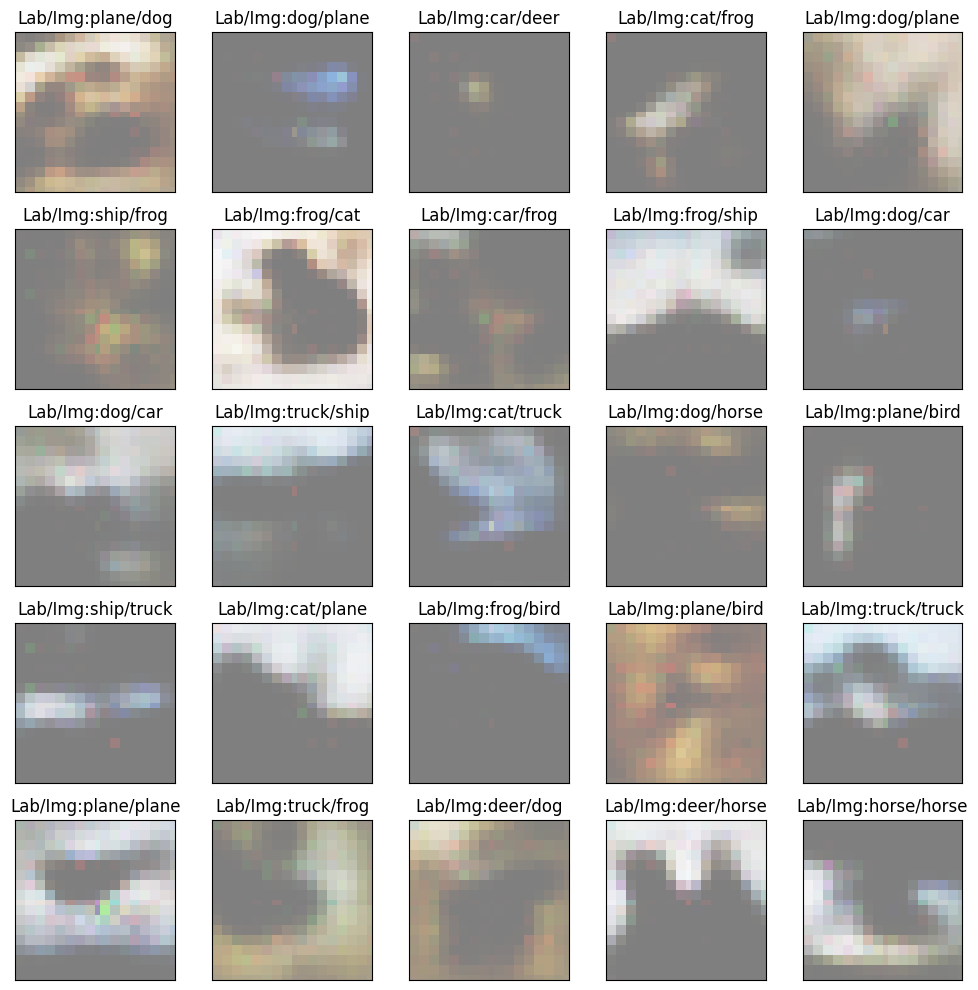

Epoch 289: 100%|██████████| 98/98 [00:07<00:00, 12.47it/s, v_num=5, elbo_train_step=1.72e+3, total_loss_train_step=2.860, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0215, avg_diff_secondary_train_step=0.0153, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.760, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0225, avg_diff_secondary_train_epoch=0.014, elbo_val_step=1.77e+3, total_loss_val_step=3.930, label_loss_val_step=2.160, avg_diff_primary_val_step=0.230, avg_diff_secondary_val_step=0.0193, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0162] 

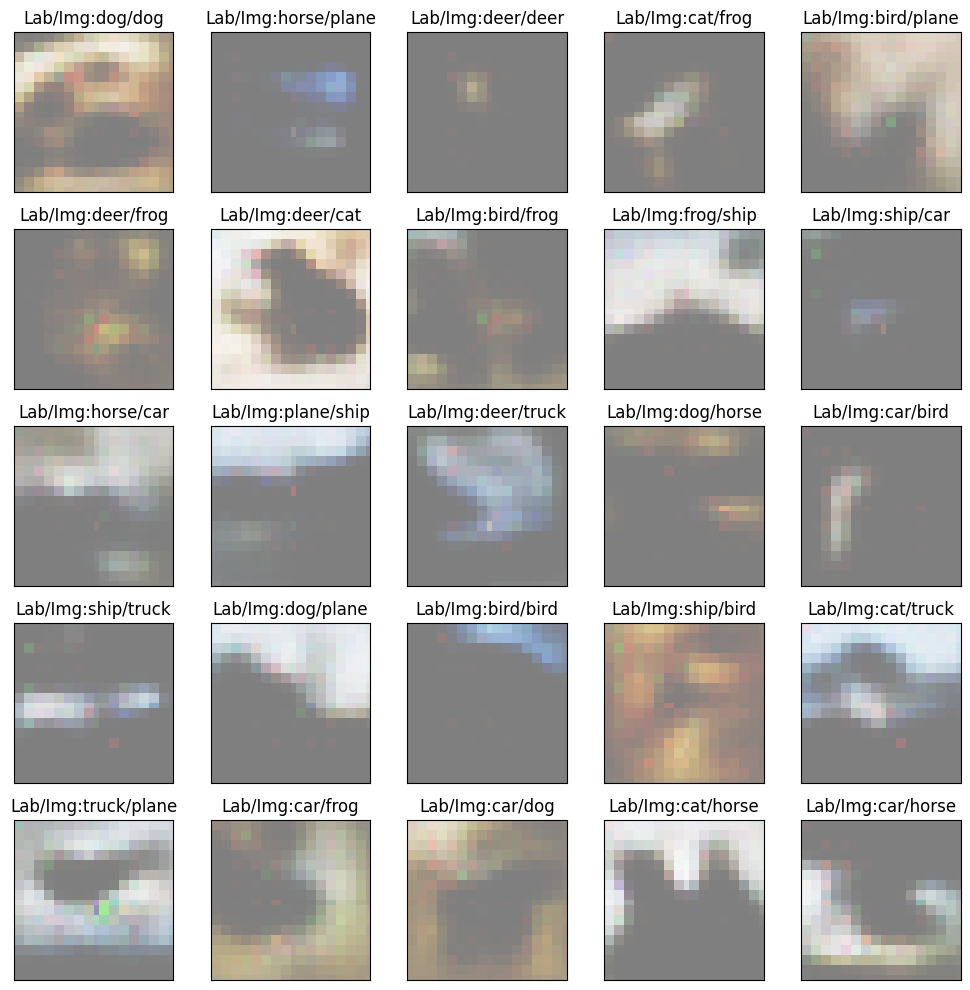

Epoch 294: 100%|██████████| 98/98 [00:07<00:00, 12.79it/s, v_num=5, elbo_train_step=1.56e+3, total_loss_train_step=2.710, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0194, avg_diff_secondary_train_step=0.0149, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.760, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0222, avg_diff_secondary_train_epoch=0.0138, elbo_val_step=1.77e+3, total_loss_val_step=3.700, label_loss_val_step=1.930, avg_diff_primary_val_step=0.189, avg_diff_secondary_val_step=0.0219, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0165]

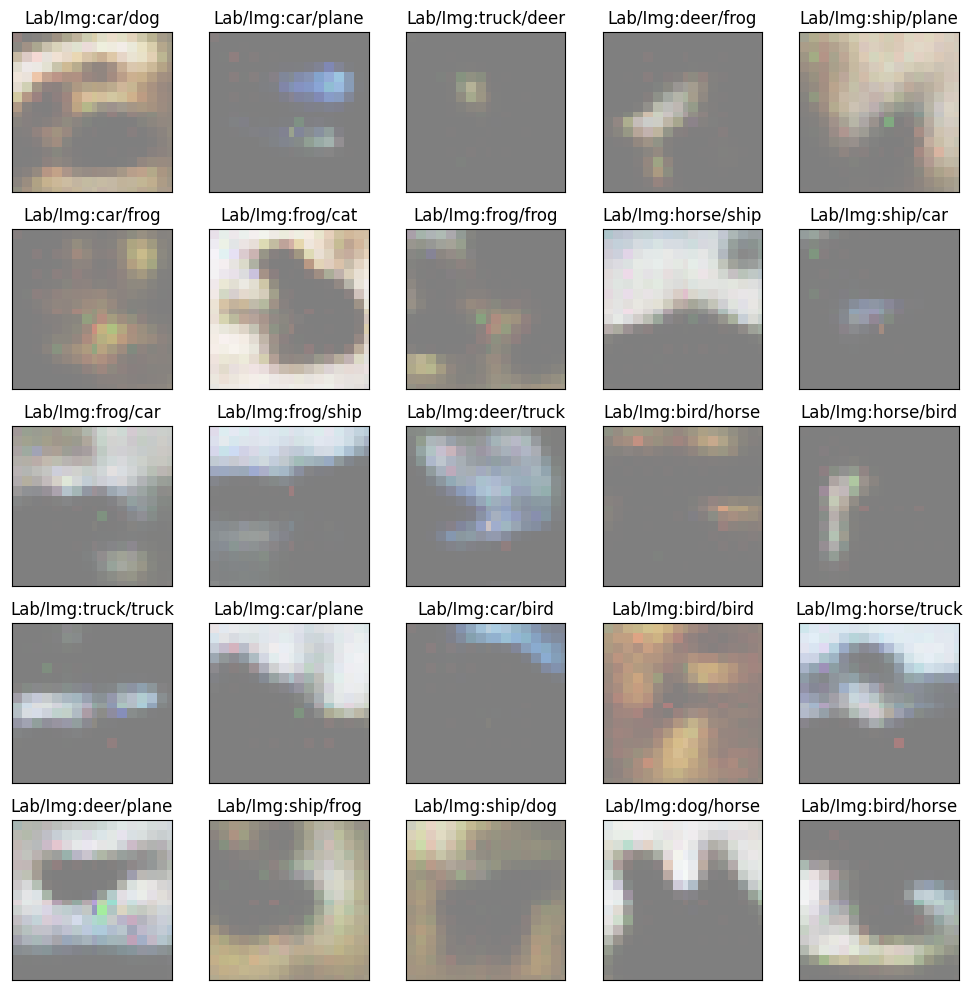

Epoch 299: 100%|██████████| 98/98 [00:07<00:00, 12.54it/s, v_num=5, elbo_train_step=1.6e+3, total_loss_train_step=2.730, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0159, avg_diff_secondary_train_step=0.0125, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.750, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0213, avg_diff_secondary_train_epoch=0.0134, elbo_val_step=1.77e+3, total_loss_val_step=3.710, label_loss_val_step=1.950, avg_diff_primary_val_step=0.227, avg_diff_secondary_val_step=0.0154, elbo_val_epoch=1.57e+3, total_loss_val_epoch=3.740, label_loss_val_epoch=2.170, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.016]  

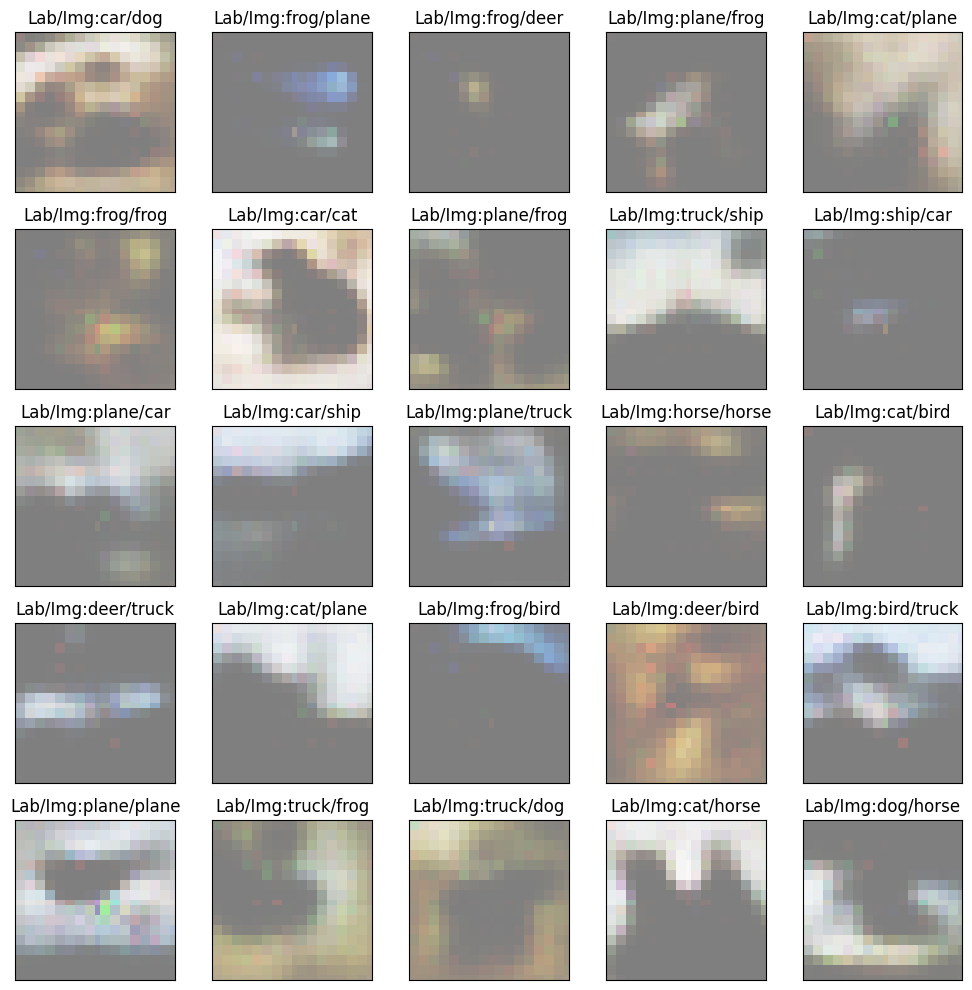

Epoch 304: 100%|██████████| 98/98 [00:07<00:00, 12.45it/s, v_num=5, elbo_train_step=1.58e+3, total_loss_train_step=2.720, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0206, avg_diff_secondary_train_step=0.0126, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.750, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0197, avg_diff_secondary_train_epoch=0.0132, elbo_val_step=1.76e+3, total_loss_val_step=3.790, label_loss_val_step=2.030, avg_diff_primary_val_step=0.204, avg_diff_secondary_val_step=0.013, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0149]

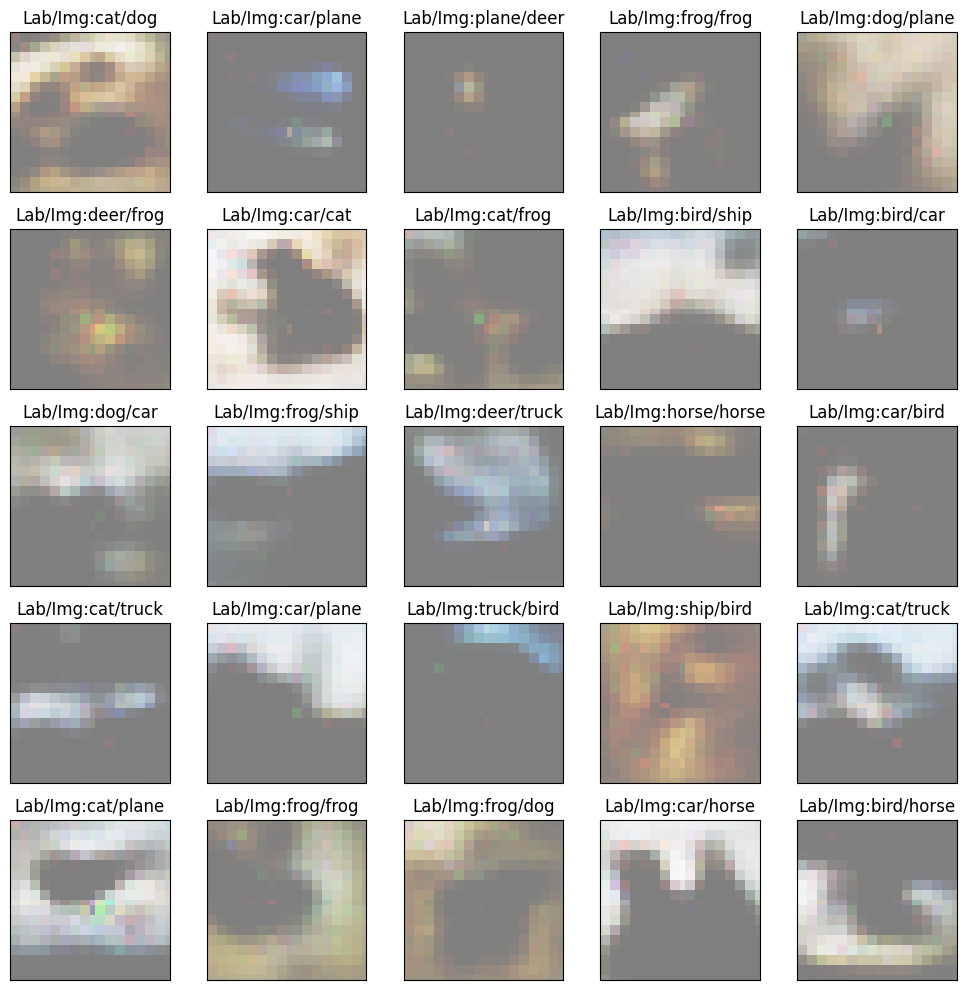

Epoch 309: 100%|██████████| 98/98 [00:07<00:00, 12.49it/s, v_num=5, elbo_train_step=1.54e+3, total_loss_train_step=2.690, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0222, avg_diff_secondary_train_step=0.013, elbo_train_epoch=1.61e+3, total_loss_train_epoch=2.750, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0206, avg_diff_secondary_train_epoch=0.013, elbo_val_step=1.76e+3, total_loss_val_step=3.740, label_loss_val_step=1.980, avg_diff_primary_val_step=0.193, avg_diff_secondary_val_step=0.0105, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.226, avg_diff_secondary_val_epoch=0.0151]  

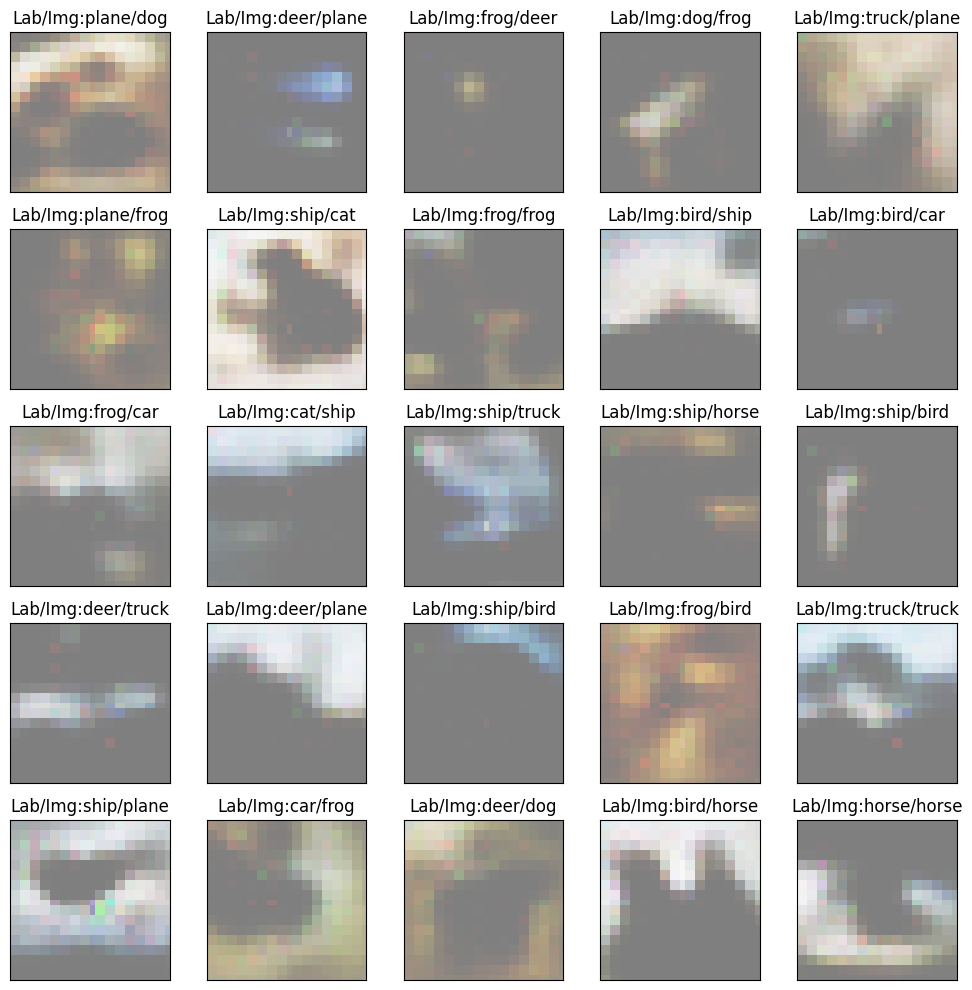

Epoch 314: 100%|██████████| 98/98 [00:07<00:00, 12.43it/s, v_num=5, elbo_train_step=1.72e+3, total_loss_train_step=2.850, label_loss_train_step=1.130, avg_diff_primary_train_step=0.018, avg_diff_secondary_train_step=0.0138, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.750, label_loss_train_epoch=1.150, avg_diff_primary_train_epoch=0.0213, avg_diff_secondary_train_epoch=0.0133, elbo_val_step=1.76e+3, total_loss_val_step=3.700, label_loss_val_step=1.940, avg_diff_primary_val_step=0.171, avg_diff_secondary_val_step=0.0148, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0151] 

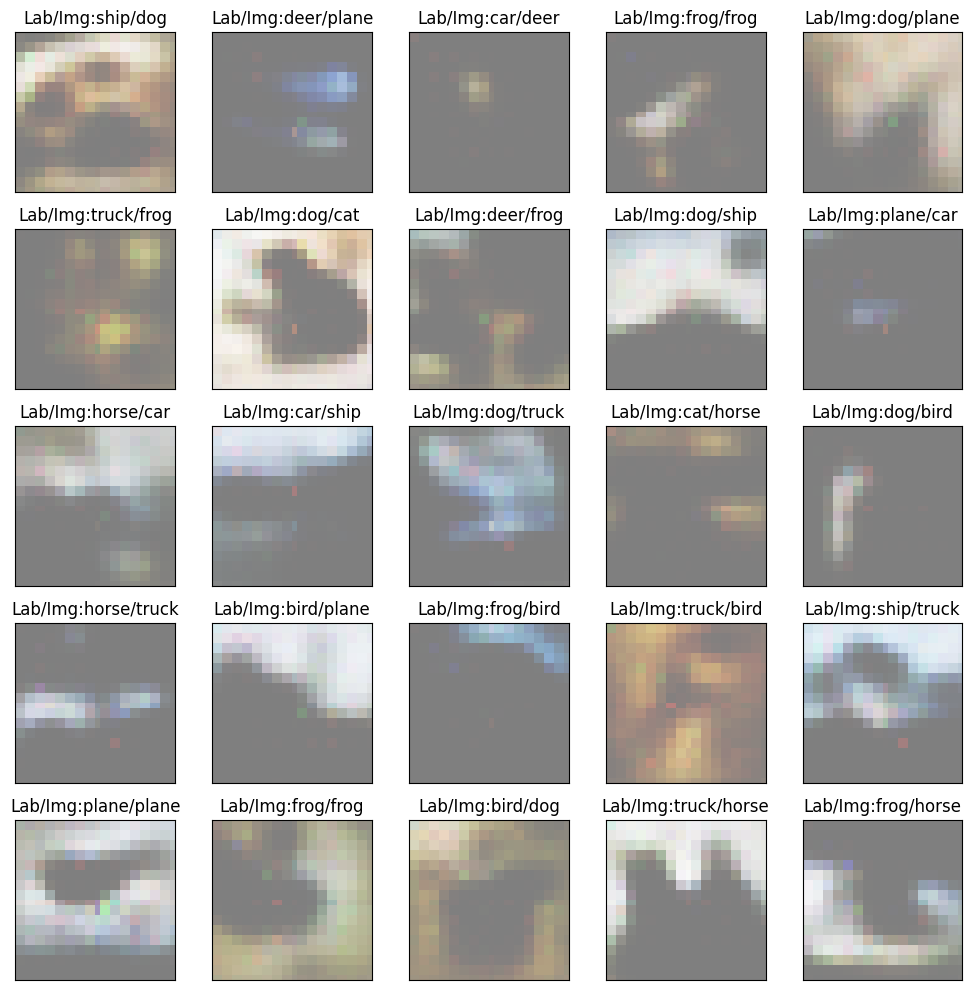

Epoch 319: 100%|██████████| 98/98 [00:07<00:00, 12.42it/s, v_num=5, elbo_train_step=1.65e+3, total_loss_train_step=2.800, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0223, avg_diff_secondary_train_step=0.0123, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.740, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0199, avg_diff_secondary_train_epoch=0.0128, elbo_val_step=1.76e+3, total_loss_val_step=3.770, label_loss_val_step=2.020, avg_diff_primary_val_step=0.267, avg_diff_secondary_val_step=0.0199, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0153]

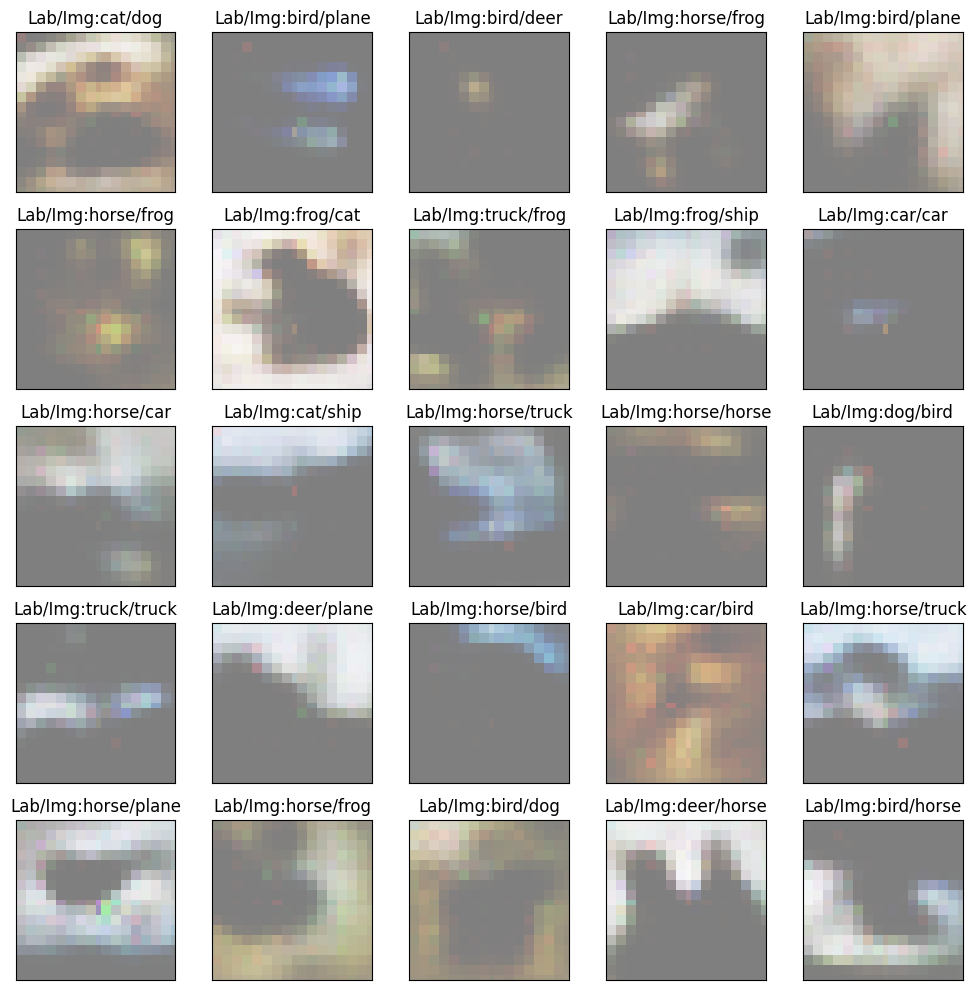

Epoch 324: 100%|██████████| 98/98 [00:07<00:00, 12.28it/s, v_num=5, elbo_train_step=1.56e+3, total_loss_train_step=2.690, label_loss_train_step=1.130, avg_diff_primary_train_step=0.016, avg_diff_secondary_train_step=0.0121, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.740, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0188, avg_diff_secondary_train_epoch=0.0125, elbo_val_step=1.76e+3, total_loss_val_step=4.080, label_loss_val_step=2.320, avg_diff_primary_val_step=0.237, avg_diff_secondary_val_step=0.0145, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.740, label_loss_val_epoch=2.180, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0155] 

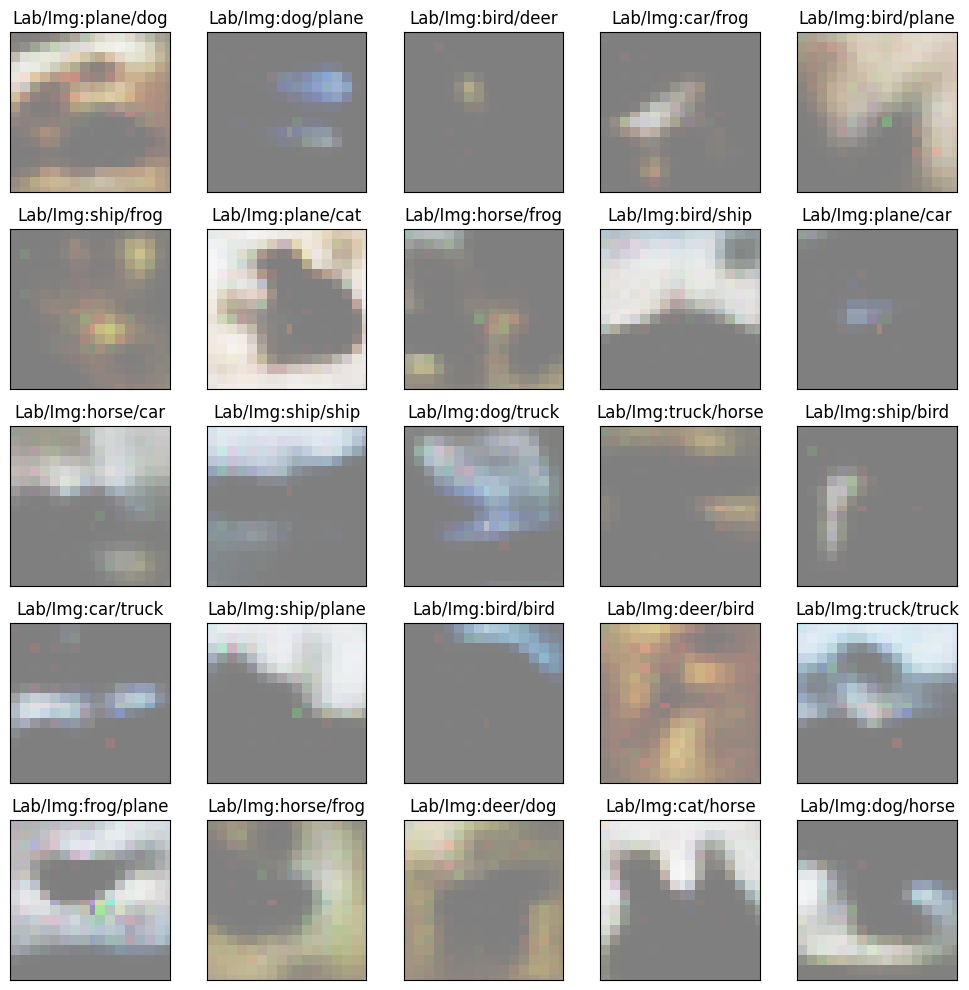

Epoch 329: 100%|██████████| 98/98 [00:07<00:00, 12.52it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.780, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0186, avg_diff_secondary_train_step=0.0123, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.740, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0193, avg_diff_secondary_train_epoch=0.0125, elbo_val_step=1.75e+3, total_loss_val_step=3.800, label_loss_val_step=2.040, avg_diff_primary_val_step=0.236, avg_diff_secondary_val_step=0.0165, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0144]

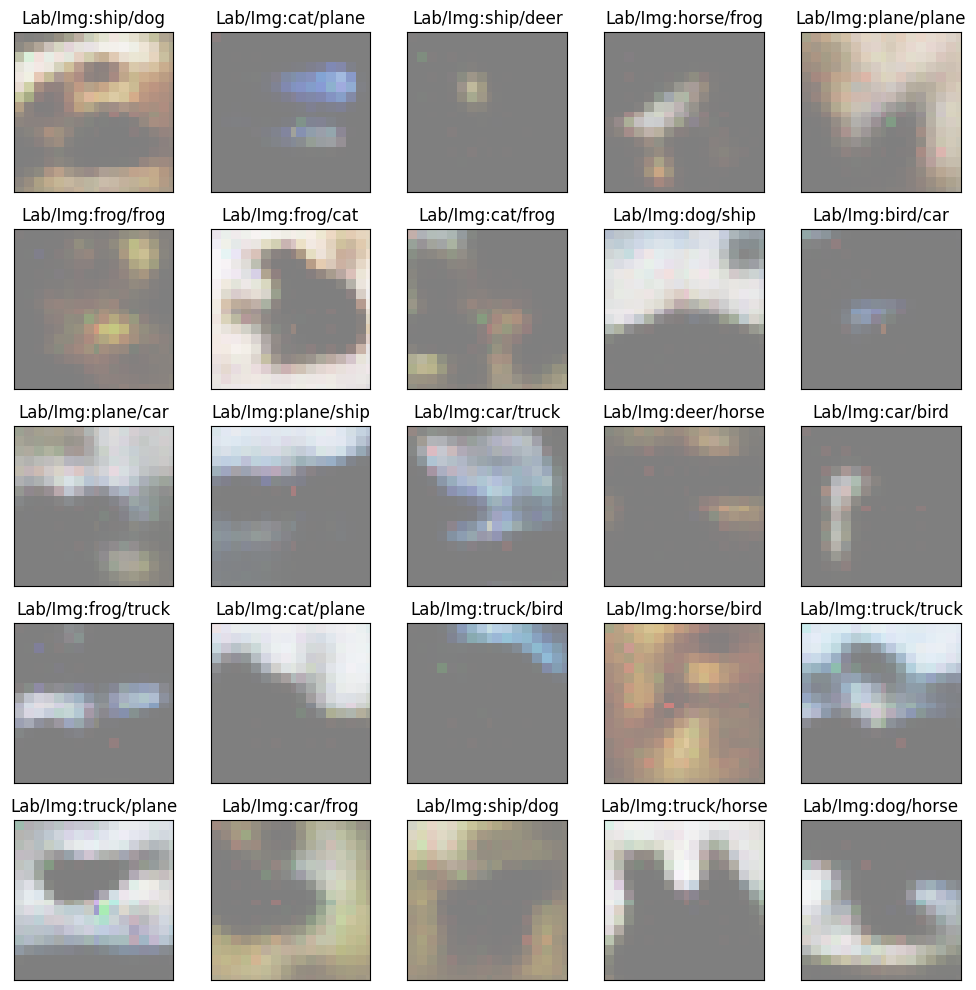

Epoch 334: 100%|██████████| 98/98 [00:07<00:00, 12.43it/s, v_num=5, elbo_train_step=1.52e+3, total_loss_train_step=2.660, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0165, avg_diff_secondary_train_step=0.0126, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.740, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0185, avg_diff_secondary_train_epoch=0.0122, elbo_val_step=1.75e+3, total_loss_val_step=3.980, label_loss_val_step=2.230, avg_diff_primary_val_step=0.213, avg_diff_secondary_val_step=0.0171, elbo_val_epoch=1.56e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.229, avg_diff_secondary_val_epoch=0.0156]

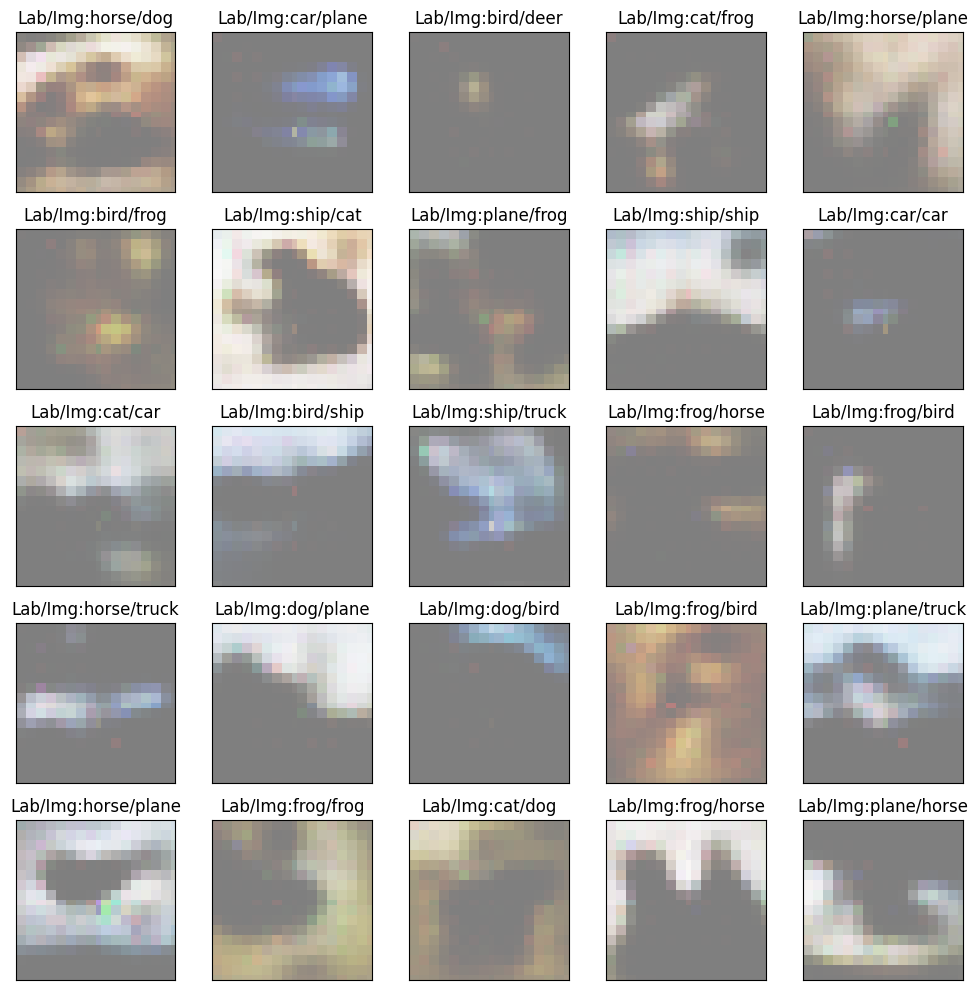

Epoch 339: 100%|██████████| 98/98 [00:07<00:00, 12.72it/s, v_num=5, elbo_train_step=1.57e+3, total_loss_train_step=2.700, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0163, avg_diff_secondary_train_step=0.0124, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.740, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.019, avg_diff_secondary_train_epoch=0.0122, elbo_val_step=1.75e+3, total_loss_val_step=3.790, label_loss_val_step=2.040, avg_diff_primary_val_step=0.178, avg_diff_secondary_val_step=0.0182, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0151] 

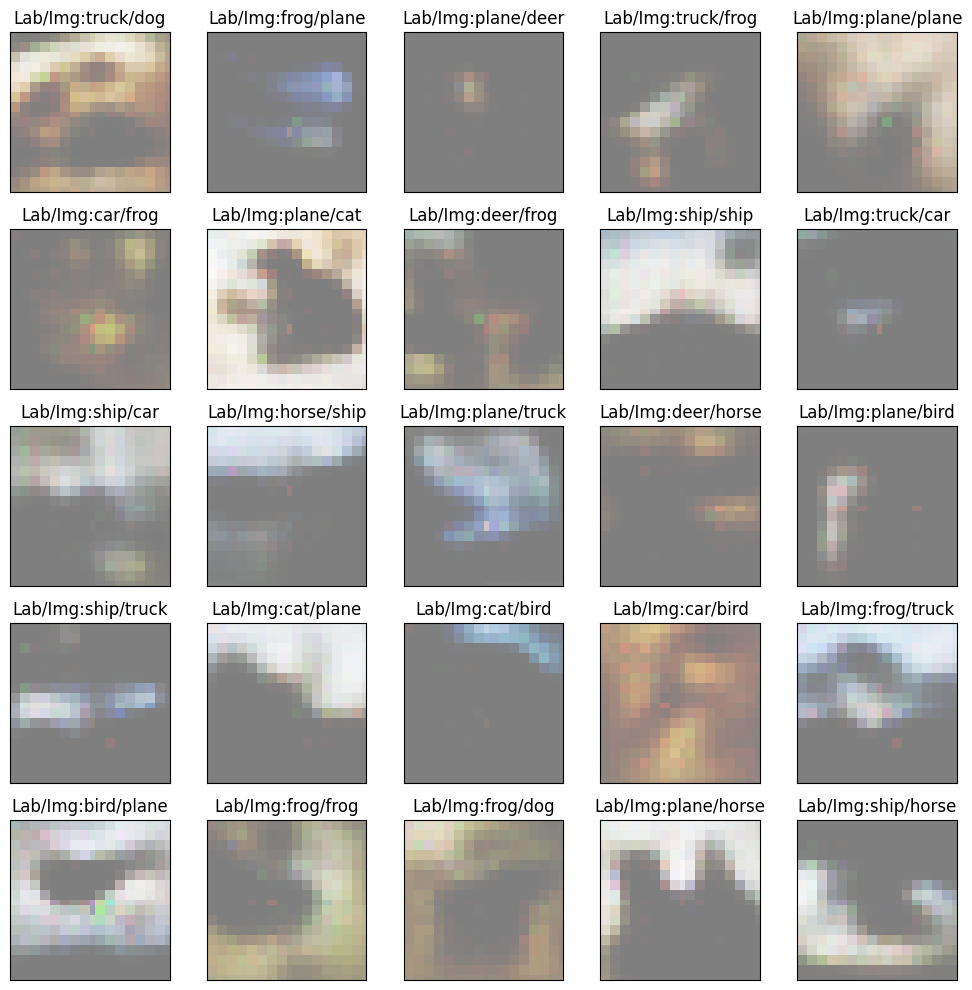

Epoch 344: 100%|██████████| 98/98 [00:07<00:00, 12.50it/s, v_num=5, elbo_train_step=1.62e+3, total_loss_train_step=2.750, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0147, avg_diff_secondary_train_step=0.012, elbo_train_epoch=1.6e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0172, avg_diff_secondary_train_epoch=0.012, elbo_val_step=1.75e+3, total_loss_val_step=3.250, label_loss_val_step=1.490, avg_diff_primary_val_step=0.0844, avg_diff_secondary_val_step=0.0131, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.226, avg_diff_secondary_val_epoch=0.0145]  

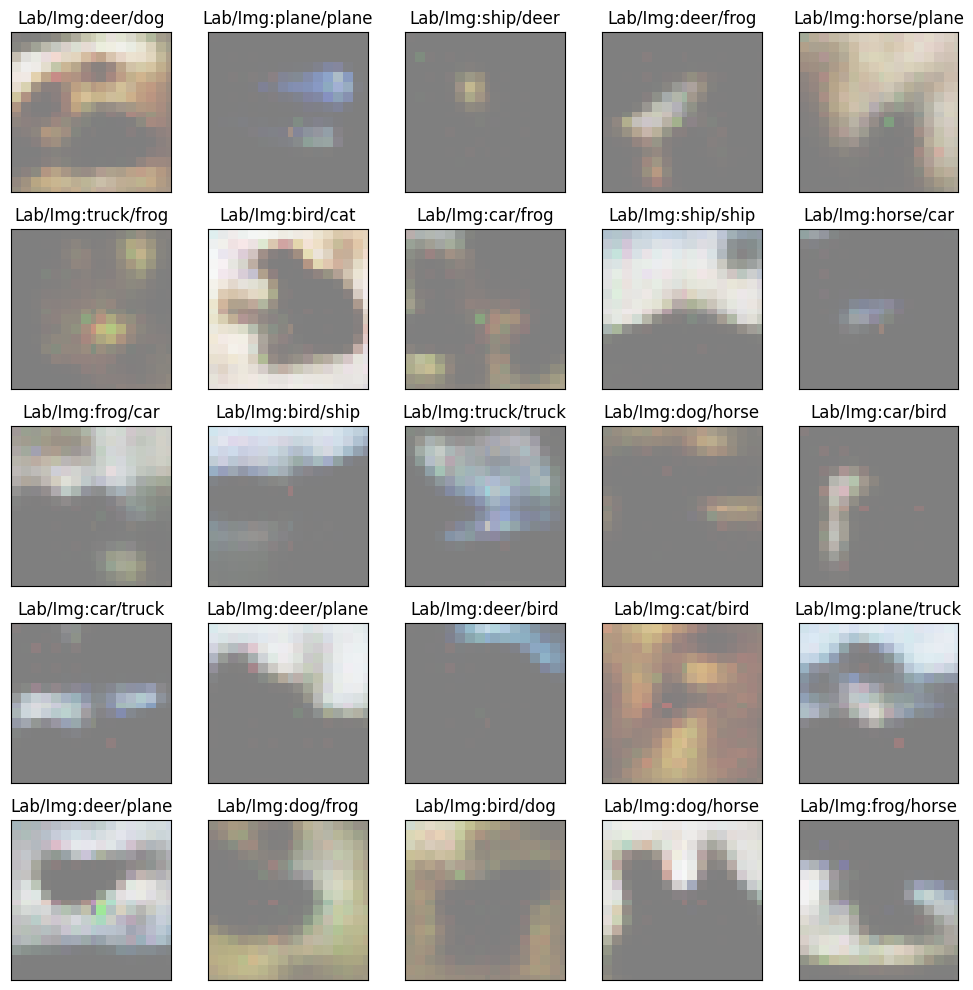

Epoch 349: 100%|██████████| 98/98 [00:07<00:00, 12.43it/s, v_num=5, elbo_train_step=1.58e+3, total_loss_train_step=2.730, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0223, avg_diff_secondary_train_step=0.0134, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0178, avg_diff_secondary_train_epoch=0.0119, elbo_val_step=1.75e+3, total_loss_val_step=3.490, label_loss_val_step=1.740, avg_diff_primary_val_step=0.180, avg_diff_secondary_val_step=0.0148, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0148]

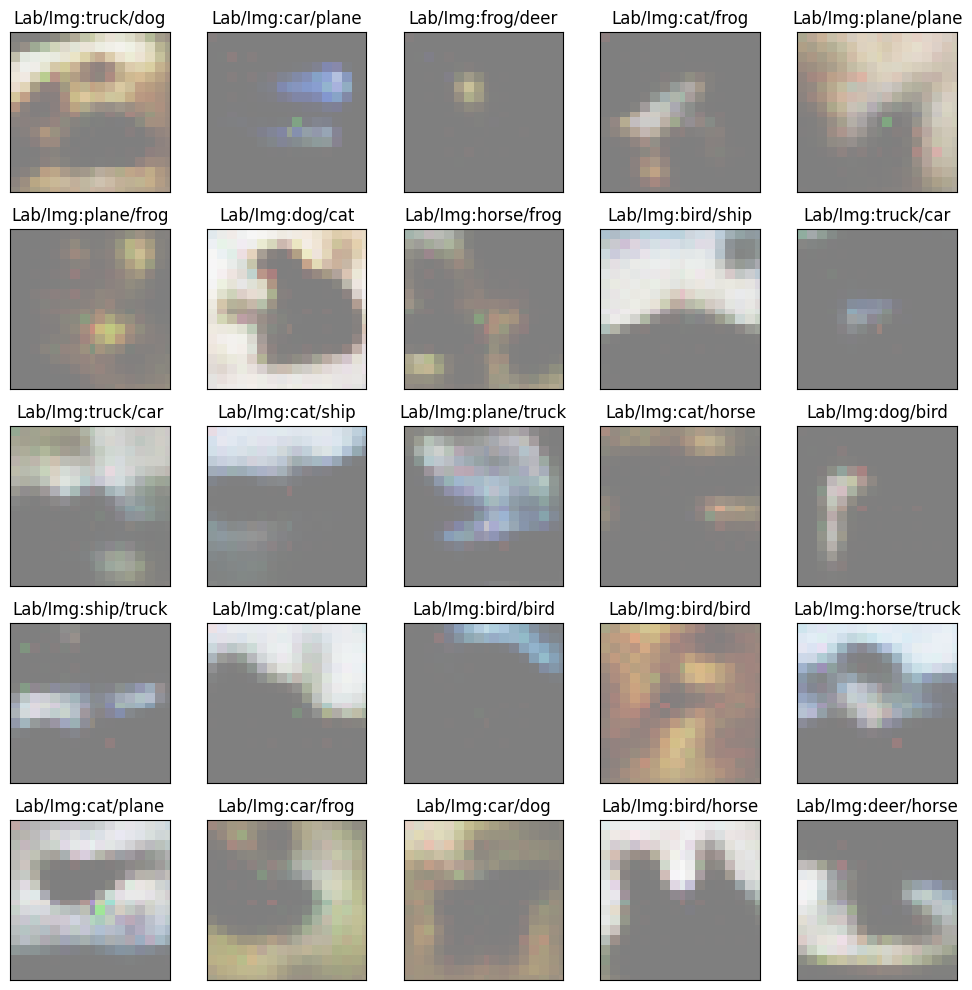

Epoch 354: 100%|██████████| 98/98 [00:07<00:00, 12.46it/s, v_num=5, elbo_train_step=1.62e+3, total_loss_train_step=2.770, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0242, avg_diff_secondary_train_step=0.0111, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0171, avg_diff_secondary_train_epoch=0.0119, elbo_val_step=1.75e+3, total_loss_val_step=3.740, label_loss_val_step=1.990, avg_diff_primary_val_step=0.212, avg_diff_secondary_val_step=0.0148, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0147] 

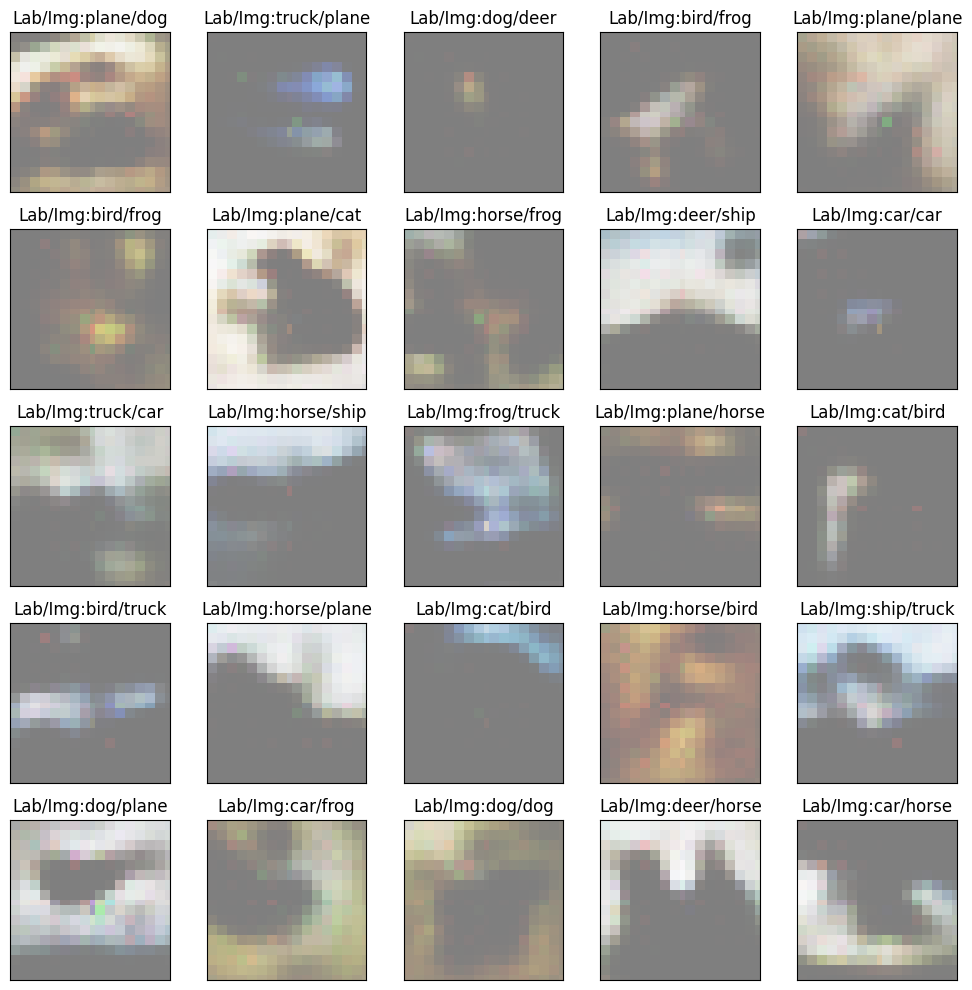

Epoch 359: 100%|██████████| 98/98 [00:08<00:00, 12.06it/s, v_num=5, elbo_train_step=1.54e+3, total_loss_train_step=2.680, label_loss_train_step=1.140, avg_diff_primary_train_step=0.0185, avg_diff_secondary_train_step=0.0123, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0166, avg_diff_secondary_train_epoch=0.0115, elbo_val_step=1.75e+3, total_loss_val_step=3.430, label_loss_val_step=1.690, avg_diff_primary_val_step=0.163, avg_diff_secondary_val_step=0.0151, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0139]

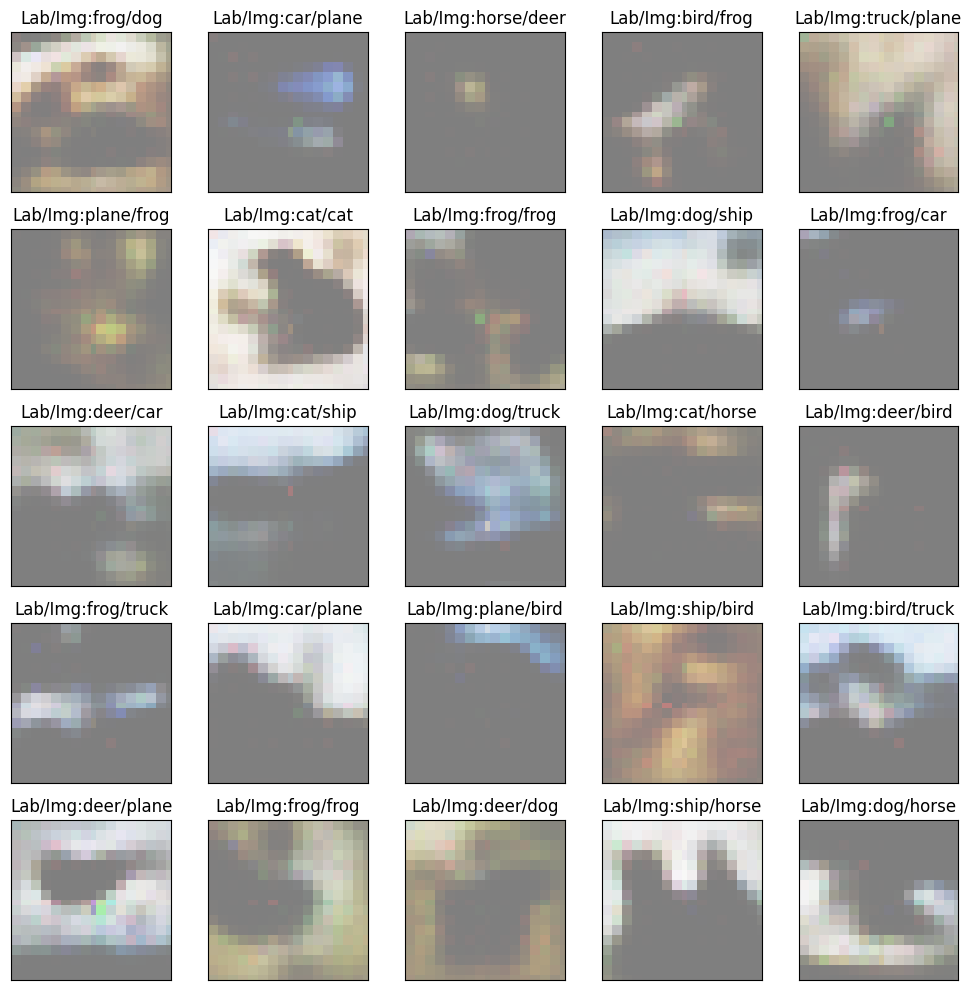

Epoch 364: 100%|██████████| 98/98 [00:07<00:00, 12.35it/s, v_num=5, elbo_train_step=1.63e+3, total_loss_train_step=2.760, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0122, avg_diff_secondary_train_step=0.0115, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0166, avg_diff_secondary_train_epoch=0.0115, elbo_val_step=1.74e+3, total_loss_val_step=3.780, label_loss_val_step=2.030, avg_diff_primary_val_step=0.199, avg_diff_secondary_val_step=0.0132, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0143]

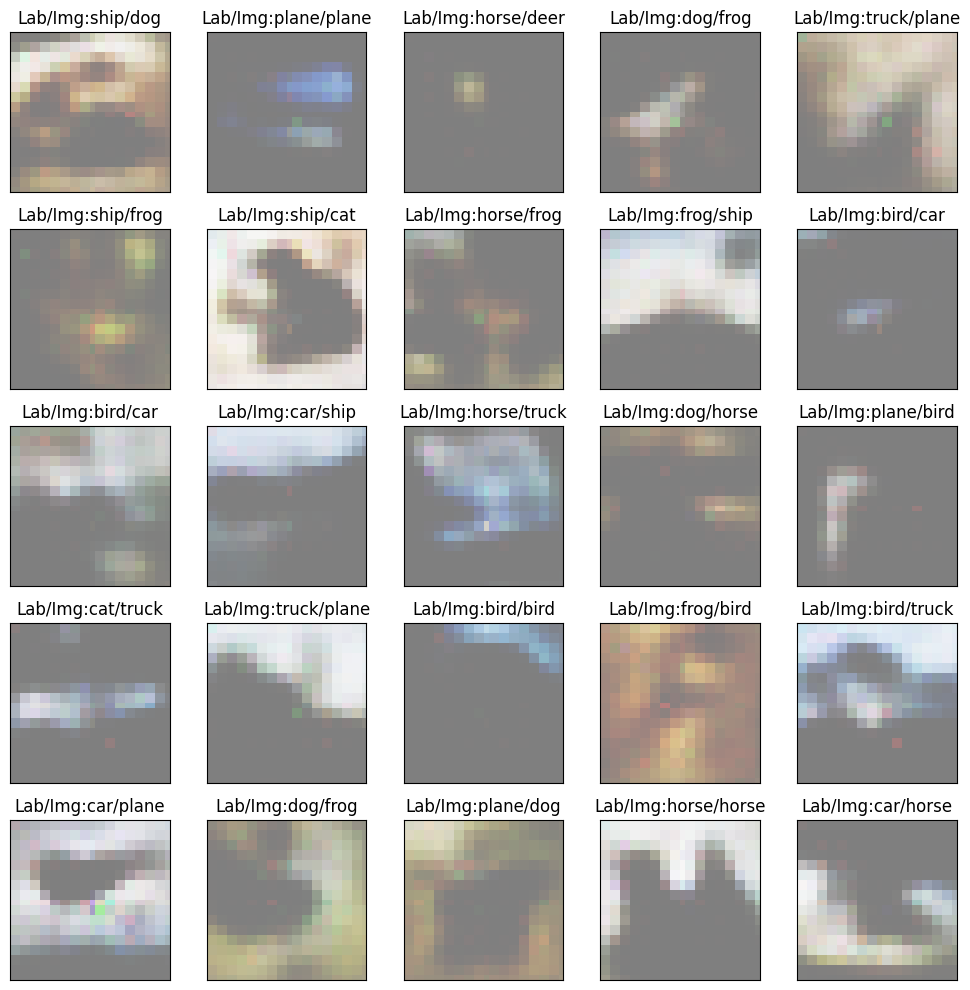

Epoch 369: 100%|██████████| 98/98 [00:07<00:00, 12.51it/s, v_num=5, elbo_train_step=1.51e+3, total_loss_train_step=2.640, label_loss_train_step=1.120, avg_diff_primary_train_step=0.0128, avg_diff_secondary_train_step=0.0116, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.730, label_loss_train_epoch=1.140, avg_diff_primary_train_epoch=0.0168, avg_diff_secondary_train_epoch=0.0116, elbo_val_step=1.75e+3, total_loss_val_step=3.620, label_loss_val_step=1.870, avg_diff_primary_val_step=0.173, avg_diff_secondary_val_step=0.015, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.240, avg_diff_primary_val_epoch=0.229, avg_diff_secondary_val_epoch=0.0145] 

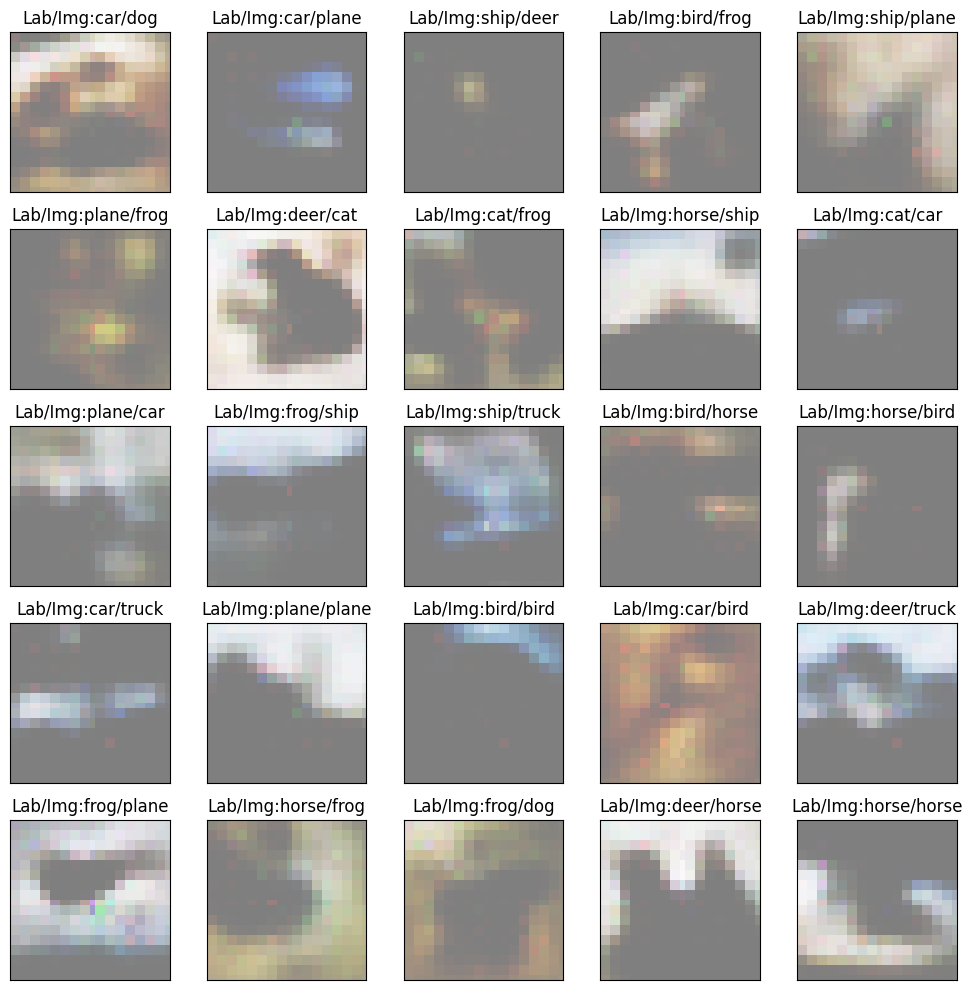

Epoch 374: 100%|██████████| 98/98 [00:08<00:00, 12.11it/s, v_num=5, elbo_train_step=1.55e+3, total_loss_train_step=2.700, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0189, avg_diff_secondary_train_step=0.0116, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0159, avg_diff_secondary_train_epoch=0.0112, elbo_val_step=1.74e+3, total_loss_val_step=3.690, label_loss_val_step=1.950, avg_diff_primary_val_step=0.243, avg_diff_secondary_val_step=0.0161, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.230, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0139] 

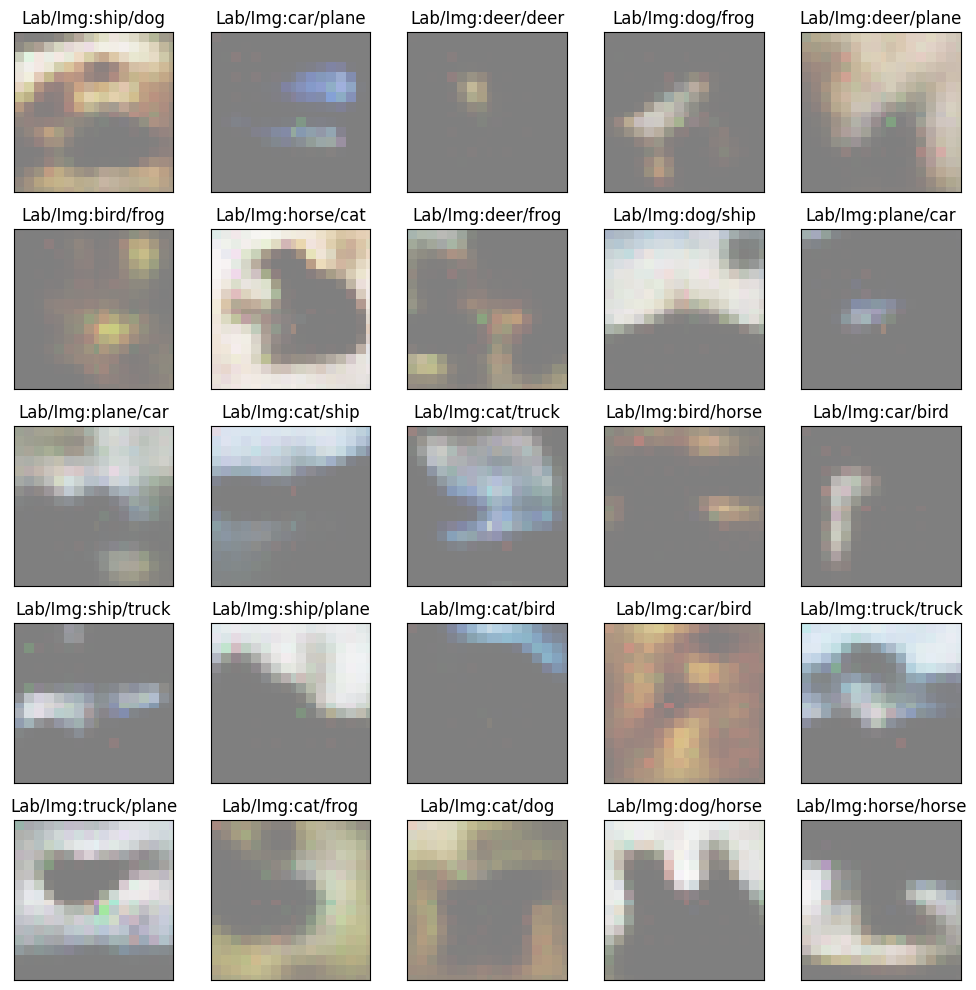

Epoch 379: 100%|██████████| 98/98 [00:07<00:00, 12.39it/s, v_num=5, elbo_train_step=1.61e+3, total_loss_train_step=2.750, label_loss_train_step=1.140, avg_diff_primary_train_step=0.016, avg_diff_secondary_train_step=0.0103, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0155, avg_diff_secondary_train_epoch=0.0112, elbo_val_step=1.74e+3, total_loss_val_step=3.400, label_loss_val_step=1.660, avg_diff_primary_val_step=0.117, avg_diff_secondary_val_step=0.0162, elbo_val_epoch=1.55e+3, total_loss_val_epoch=3.740, label_loss_val_epoch=2.190, avg_diff_primary_val_epoch=0.227, avg_diff_secondary_val_epoch=0.0134]  

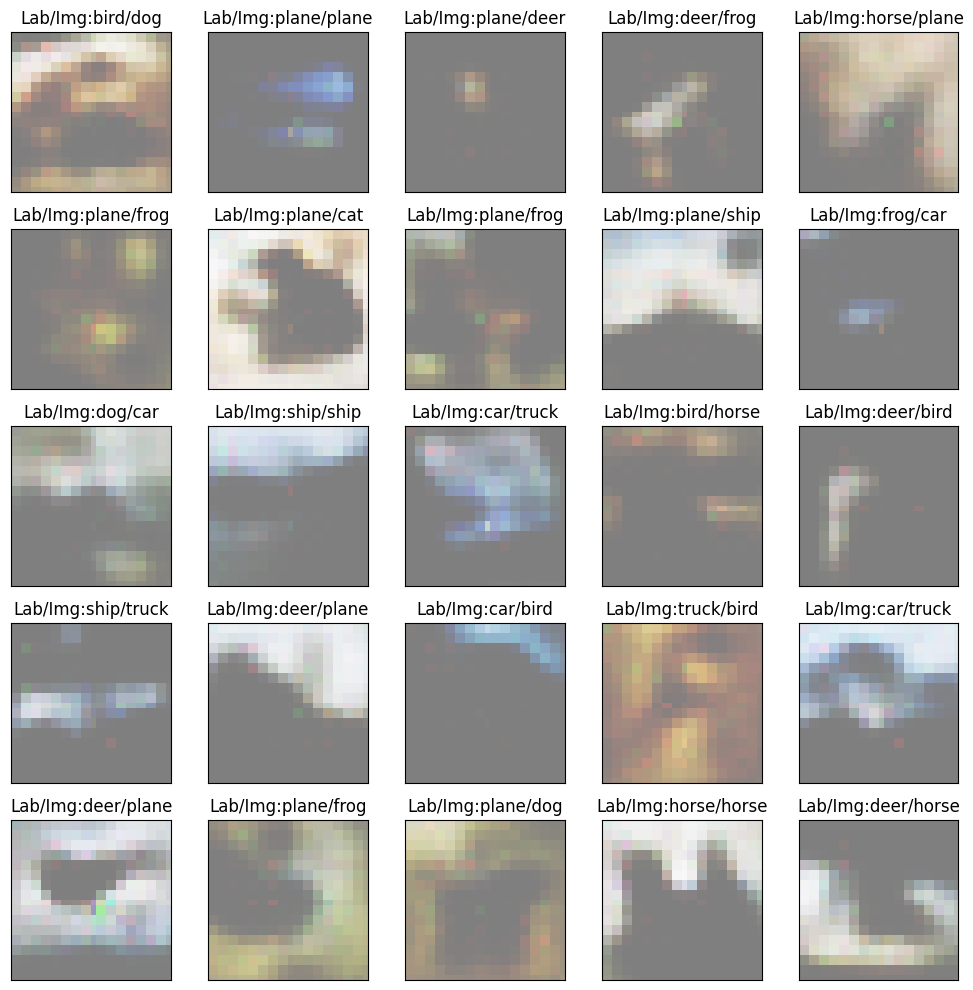

Epoch 384: 100%|██████████| 98/98 [00:07<00:00, 12.58it/s, v_num=5, elbo_train_step=1.62e+3, total_loss_train_step=2.750, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0107, avg_diff_secondary_train_step=0.011, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0158, avg_diff_secondary_train_epoch=0.011, elbo_val_step=1.74e+3, total_loss_val_step=3.430, label_loss_val_step=1.690, avg_diff_primary_val_step=0.106, avg_diff_secondary_val_step=0.0156, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.200, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0139]   

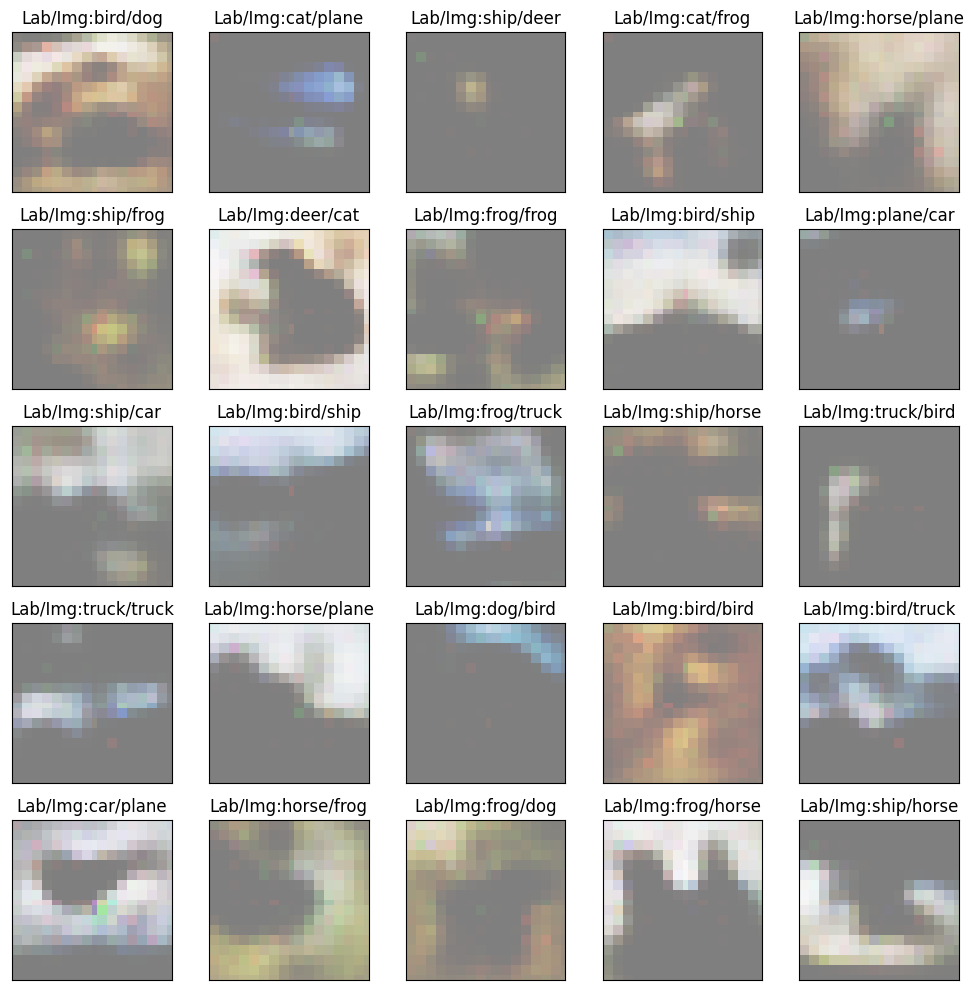

Epoch 389: 100%|██████████| 98/98 [00:08<00:00, 12.14it/s, v_num=5, elbo_train_step=1.65e+3, total_loss_train_step=2.770, label_loss_train_step=1.120, avg_diff_primary_train_step=0.0116, avg_diff_secondary_train_step=0.0116, elbo_train_epoch=1.59e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.015, avg_diff_secondary_train_epoch=0.0109, elbo_val_step=1.74e+3, total_loss_val_step=3.420, label_loss_val_step=1.680, avg_diff_primary_val_step=0.158, avg_diff_secondary_val_step=0.0194, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0134]  

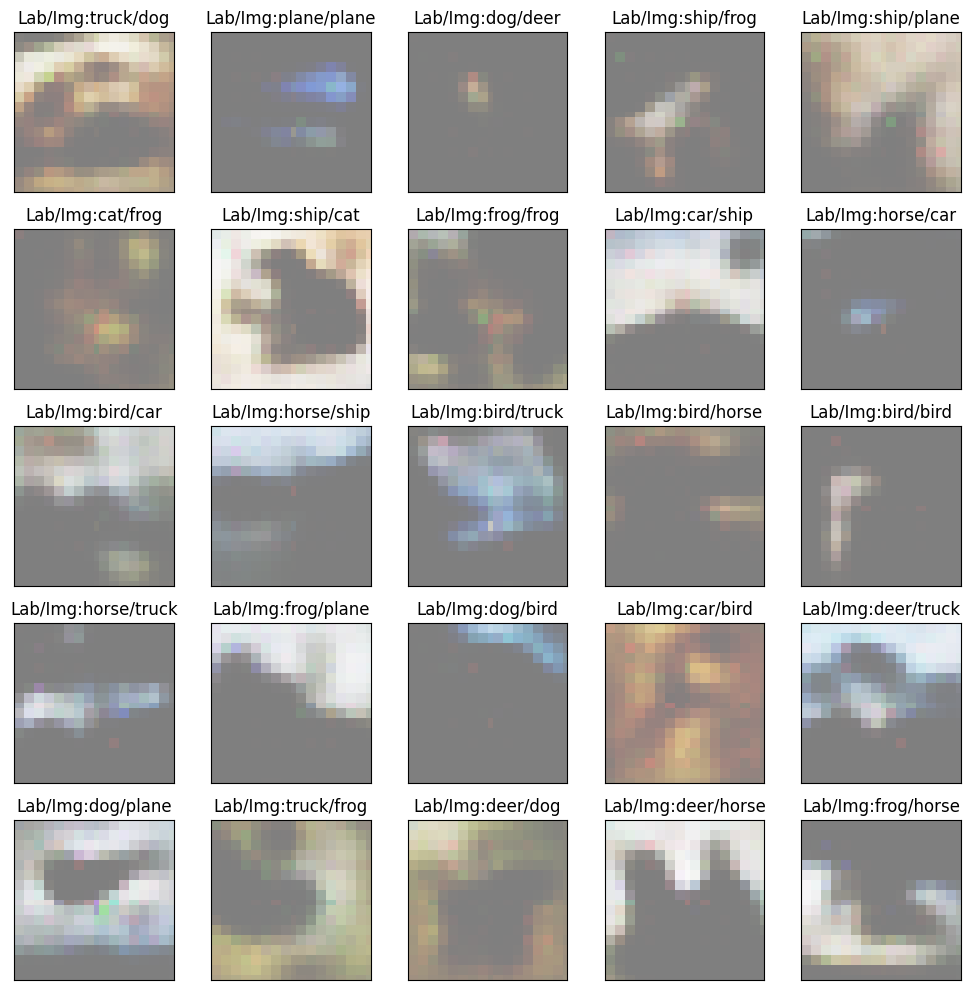

Epoch 394: 100%|██████████| 98/98 [00:07<00:00, 12.54it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.770, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0139, avg_diff_secondary_train_step=0.0106, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0149, avg_diff_secondary_train_epoch=0.0109, elbo_val_step=1.74e+3, total_loss_val_step=3.490, label_loss_val_step=1.760, avg_diff_primary_val_step=0.168, avg_diff_secondary_val_step=0.0129, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.230, avg_diff_primary_val_epoch=0.230, avg_diff_secondary_val_epoch=0.0139] 

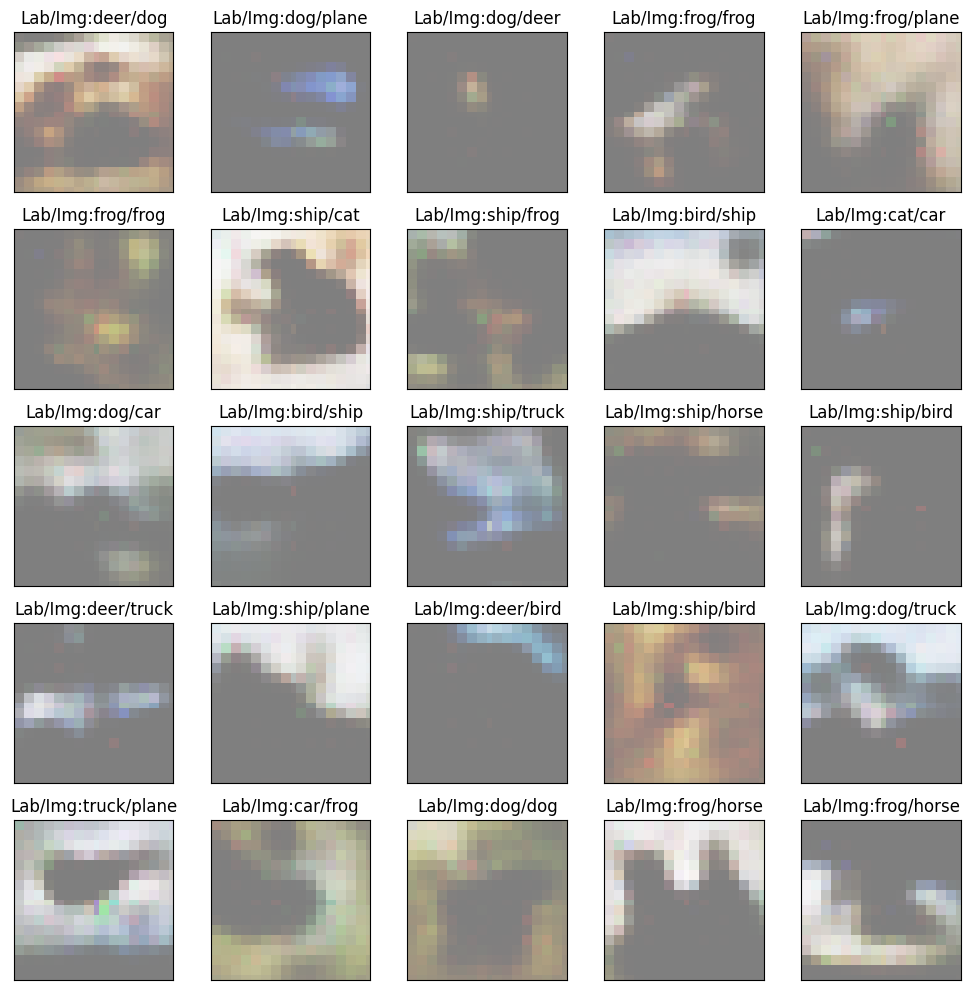

Epoch 399: 100%|██████████| 98/98 [00:07<00:00, 12.59it/s, v_num=5, elbo_train_step=1.63e+3, total_loss_train_step=2.770, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0191, avg_diff_secondary_train_step=0.0118, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.720, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0153, avg_diff_secondary_train_epoch=0.0109, elbo_val_step=1.73e+3, total_loss_val_step=3.930, label_loss_val_step=2.200, avg_diff_primary_val_step=0.215, avg_diff_secondary_val_step=0.00896, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.210, avg_diff_primary_val_epoch=0.226, avg_diff_secondary_val_epoch=0.0137] 

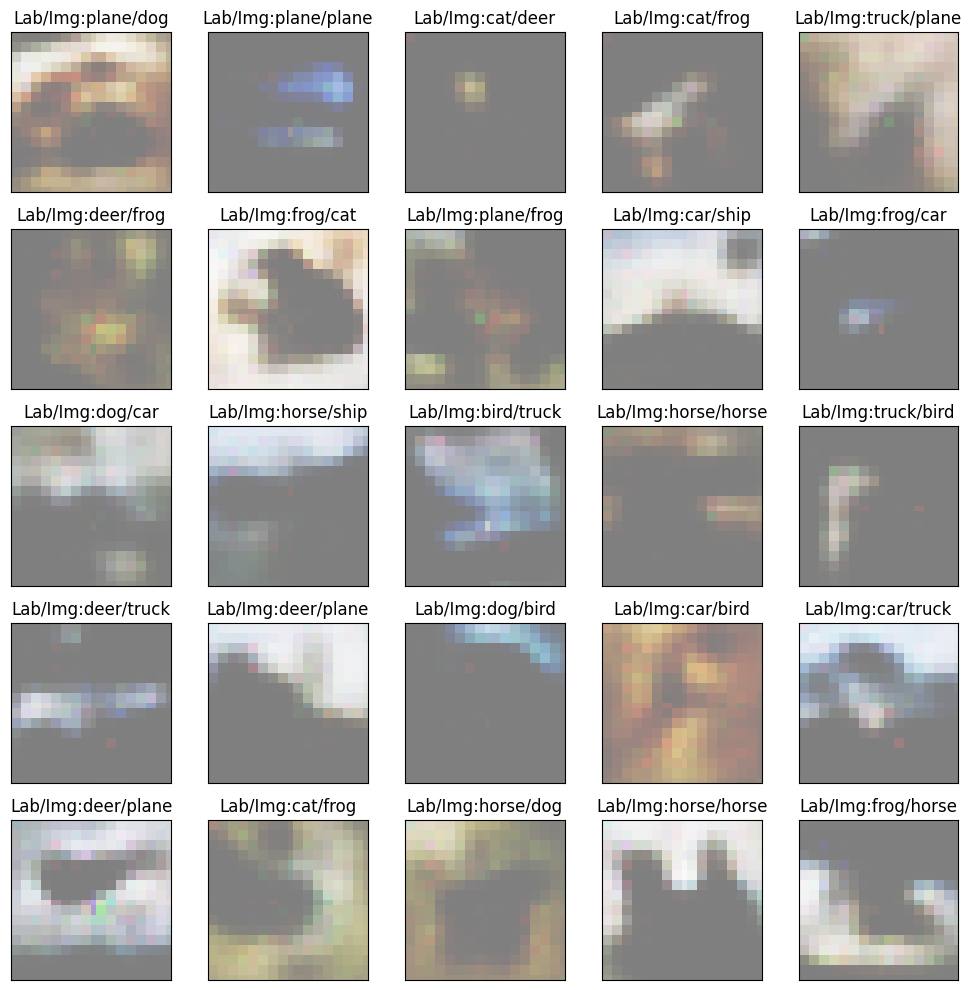

Epoch 404: 100%|██████████| 98/98 [00:07<00:00, 12.46it/s, v_num=5, elbo_train_step=1.7e+3, total_loss_train_step=2.820, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0133, avg_diff_secondary_train_step=0.0105, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.014, avg_diff_secondary_train_epoch=0.0106, elbo_val_step=1.73e+3, total_loss_val_step=4.010, label_loss_val_step=2.280, avg_diff_primary_val_step=0.263, avg_diff_secondary_val_step=0.0217, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.770, label_loss_val_epoch=2.230, avg_diff_primary_val_epoch=0.228, avg_diff_secondary_val_epoch=0.0149]   

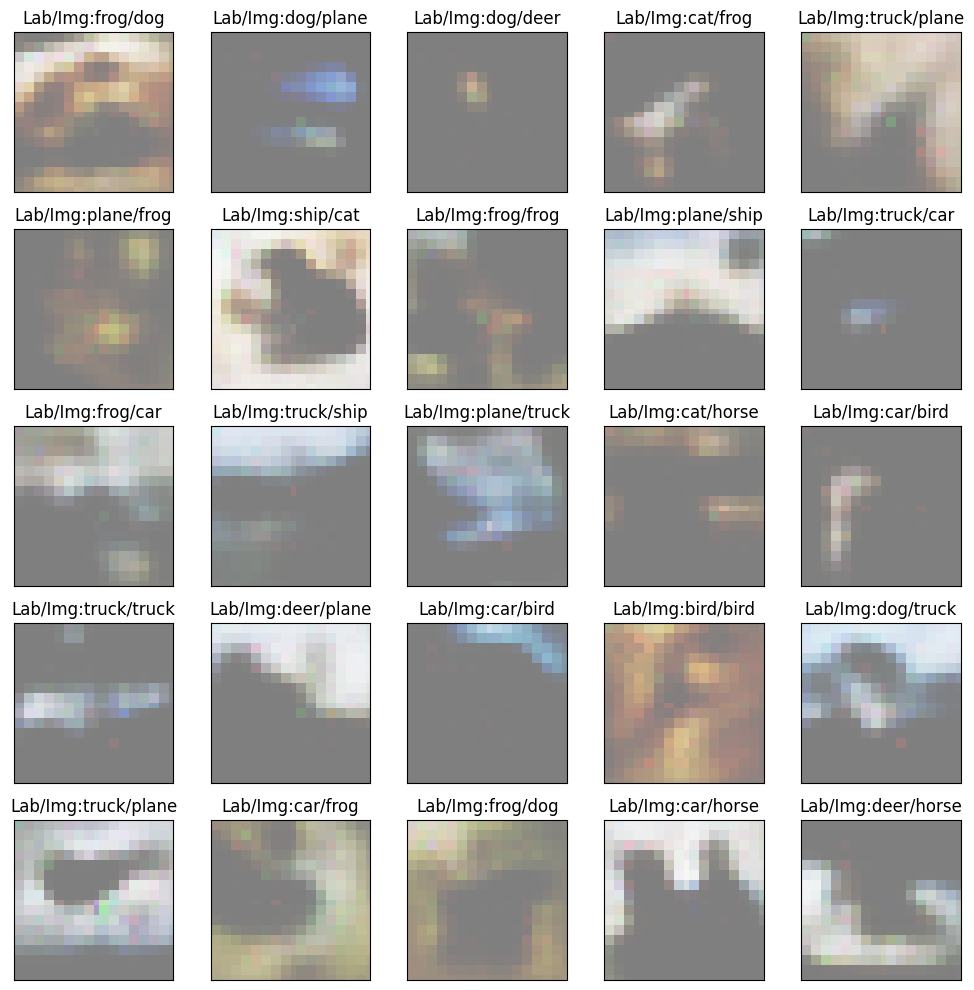

Epoch 409: 100%|██████████| 98/98 [00:07<00:00, 12.39it/s, v_num=5, elbo_train_step=1.53e+3, total_loss_train_step=2.650, label_loss_train_step=1.130, avg_diff_primary_train_step=0.012, avg_diff_secondary_train_step=0.00994, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0144, avg_diff_secondary_train_epoch=0.0106, elbo_val_step=1.74e+3, total_loss_val_step=3.490, label_loss_val_step=1.760, avg_diff_primary_val_step=0.154, avg_diff_secondary_val_step=0.017, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0131]  

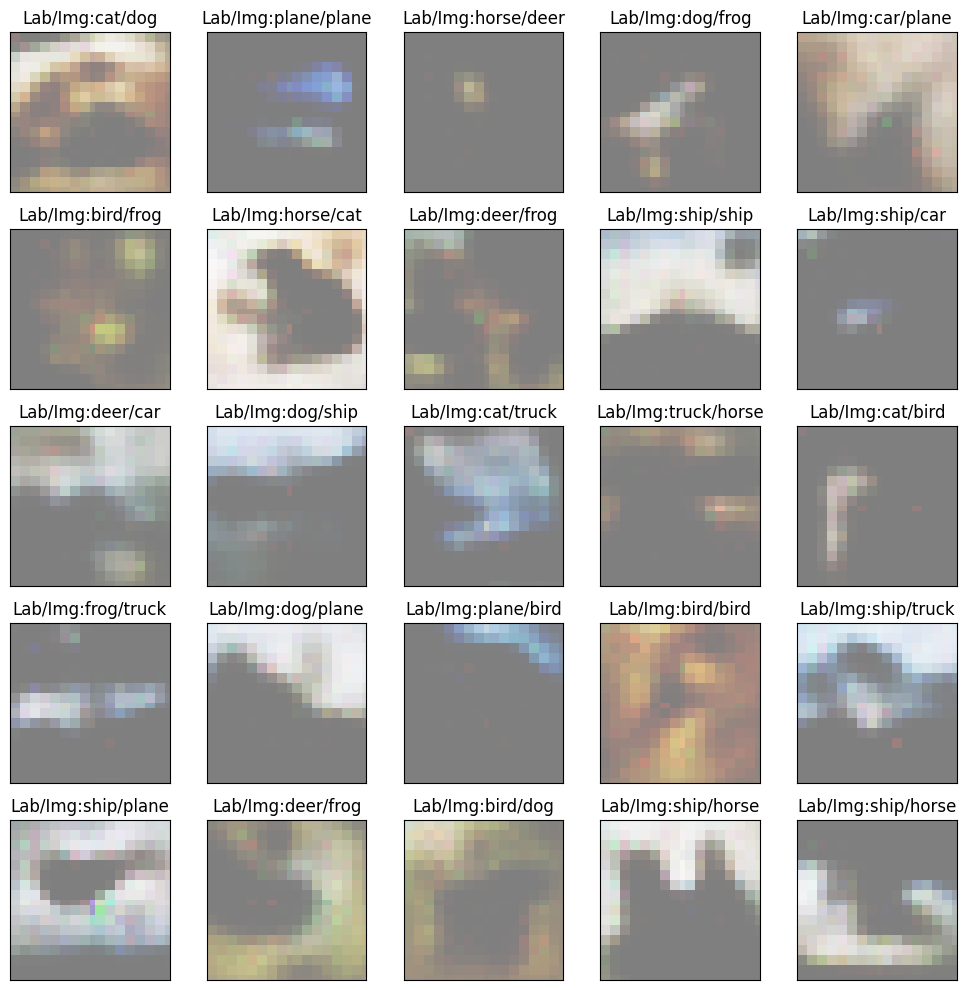

Epoch 414: 100%|██████████| 98/98 [00:08<00:00, 12.24it/s, v_num=5, elbo_train_step=1.57e+3, total_loss_train_step=2.710, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0183, avg_diff_secondary_train_step=0.0104, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0139, avg_diff_secondary_train_epoch=0.0105, elbo_val_step=1.73e+3, total_loss_val_step=3.910, label_loss_val_step=2.170, avg_diff_primary_val_step=0.254, avg_diff_secondary_val_step=0.0157, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.226, avg_diff_secondary_val_epoch=0.0137]  

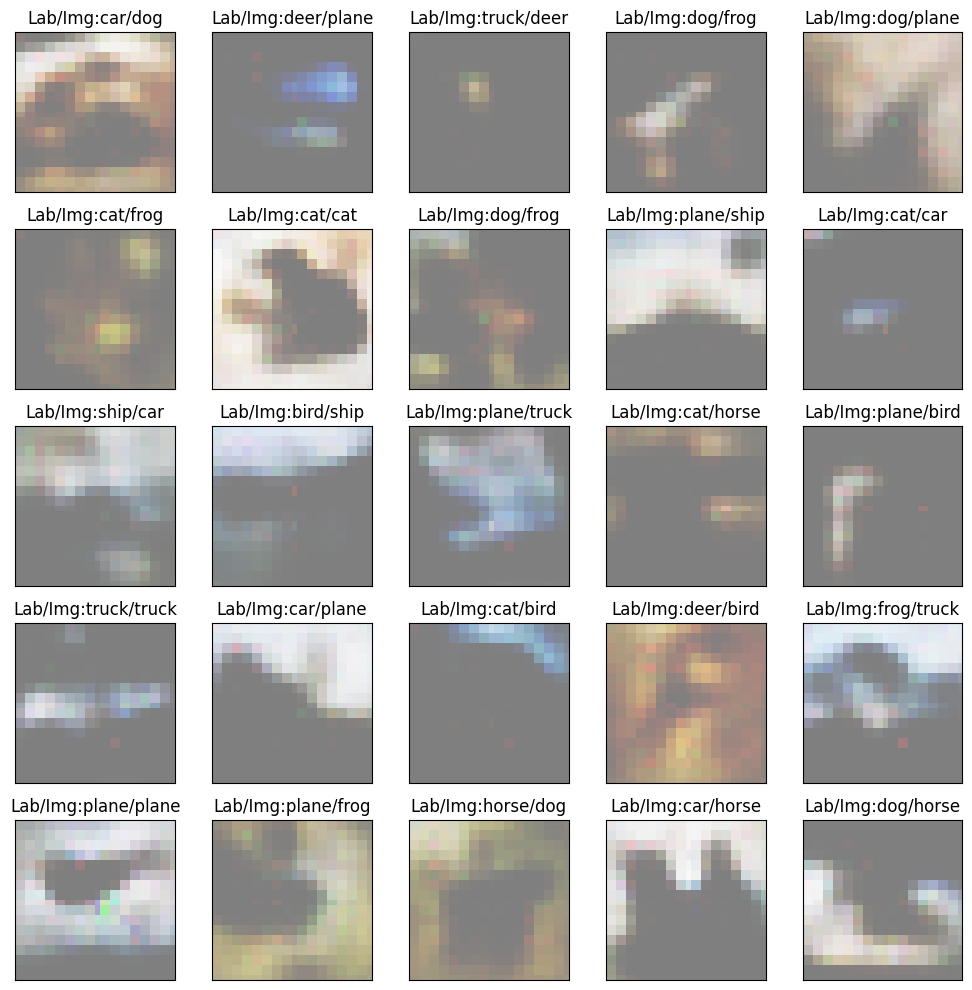

Epoch 419: 100%|██████████| 98/98 [00:07<00:00, 12.44it/s, v_num=5, elbo_train_step=1.65e+3, total_loss_train_step=2.800, label_loss_train_step=1.150, avg_diff_primary_train_step=0.0178, avg_diff_secondary_train_step=0.0103, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0141, avg_diff_secondary_train_epoch=0.0106, elbo_val_step=1.73e+3, total_loss_val_step=3.560, label_loss_val_step=1.830, avg_diff_primary_val_step=0.236, avg_diff_secondary_val_step=0.019, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0135]  

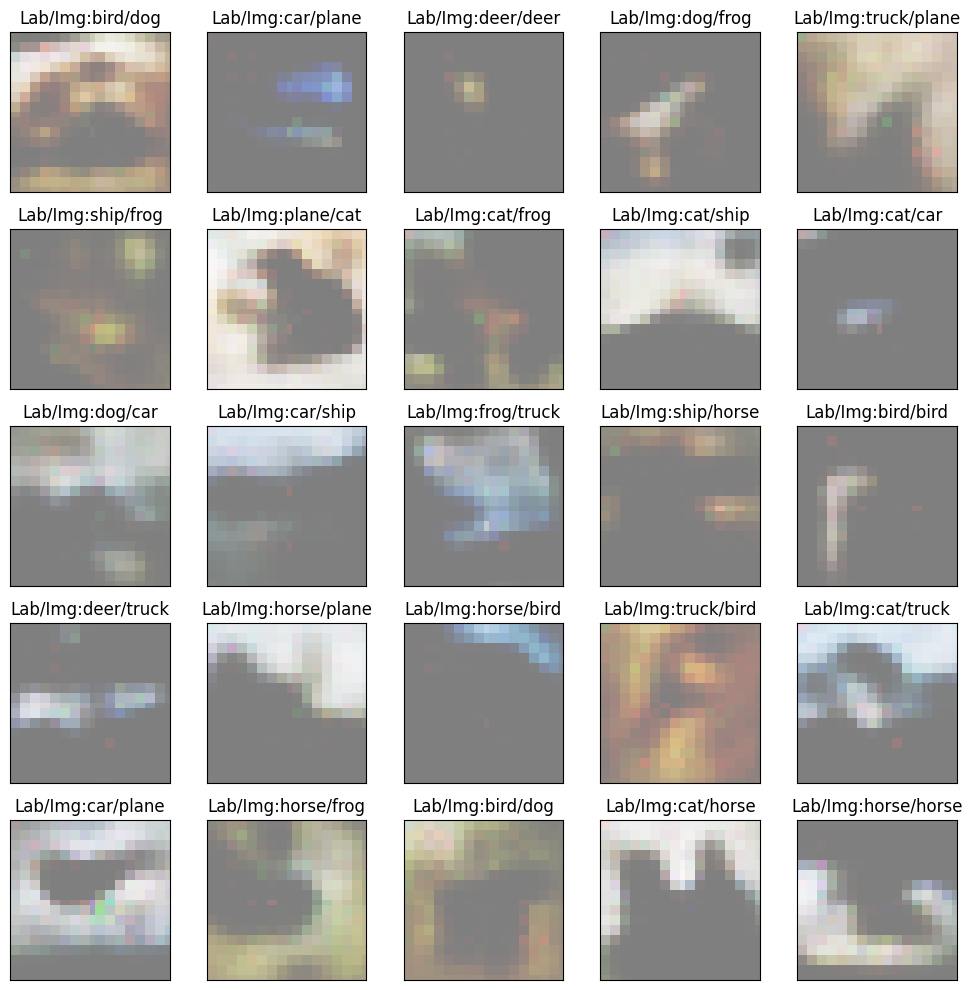

Epoch 424: 100%|██████████| 98/98 [00:07<00:00, 12.47it/s, v_num=5, elbo_train_step=1.64e+3, total_loss_train_step=2.770, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0161, avg_diff_secondary_train_step=0.0105, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0137, avg_diff_secondary_train_epoch=0.0104, elbo_val_step=1.73e+3, total_loss_val_step=3.300, label_loss_val_step=1.570, avg_diff_primary_val_step=0.149, avg_diff_secondary_val_step=0.0181, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.227, avg_diff_secondary_val_epoch=0.013]  

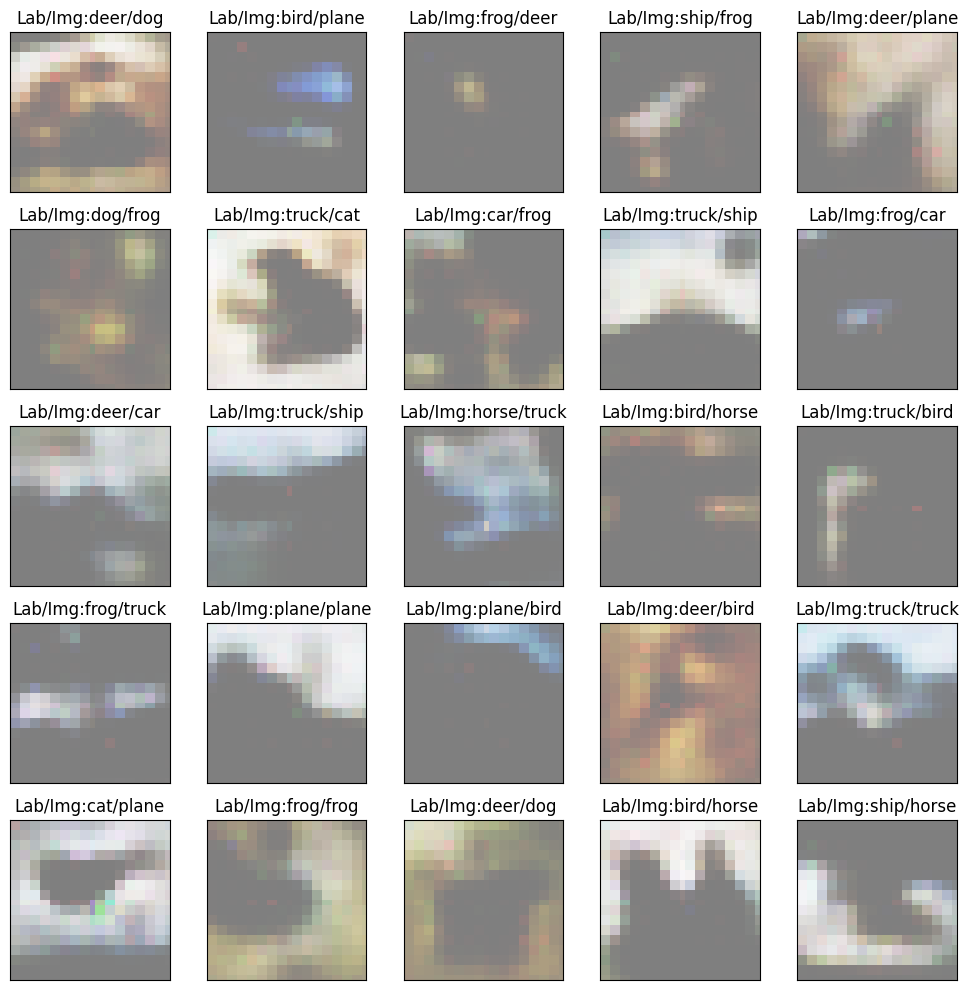

Epoch 429: 100%|██████████| 98/98 [00:07<00:00, 12.49it/s, v_num=5, elbo_train_step=1.51e+3, total_loss_train_step=2.640, label_loss_train_step=1.120, avg_diff_primary_train_step=0.012, avg_diff_secondary_train_step=0.010, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.710, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0137, avg_diff_secondary_train_epoch=0.0102, elbo_val_step=1.73e+3, total_loss_val_step=3.680, label_loss_val_step=1.950, avg_diff_primary_val_step=0.201, avg_diff_secondary_val_step=0.0143, elbo_val_epoch=1.54e+3, total_loss_val_epoch=3.750, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.224, avg_diff_secondary_val_epoch=0.0132]    

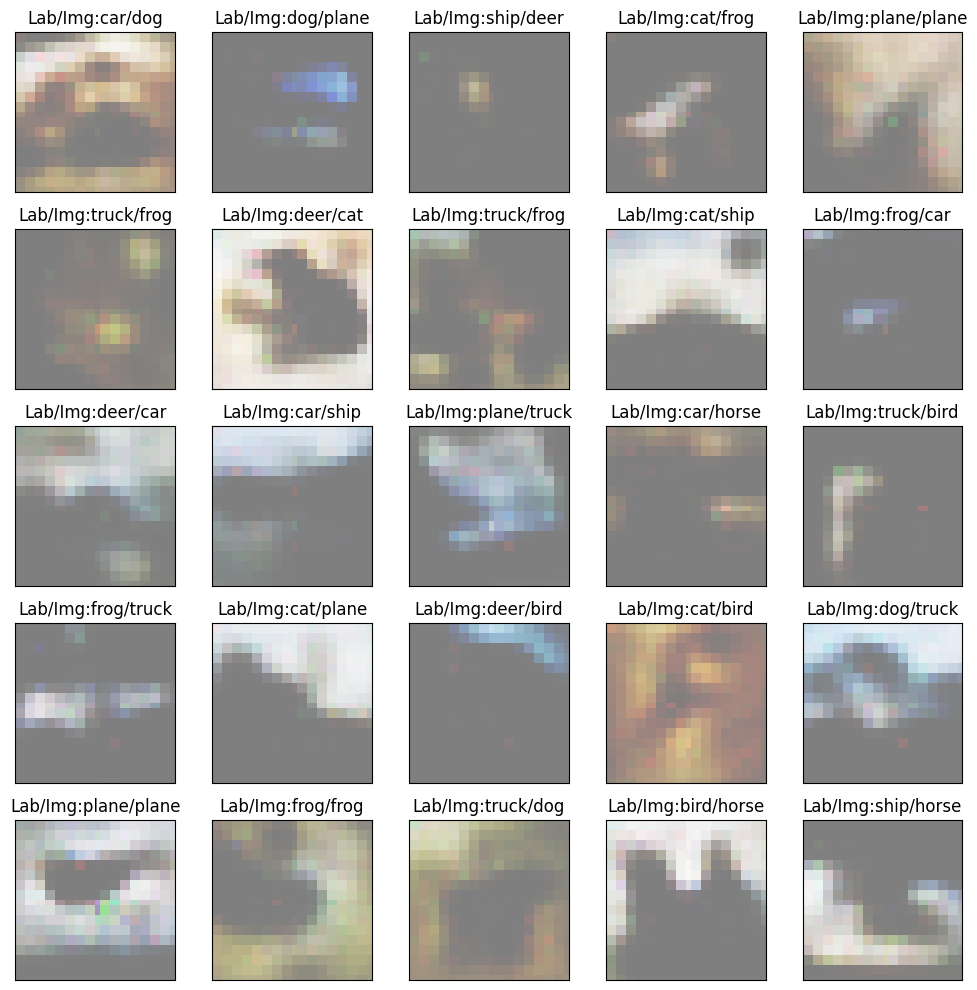

Epoch 434: 100%|██████████| 98/98 [00:07<00:00, 12.41it/s, v_num=5, elbo_train_step=1.56e+3, total_loss_train_step=2.690, label_loss_train_step=1.130, avg_diff_primary_train_step=0.0145, avg_diff_secondary_train_step=0.0103, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.700, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0129, avg_diff_secondary_train_epoch=0.0101, elbo_val_step=1.73e+3, total_loss_val_step=3.810, label_loss_val_step=2.090, avg_diff_primary_val_step=0.223, avg_diff_secondary_val_step=0.0165, elbo_val_epoch=1.53e+3, total_loss_val_epoch=3.760, label_loss_val_epoch=2.220, avg_diff_primary_val_epoch=0.225, avg_diff_secondary_val_epoch=0.0129]  

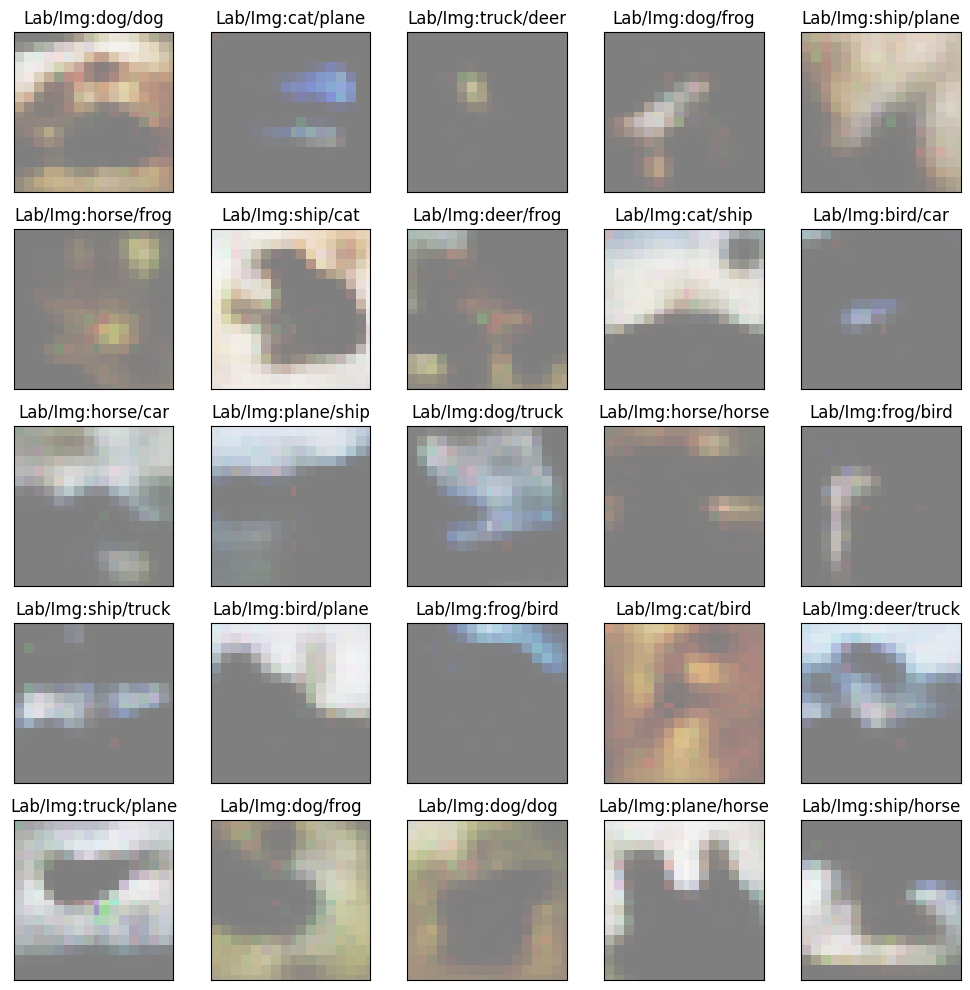

Epoch 439:  11%|█         | 11/98 [00:01<00:13,  6.56it/s, v_num=5, elbo_train_step=1.54e+3, total_loss_train_step=2.670, label_loss_train_step=1.130, avg_diff_primary_train_step=0.012, avg_diff_secondary_train_step=0.0112, elbo_train_epoch=1.58e+3, total_loss_train_epoch=2.700, label_loss_train_epoch=1.130, avg_diff_primary_train_epoch=0.0123, avg_diff_secondary_train_epoch=0.00992, elbo_val_step=1.73e+3, total_loss_val_step=3.480, label_loss_val_step=1.750, avg_diff_primary_val_step=0.174, avg_diff_secondary_val_step=0.0155, elbo_val_epoch=1.53e+3, total_loss_val_epoch=3.780, label_loss_val_epoch=2.240, avg_diff_primary_val_epoch=0.231, avg_diff_secondary_val_epoch=0.0134]   

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [19]:
%matplotlib inline
vae = VAE()
trainer = pl.Trainer(
                     log_every_n_steps=1,
                     check_val_every_n_epoch=5,
                     enable_model_summary=True,
                     max_epochs=1000,
                     accelerator='auto',
                     devices='auto',
                     strategy='auto',
                     logger=[TensorBoardLogger("logs/", name="BVAE-CIFAR")],
                     callbacks=[LearningRateMonitor(logging_interval="step")]
                     )
trainer.fit(vae, train_loader, val_loader)